
Alma Hmida
Beatrice Infurna
Narmine Baouab

acadamic year: 2025 - 2026

Big Data project



# **BINARY-CLASS MODEL MATRIX** – Order Prediction

# **Data Loading**

In [ ]:
#There are several data sources that we'll use:
"""
  order_items: information about
  orders: information about
  products:
  website_pageviews:
  website_sessions:

  website_pageviews:
  website_sessions:
"""

'\n  order_items: information about\n  orders: information about\n  products:\n  website_pageviews:\n  website_sessions:\n\n  website_pageviews:\n  website_sessions:\n'

In [ ]:
#Setting the file paths for the datasets used in the training
order_items_path = "/content/drive/MyDrive/BigData/Project/Data/data/order_items.parquet"
orders_path = "/content/drive/MyDrive/BigData/Project/Data/data/orders.parquet"
products_path= "/content/drive/MyDrive/BigData/Project/Data/data/products.parquet"
website_pageviews_path="/content/drive/MyDrive/BigData/Project/Data/data/website_pageviews.parquet"
website_sessions_path= "/content/drive/MyDrive/BigData/Project/Data/data/website_sessions.parquet"

#Setting the file paths for the datasets used in the testing
website_pageviews_holdout_path="/content/drive/MyDrive/BigData/Project/Data/holdout_data/website_pageviews_holdout.parquet"
website_sessions_holdout_path= "/content/drive/MyDrive/BigData/Project/Data/holdout_data/website_sessions_holdout.parquet"

In [ ]:
#Setup Spark in Colab
#####################
!pip install -q pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Spark_in_Colab").getOrCreate()
spark.createDataFrame([{"status": "Spark is working!", "location": "Google Colab"}]).show()

#Mount our Google Drive folder so we can access our data files on Colab
from google.colab import drive
drive.mount('/content/drive')

+------------+-----------------+
|    location|           status|
+------------+-----------------+
|Google Colab|Spark is working!|
+------------+-----------------+

Mounted at /content/drive


# **Loading Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import lower
from pyspark.sql.types import NumericType

# PySpark Core & Types
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import (
    TimestampType, DoubleType, IntegerType,
    LongType, FloatType, StringType
)

# PySpark SQL Functions
# Added 'count' and 'avg' which are often used in your helper functions
from pyspark.sql.functions import (
    col, when, lit, count, countDistinct,
    avg, stddev, isnan, year,
    sum as spark_sum,
    max as spark_max,
    min as spark_min,
    round as spark_round,
    to_timestamp, datediff, unix_timestamp,
    hour, dayofweek, row_number, lag, greatest,
    monotonically_increasing_id
)

# PySpark ML - Features & Functions
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array
from pyspark.ml.stat import Correlation

# PySpark ML - Classifiers
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)

# PySpark ML - Evaluation
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)

# **Initial inspection**

In [ ]:
order_items = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(order_items_path)
order_items.show(5)

#printing Schema
order_items.printSchema()

#inspecting the statistics
order_items.describe().show()

#inspecting nulls
order_items.select([count(when(col(c).isNull(), c)).alias(c) for c in order_items.columns]).show()

#inspecting NaNs
order_items.where(
    isnan(col("order_item_id")) |
    isnan(col("order_id")) |
    isnan(col("product_id"))|
    isnan(col("is_primary_item"))|
    isnan(col("price_euro"))|
    isnan(col("cogs_euro"))
).count()


In [ ]:
orders= spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(orders_path)
orders.show(5)

#printing Schema
orders.printSchema()

#inspecting the statistics
orders.describe().show()

#inspecting nulls
orders.select([count(when(col(c).isNull(), c)).alias(c) for c in orders.columns]).show()

#inspecting NaN
orders.where(
    isnan(col("website_session_id")) |
    isnan(col("user_id")) |
    isnan(col("primary_product_id"))|
    isnan(col("items_purchased"))|
    isnan(col("price_euro"))|
    isnan(col("cogs_euro"))
).count()

In [ ]:
products = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(products_path)
products.show(5)

#printing schema
products.printSchema()

#inspecting statistics
products.describe().show()

#inspecting nulls
products.select([count(when(col(c).isNull(), c)).alias(c) for c in products.columns]).show()

#inspectinf Nans
products.where(
    isnan(col("product_id"))
).count()

In [ ]:
website_pageviews = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(website_pageviews_path)
website_pageviews.show(5)

#printing schema
website_pageviews.printSchema()

#inspecting statistics
website_pageviews.describe().show()

#inspecting nulls
website_pageviews.select([count(when(col(c).isNull(), c)).alias(c) for c in website_pageviews.columns]).show()

#inspecting NaN
website_pageviews.where(
    isnan(col("website_pageview_id")) |
    isnan(col("website_session_id"))
).count()

In [ ]:
website_sessions = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(website_sessions_path)
website_sessions.show(5)

#printing schema
website_sessions.printSchema()

#inspecting statistics
website_sessions.describe().show()

#inspecting nulls
website_sessions.select([count(when(col(c).isNull(), c)).alias(c) for c in website_sessions.columns]).show()

#inspecting NaN
website_sessions.where(
    isnan(col("website_session_id")) |
    isnan(col("is_repeat_session"))
).count()

In [ ]:
# The null inspection shows that all the tables don't have any null values

In [ ]:
#loading the scoring data
website_pageviews_holdout = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(website_pageviews_holdout_path)
website_pageviews_holdout.show(5)

#printing schema
website_pageviews_holdout.printSchema()

#inspecting statistics
website_pageviews_holdout.describe().show()

#inspecting nulls
website_pageviews_holdout.select([count(when(col(c).isNull(), c)).alias(c) for c in website_pageviews_holdout.columns]).show()


#inspecting NaN
website_pageviews_holdout.where(
    isnan(col("website_pageview_id")) |
    isnan(col("website_session_id"))
).count()


In [ ]:
website_sessions_holdout = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .parquet(website_sessions_holdout_path)
website_sessions_holdout.show(5)

#printing schema
website_sessions_holdout.printSchema()

#inspecting statistics
website_sessions_holdout.describe().show()

#inspecting nulls
website_sessions_holdout.select([count(when(col(c).isNull(), c)).alias(c) for c in website_sessions_holdout.columns]).show()

#inspecting NaN
website_sessions_holdout.where(
    isnan(col("website_session_id")) |
    isnan(col("is_repeat_session"))
).count()


In [ ]:
# Inspecting specific columns
order_items.select(col("product_id"), col("price_euro")).distinct().show()

In [ ]:
website_pageviews.select(col("pageview_url")).distinct().show(15)

In [ ]:
# In this part we are counting the frequency of unique values in every column of website_sessions & website_sessions_holdout to explore data distribution.

In [ ]:
for c in website_sessions.columns:
    print(f"\n Group by {c}")
    website_sessions \
        .groupBy(c) \
        .agg(count("*").alias("sessions_count")) \
        .show()

In [ ]:
for c in website_sessions_holdout.columns:
    print(f"\n Group by {c}")
    website_sessions_holdout \
        .groupBy(c) \
        .agg(count("*").alias("sessions_count")) \
        .show()

In [ ]:
  # In this part we are checking on the min-max dates for few tables to decide on the time window

In [ ]:
products.select(col("product_name")).distinct().show()

In [ ]:
order_items.select(col("created_at")).summary("min","max").show(3)

In [ ]:
products.select(col("created_at")).summary("min","max").show(3)

In [ ]:
website_sessions_holdout.select(col("created_at")).summary("min","max").show(3)

# **Data cleaning tables**

In [ ]:
# We will cast "created_at column" from str to timestamp in all tables

In [ ]:
products = products.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

order_items = order_items.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

orders = orders.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

website_sessions = website_sessions.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

website_pageviews = website_pageviews.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

website_pageviews_holdout = website_pageviews_holdout.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")

website_sessions_holdout = website_sessions_holdout.withColumn("date_of_creation", col("created_at").cast("timestamp")).drop("created_at")


In [ ]:
# We are check on duplicates

In [ ]:
products.count()

In [ ]:
products.dropDuplicates().count()

In [ ]:
order_items.count()

In [ ]:
order_items.dropDuplicates().count()

In [ ]:
orders.count()

In [ ]:
orders.dropDuplicates().count()

In [ ]:
website_sessions.count()

In [ ]:
website_sessions.dropDuplicates().count()

In [ ]:
website_pageviews.count()

In [ ]:
website_pageviews.dropDuplicates().count()

In [ ]:
website_sessions_holdout.count()

In [ ]:
website_sessions_holdout.dropDuplicates().count()

In [ ]:
website_pageviews_holdout.count()

In [ ]:
website_pageviews_holdout.dropDuplicates().count()

In [ ]:
website_sessions.printSchema()

**Note:** Our feature extraction is designed as a modular pipeline. We build features within reusable functions so that we can consistently apply the same logic to the Training, Validation, and Holdout sets simply by shifting the input time window. This prevents code duplication and ensures mathematical consistency across all datasets.

# **Defining timewindow**

We apply a chronological split to create training, validation, and test periods.
Within each period, conversion is modeled at the session level using only information available during that session.
Orders are joined at the session level to construct labels; IV/DV time windows are not used to define causality

In [ ]:
def split_by_time_window(
    df: DataFrame,
    timestamp_col: str,

    # TRAIN
    train_iv_start: str = "2022-03-19 00:00:00",
    train_iv_end:   str = "2023-11-30 23:59:59",

    # VALIDATION
    valid_iv_start: str = "2023-12-01 00:00:00",
    valid_iv_end:   str = "2024-06-30 23:59:59",

    # TEST
    test_iv_start: str = "2024-07-01 00:00:00",
    test_iv_end:   str = "2025-01-30 23:59:59",

    # HOLDOUT
    holdout_start: str = "2025-02-01 00:00:00",
    holdout_end:   str = "2025-03-19 23:59:59"
):
    """
    Strict chronological split.
    """

    train_iv = df.filter(
        (col(timestamp_col) >= train_iv_start) &
        (col(timestamp_col) <= train_iv_end)
    )

    valid_iv = df.filter(
        (col(timestamp_col) >= valid_iv_start) &
        (col(timestamp_col) <= valid_iv_end)
    )

    test_iv = df.filter(
        (col(timestamp_col) >= test_iv_start) &
        (col(timestamp_col) <= test_iv_end)
    )

    holdout = df.filter(
        (col(timestamp_col) >= holdout_start) &
        (col(timestamp_col) <= holdout_end)
    )

    return train_iv, valid_iv, test_iv, holdout



# **Feature engineering**

**Introduction to Modeling Strategy**

After inspecting the data, we believe this is a Conversion Propensity Model, which would allow Vauban-50 for real-time intervention, as they asked of us. Unlike a traditional churn model that predicts long-term behavior, this model focuses on the "intent" of a user during a specific visit.

**Timeline and Data Grain**

To ensure the model is robust and generalizable, we divided our data chronologically into Training, Validation, and Testing sets. However, our approach to the timeline differs from standard predictive models in two key ways:


1.   **Session-Level Analysis**: Everything is calculated at the session level. This is a strategic choice driven by the high volume of new users in the holdout session. By focusing on the session, we can capture the behavior of first-time visitors who have no prior history but may show high buying intent "in the moment."
2.    **The "Fluid" DV** : In this architecture, we do not use a distant Dependent Variable (DV). Because conversion happens quickly in e-commerce, the features and the outcome (the purchase) occur within the same session window.

**Feature Engineering Logic**
To prevent data leakage while maintaining real-time relevance, our features are engineered to reflect the user's state at the exact moment of the session. We combine:

*   **Contextual Features**: Device type, traffic source, and time of day.
*   **Behavioral Features**: Pageview depth and interaction intensity within the current session.

This setup ensures that even for a completely anonymous new user, Vauban-50 can predict—within minutes of their arrival—whether they are likely to convert or if they need a real-time nudge to complete the purchase.





In [ ]:
def get_past_sessions(
    sessions_df: DataFrame,
    reference_sessions_df: DataFrame
) -> DataFrame:
    """
    Returns only sessions that happened BEFORE each reference session.
    """

    return (
        reference_sessions_df
        .select(
            col("website_session_id").alias("current_website_session_id"),
            "user_id",
            col("date_of_creation").alias("current_session_ts")
        )
        .join(
            sessions_df.select(
                col("website_session_id").alias("past_website_session_id"),
                "user_id",
                col("date_of_creation").alias("past_session_ts"),
                "is_repeat_session" # Include for repeat session ratio
            ),
            on="user_id",
            how="left"
        )
        .filter(col("past_session_ts") < col("current_session_ts"))
    )

In [ ]:
(
    sessions_train_iv,
    sessions_val_iv,
    sessions_test_iv,
    _
) = split_by_time_window(
    website_sessions,
    timestamp_col="date_of_creation"
)

In [ ]:
sessions_holdout = website_sessions_holdout


The holdout dataset is provided as a separate table representing future unseen sessions and is therefore not extracted via time-based filtering on the training data.

In [ ]:
# Check sets row count

print("Train:", sessions_train_iv.count())
print("Validation:", sessions_val_iv.count())
print("Test:", sessions_test_iv.count())
print("Holdout:", sessions_holdout.count())


In [ ]:
website_sessions.printSchema()


In [ ]:
# Filter orders to TRAIN window AND after session start
orders_train = (
    orders
    .join(
        sessions_train_iv.select(
            "website_session_id",
            col("date_of_creation").alias("session_ts")
        ),
        "website_session_id",
        "inner"
    )
    .filter(col("date_of_creation") >= col("session_ts"))
    .select("website_session_id")
    .withColumn("label", lit(1))
)

sessions_train_iv_labeled = (
    sessions_train_iv
    .join(orders_train, "website_session_id", "left")
    .fillna(0, subset=["label"])
)

orders_val = (
    orders
    .join(
        sessions_val_iv.select(
            "website_session_id",
            col("date_of_creation").alias("session_ts")
        ),
        "website_session_id",
        "inner"
    )
    .filter(col("date_of_creation") >= col("session_ts"))
    .select("website_session_id")
    .withColumn("label", lit(1))
)

sessions_val_iv_labeled = (
    sessions_val_iv
    .join(orders_val, "website_session_id", "left")
    .fillna(0, subset=["label"])
)

orders_test = (
    orders
    .join(
        sessions_test_iv.select(
            "website_session_id",
            col("date_of_creation").alias("session_ts")
        ),
        "website_session_id",
        "inner"
    )
    .filter(col("date_of_creation") >= col("session_ts"))
    .select("website_session_id")
    .withColumn("label", lit(1))
)

sessions_test_iv_labeled = (
    sessions_test_iv
    .join(orders_test, "website_session_id", "left")
    .fillna(0, subset=["label"])
)


In [ ]:
# Class balance check

sessions_train_iv_labeled.groupBy("label").count().show()
sessions_val_iv_labeled.groupBy("label").count().show()
sessions_test_iv_labeled.groupBy("label").count().show()


### Pageview & basic intensity features

In [ ]:
# Filtering pageviews
pageviews_train = website_pageviews.join(
    sessions_train_iv.select("website_session_id"),
    on="website_session_id",
    how="inner"
)


pageviews_val = website_pageviews.join(
    sessions_val_iv.select("website_session_id"),
    on="website_session_id",
    how="inner"
)

pageviews_test = website_pageviews.join(
    sessions_test_iv.select("website_session_id"),
    on="website_session_id",
    how="inner"
)

pageviews_holdout = website_pageviews_holdout

In [ ]:
#PRODUCT LABELING (MULTI-CLASS)
order_items_train = (
    order_items
    .join(
        orders.select(
            "order_id",
            "website_session_id",
            col("date_of_creation").alias("order_ts")
        ),
        "order_id",
        "inner"
    )
    .join(
        sessions_train_iv.select(
            "website_session_id",
            col("date_of_creation").alias("session_ts")
        ),
        "website_session_id",
        "inner"
    )
    .filter(col("order_ts") >= col("session_ts"))
)

session_product_labels_train = (
    order_items_train
    .groupBy("website_session_id")
    .agg(
        spark_max(when(col("product_id") == 1, 1).otherwise(0)).alias("label_product_1"),
        spark_max(when(col("product_id") == 2, 1).otherwise(0)).alias("label_product_2"),
        spark_max(when(col("product_id") == 3, 1).otherwise(0)).alias("label_product_3"),
        spark_max(when(col("product_id") == 4, 1).otherwise(0)).alias("label_product_4"),
    )
)
sessions_train_iv_with_products = (
    sessions_train_iv_labeled
    .join(session_product_labels_train, "website_session_id", "left")
    .fillna(0)
)


#### Session features

In [ ]:
def build_session_context_features(sessions_df: DataFrame) -> DataFrame:
    return (
        sessions_df
        .withColumn("is_mobile", when(col("device_type") == "mobile", 1).otherwise(0))
        .withColumn("is_desktop", when(col("device_type") == "desktop", 1).otherwise(0))
        .withColumn("is_paid", when(col("traffic_source").isin("paid search", "paid social"), 1).otherwise(0))
        .withColumn("is_direct", when(col("traffic_source") == "direct", 1).otherwise(0))
        .withColumn("is_organic", when(col("traffic_source") == "organic search", 1).otherwise(0))
        .withColumn("has_utm_campaign", when(col("utm_campaign").isNotNull(), 1).otherwise(0))
        .withColumn("has_utm_content", when(col("utm_content").isNotNull(), 1).otherwise(0))
    )


In [ ]:
def build_pageview_volume_features(pageviews_df: DataFrame) -> DataFrame:
    """
    SESSION-LEVEL pageview volume features
    One row = one website_session_id
    """

    return (
        pageviews_df
        .groupBy("website_session_id")
        .agg(
            count("*").alias("pv_count"),
            countDistinct("pageview_url").alias("unique_pages_count"),
            spark_sum(
                when(
                    col("pageview_url").rlike(
                        "products|the-techfortress|the-corepack|the-ecoshell|the-airlite"
                    ),
                    1
                ).otherwise(0)
            ).alias("product_pageviews"),

            spark_sum(when(col("pageview_url") == "/cart", 1).otherwise(0))
                .alias("cart_pageviews"),

            spark_sum(when(col("pageview_url") == "/billing", 1).otherwise(0))
                .alias("billing_pageviews"),

            spark_sum(when(col("pageview_url") == "/shipping", 1).otherwise(0))
                .alias("shipping_pageviews"),

            spark_sum(when(col("pageview_url") == "/home", 1).otherwise(0))
                .alias("home_pageviews"),

            spark_sum(when(col("pageview_url").rlike("lander"), 1).otherwise(0))
                .alias("lander_pageviews")
        )
    )


In [ ]:
def build_pageview_timing_features(pageviews_df: DataFrame) -> DataFrame:
    """
    Computes time gaps between consecutive pageviews within a session.
    """

    w = Window.partitionBy("website_session_id").orderBy("date_of_creation")

    pv_with_gaps = (
        pageviews_df
        .withColumn(
            "prev_pv_ts",
            lag("date_of_creation").over(w)
        )
        .withColumn(
            "time_between_pv_sec",
            unix_timestamp("date_of_creation") -
            unix_timestamp("prev_pv_ts")
        )
        .filter(col("time_between_pv_sec").isNotNull())
    )

    return (
        pv_with_gaps
        .groupBy("website_session_id")
        .agg(
            avg("time_between_pv_sec").alias("avg_time_between_pv"),
            spark_max("time_between_pv_sec").alias("max_time_between_pv")
        )
    )


###Funnel depth features

In [ ]:
def build_funnel_features(pageviews_df: DataFrame) -> DataFrame:
    """
    Intent-based funnel built from observed URLs.
    """

    flags = pageviews_df.select(
        "website_session_id",

        # Product intent
        when(
            col("pageview_url").rlike(
                "products|the-techfortress|the-corepack|the-ecoshell|the-airlite"
            ),
            1
        ).otherwise(0).alias("is_product"),

        # Purchase intent
        when(
            col("pageview_url").rlike("cart|billing|shipping"),
            1
        ).otherwise(0).alias("is_purchase_intent")
    )

    funnel = flags.groupBy("website_session_id").agg(
        spark_max("is_product").alias("reached_product"),
        spark_max("is_purchase_intent").alias("reached_cart_or_billing")
    )

    funnel = funnel.withColumn(
        "funnel_stage",
        when(col("reached_cart_or_billing") == 1, 2)
        .when(col("reached_product") == 1, 1)
        .otherwise(0)
    )

    return funnel


### Landing page features

In [ ]:
def build_landing_page_features(pageviews_df: DataFrame) -> DataFrame:
    w = Window.partitionBy("website_session_id").orderBy("date_of_creation")

    first_page = (
        pageviews_df
        .withColumn("rn", row_number().over(w))
        .filter(col("rn") == 1)
        .select("website_session_id", col("pageview_url").alias("landing_page"))
    )

    return (
        first_page
        .withColumn("landed_home", when(col("landing_page") == "/home", 1).otherwise(0))
        .withColumn("landed_lander", when(col("landing_page").like("/lander%"), 1).otherwise(0))
        .withColumn("landed_product", when(col("landing_page").like("%product%"), 1).otherwise(0))
        .withColumn("landed_other", when(~col("landing_page").isin("/home"), 1).otherwise(0))
        .drop("landing_page")
    )


### Product Interest features

In [ ]:
def build_product_interest_features(pageviews_df: DataFrame) -> DataFrame:
    return (
        pageviews_df
        .groupBy("website_session_id")
        .agg(
            countDistinct(
                when(col("pageview_url").like("%product%"), col("pageview_url"))
            ).alias("distinct_products_viewed"),
            spark_max(when(col("pageview_url").like("%ecoshell%"), 1).otherwise(0)).alias("viewed_ecoshell"),
            spark_max(when(col("pageview_url").like("%corepack%"), 1).otherwise(0)).alias("viewed_corepack"),
            spark_max(when(col("pageview_url").like("%techfortress%"), 1).otherwise(0)).alias("viewed_techfortress"),
            spark_max(when(col("pageview_url").like("%airlite%"), 1).otherwise(0)).alias("viewed_airlite"),
        )
    )

### Time & rythm features

In [ ]:
def build_time_features(pageviews_df: DataFrame) -> DataFrame:
    w = Window.partitionBy("website_session_id").orderBy("date_of_creation")

    pv = (
        pageviews_df
        .withColumn("ts", unix_timestamp("date_of_creation"))
        .withColumn("prev_ts", lag("ts").over(w))
        .withColumn("delta", col("ts") - col("prev_ts"))
    )

    return (
        pv.groupBy("website_session_id")
        .agg(
            (spark_max("ts") - spark_min("ts")).alias("session_duration_sec"),
            avg("delta").alias("session_avg_time_between_pv"), # Renamed
            spark_max("delta").alias("session_max_time_between_pv"), # Renamed
            count(when(col("delta") > 30, 1)).alias("long_pauses")
        )
    )

### Primary product interest features

In [ ]:
def get_primary_product_interest_safe(
    pageviews_df: DataFrame,
    sessions_df: DataFrame
) -> DataFrame:

    past_sessions_metadata = get_past_sessions(sessions_df, sessions_df)

    pv = (
        past_sessions_metadata
        .join(
            pageviews_df,
            on=past_sessions_metadata["past_website_session_id"] == pageviews_df["website_session_id"],
            how="left"
        )
        .select(
            "user_id",
            "current_session_ts",
            when(col("pageview_url") == "/the-ecoshell", 1).otherwise(0).alias("ecoshell"),
            when(col("pageview_url") == "/the-techfortress", 1).otherwise(0).alias("techfortress"),
            when(col("pageview_url") == "/the-corepack", 1).otherwise(0).alias("corepack"),
            when(col("pageview_url") == "/the-airlite", 1).otherwise(0).alias("airlite"),
        )
    )

    agg = pv.groupBy("user_id", "current_session_ts").agg(
        sum("ecoshell").alias("ecoshell_views"),
        sum("techfortress").alias("techfortress_views"),
        sum("corepack").alias("corepack_views"),
        sum("airlite").alias("airlite_views"),
    )

    return (
        agg
        .withColumn(
            "primary_product_interest",
            when(
                greatest(
                    "ecoshell_views",
                    "techfortress_views",
                    "corepack_views",
                    "airlite_views"
                ) == 0, 0
            )
            .when(col("ecoshell_views") >= greatest("techfortress_views", "corepack_views", "airlite_views"), 1)
            .when(col("techfortress_views") >= greatest("corepack_views", "airlite_views"), 2)
            .when(col("corepack_views") >= col("airlite_views"), 3)
            .otherwise(4)
        )
        .select("user_id", "current_session_ts", "primary_product_interest")
    )

#**Master Assembler**

In [ ]:
# FINAL SESSION-LEVEL BASETABLE.
# One row = one website session
# User features are strictly historical

This step merges raw session data with specialized behavioral features into a single, comprehensive table where each row represents one unique website visit. Sticking together diverse functiond to create a model-ready dataset.

In [ ]:
def build_final_session_basetable(
    sessions_df: DataFrame,
    pageviews_df: DataFrame,
    include_labels: bool = True
) -> DataFrame:

    # SESSION CONTEXT
    base_cols = [
        "website_session_id", "user_id", "date_of_creation",
        "device_type", "traffic_source", "utm_source",
        "utm_campaign", "utm_content", "is_repeat_session"
    ]

    if include_labels and "label" in sessions_df.columns:
        base_cols.append("label")

    session_context = sessions_df.select(base_cols)

    # SESSION-LEVEL FEATURES

    pageview_volume = build_pageview_volume_features(pageviews_df)
    pageview_timing = build_pageview_timing_features(pageviews_df)
    funnel_features = build_funnel_features(pageviews_df)
    landing_features = build_landing_page_features(pageviews_df)
    product_interest = build_product_interest_features(pageviews_df)
    time_features = build_time_features(pageviews_df)

    # JOINS
    session_features = (
        session_context
        .join(pageview_volume, "website_session_id", "left")
        .join(pageview_timing, "website_session_id", "left")
        .join(funnel_features, "website_session_id", "left")
        .join(landing_features, "website_session_id", "left")
        .join(product_interest, "website_session_id", "left")
        .join(time_features, "website_session_id", "left")
    )

    # FINAL CLEANUP
    final_df = session_features.drop("current_session_ts")

    return final_df

# **All Model Matrix**

## **TRAIN set model matrix**

###Create first basetable

In [ ]:
train_bt = build_final_session_basetable(
    sessions_df=sessions_train_iv_labeled,
    pageviews_df=pageviews_train,
    include_labels=True
).cache()

Inspection

In [ ]:
train_bt.show()

+------------------+-------+-------------------+-----------+--------------+----------+------------+-----------+-----------------+-----+--------+------------------+-----------------+--------------+-----------------+------------------+--------------+----------------+-------------------+-------------------+---------------+-----------------------+------------+-----------+-------------+--------------+------------+------------------------+---------------+---------------+-------------------+--------------+--------------------+---------------------------+---------------------------+-----------+
|website_session_id|user_id|   date_of_creation|device_type|traffic_source|utm_source|utm_campaign|utm_content|is_repeat_session|label|pv_count|unique_pages_count|product_pageviews|cart_pageviews|billing_pageviews|shipping_pageviews|home_pageviews|lander_pageviews|avg_time_between_pv|max_time_between_pv|reached_product|reached_cart_or_billing|funnel_stage|landed_home|landed_lander|landed_product|landed_

In [ ]:
null_counts = (
    train_bt
    .select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in train_bt.columns
    ])
)

null_counts.show(truncate=False)

+------------------+-------+----------------+-----------+--------------+----------+------------+-----------+-----------------+-----+--------+------------------+-----------------+--------------+-----------------+------------------+--------------+----------------+-------------------+-------------------+---------------+-----------------------+------------+-----------+-------------+--------------+------------+------------------------+---------------+---------------+-------------------+--------------+--------------------+---------------------------+---------------------------+-----------+
|website_session_id|user_id|date_of_creation|device_type|traffic_source|utm_source|utm_campaign|utm_content|is_repeat_session|label|pv_count|unique_pages_count|product_pageviews|cart_pageviews|billing_pageviews|shipping_pageviews|home_pageviews|lander_pageviews|avg_time_between_pv|max_time_between_pv|reached_product|reached_cart_or_billing|funnel_stage|landed_home|landed_lander|landed_product|landed_other|

In [ ]:
train_bt.printSchema()

root
 |-- website_session_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- date_of_creation: timestamp (nullable = true)
 |-- device_type: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- utm_source: string (nullable = true)
 |-- utm_campaign: string (nullable = true)
 |-- utm_content: string (nullable = true)
 |-- is_repeat_session: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- pv_count: long (nullable = true)
 |-- unique_pages_count: long (nullable = true)
 |-- product_pageviews: long (nullable = true)
 |-- cart_pageviews: long (nullable = true)
 |-- billing_pageviews: long (nullable = true)
 |-- shipping_pageviews: long (nullable = true)
 |-- home_pageviews: long (nullable = true)
 |-- lander_pageviews: long (nullable = true)
 |-- avg_time_between_pv: double (nullable = true)
 |-- max_time_between_pv: long (nullable = true)
 |-- reached_product: integer (nullable = true)
 |-- reached_cart_or_billing: integer

In [ ]:
# Count all columns in the basetable
total_columns = len(train_bt.columns)

print(f"Total number of columns in the basetable: {total_columns}")

Total number of columns in the basetable: 36


In [ ]:
#the basetable now has 36 features

This code validates the predictive power of your features by quantifying how many users reached key intent milestones (products, cart, or billing) compared to their actual conversion label.

In [ ]:
train_bt.groupBy("label").agg(
    spark_sum(col("reached_product")).alias("product_intent"),
    spark_sum(col("reached_cart_or_billing")).alias("purchase_intent"),
    spark_sum(
        when(col("funnel_stage") == 2, 1).otherwise(0)
    ).alias("high_intent")
).show()

+-----+--------------+---------------+-----------+
|label|product_intent|purchase_intent|high_intent|
+-----+--------------+---------------+-----------+
|    1|          8986|           8986|       8986|
|    0|         74133|          18634|      18634|
+-----+--------------+---------------+-----------+



###Feature Selection

#####Correlation matrix

Correlation analysis identifies redundant features by measuring how closely two variables move together, allowing you to drop "duplicate" information that could confuse the model.

By removing these highly correlated inputs, we simplify the dataset, reduce overfitting, and ensure each remaining feature provides unique predictive value.

In [ ]:
# Dynamically select all columns except IDs and the Target Label
ID_COLS = ["user_id", "website_session_id"]
TARGET_COL = "label"

FEATURE_COLS = [
    c for c in train_bt.columns
    if c not in ID_COLS + [TARGET_COL]
]

In [ ]:
# Define a list of raw categorical/string columns to filter out
CATEGORICAL_RAW = [
    "utm_source",
    "utm_campaign",
    "utm_content",
    "device_type",
    "http_referer",
    "traffic_source",
    "date_of_creation",
    "entry_traffic_source"
]

# Create a numeric-only feature list by excluding the categorical strings
FEATURE_COLS_NUMERIC = [
    c for c in FEATURE_COLS if c not in CATEGORICAL_RAW
]


In [ ]:
len(FEATURE_COLS_NUMERIC), FEATURE_COLS_NUMERIC


(27,
 ['is_repeat_session',
  'pv_count',
  'unique_pages_count',
  'product_pageviews',
  'cart_pageviews',
  'billing_pageviews',
  'shipping_pageviews',
  'home_pageviews',
  'lander_pageviews',
  'avg_time_between_pv',
  'max_time_between_pv',
  'reached_product',
  'reached_cart_or_billing',
  'funnel_stage',
  'landed_home',
  'landed_lander',
  'landed_product',
  'landed_other',
  'distinct_products_viewed',
  'viewed_ecoshell',
  'viewed_corepack',
  'viewed_techfortress',
  'viewed_airlite',
  'session_duration_sec',
  'session_avg_time_between_pv',
  'session_max_time_between_pv',
  'long_pauses'])

In [ ]:
# Strict Type Check: Re-filter FEATURE_COLS_NUMERIC to ensure every column is strictly a Spark numeric type
numeric_types = (IntegerType, LongType, DoubleType, FloatType)

FEATURE_COLS_NUMERIC = [
    field.name
    for field in train_bt.schema.fields
    if field.name != TARGET_COL
    and isinstance(field.dataType, numeric_types)
]


In [ ]:
# Combine all numeric features into a single "features" vector column required by Spark ML
assembler = VectorAssembler(
    inputCols=FEATURE_COLS_NUMERIC,
    outputCol="features",
    handleInvalid="skip"
)
train_fs = assembler.transform(train_bt).select("features", TARGET_COL)

In [ ]:
# Calculate the Pearson Correlation matrix across all features in the vector
corr_matrix = Correlation.corr(
    train_fs,
    "features",
    method="pearson"
).cache()

# Convert the Spark Matrix format into a standard NumPy array
corr_dense = corr_matrix.collect()[0][0].toArray()

In [ ]:
# Transform into a Pandas DataFrame for easy labeling and visualization
corr_df = pd.DataFrame(
    corr_dense,
    index=FEATURE_COLS_NUMERIC,
    columns=FEATURE_COLS_NUMERIC
)

#####Heatmap visualization

A heatmap is used to quickly spot clusters of high correlation (dark red or dark blue) that indicate redundancy.

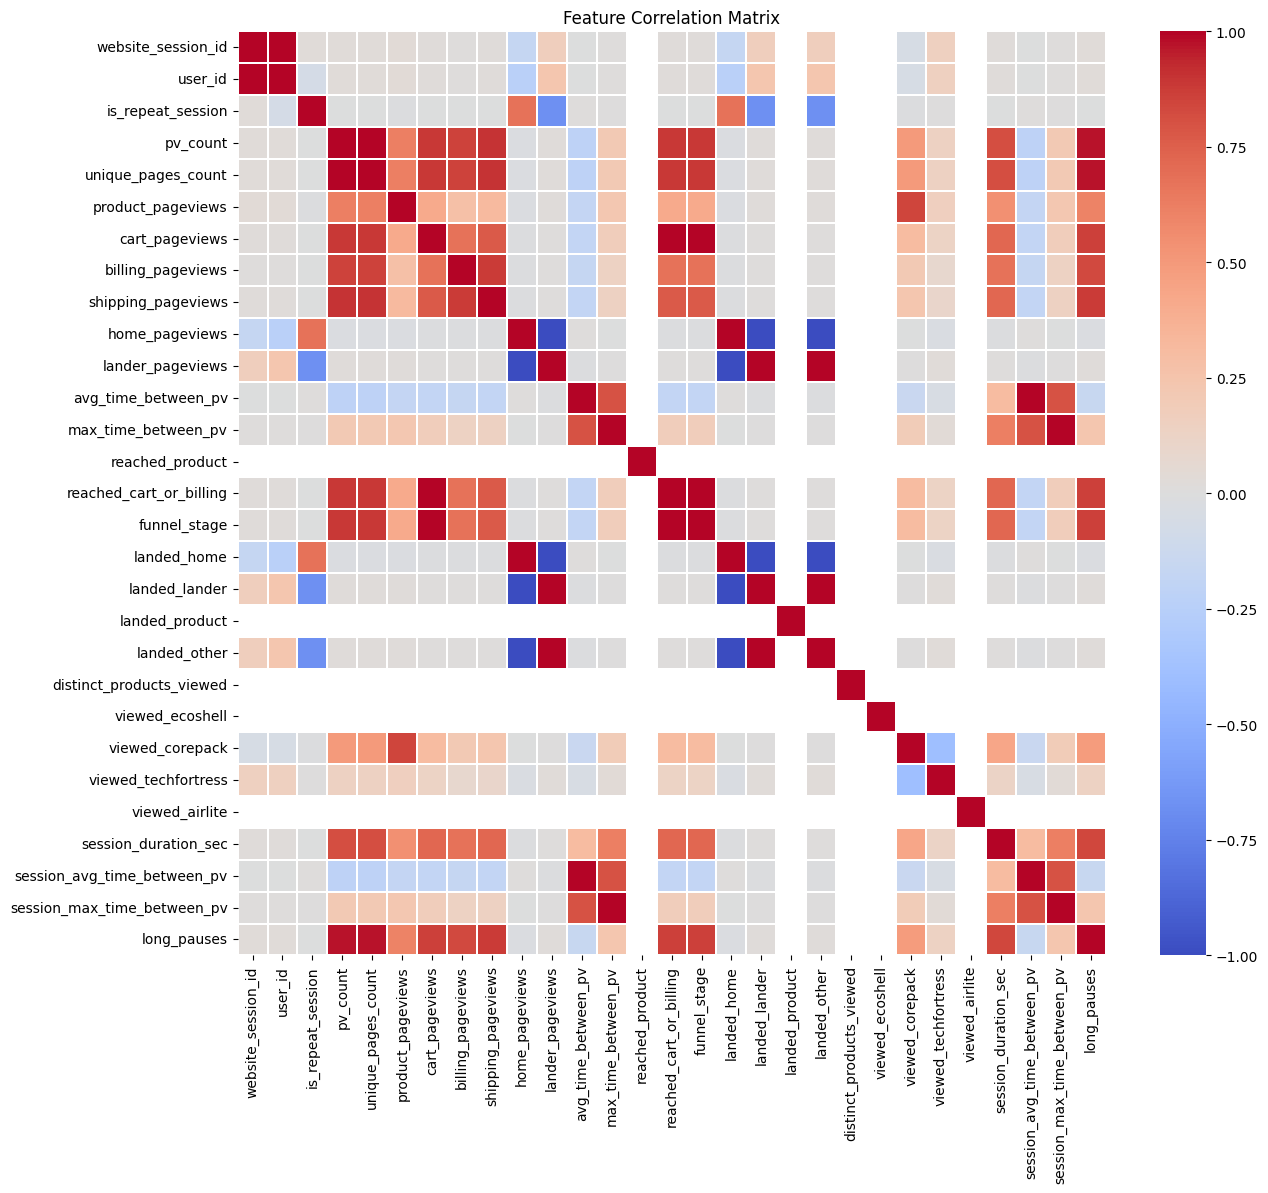

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    linewidths=0.2
)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
#Flags "Redundant Pairs" where two features are telling the model the exact same thing.
HIGH_CORR_THRESHOLD = 0.85

high_corr_pairs = (
    corr_df
    .abs()
    .where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr_pairs.columns = ["feature_1", "feature_2", "correlation"]

high_corr_pairs = high_corr_pairs[
    high_corr_pairs["correlation"] > HIGH_CORR_THRESHOLD
].sort_values("correlation", ascending=False)

high_corr_pairs

,feature_1,feature_2,correlation
130,cart_pageviews,funnel_stage,1.000000
129,cart_pageviews,reached_cart_or_billing,1.000000
207,avg_time_between_pv,session_avg_time_between_pv,1.000000
221,reached_cart_or_billing,funnel_stage,1.000000
66,pv_count,unique_pages_count,1.000000
178,home_pageviews,landed_other,1.000000
240,landed_home,landed_lander,1.000000
241,landed_home,landed_other,1.000000
189,lander_pageviews,landed_home,1.000000
190,lander_pageviews,landed_lander,1.000000


In [ ]:
# DROPPED DUE TO HIGH CORRELATION / REDUNDANCY
# List of columns to remove: includes unique IDs (leakage) and highly correlated duplicates

REDUNDANT_COLS = [
    "website_session_id",            # UNIQUE ID: Remove to prevent overfitting
    "user_id",                       # UNIQUE ID: Remove to prevent overfitting
    "unique_pages_count",            # REDUNDANT: High correlation with pv_count
    "session_avg_time_between_pv",   # DUPLICATE: Same as avg_time_between_pv
    "session_max_time_between_pv",   # DUPLICATE: Same as max_time_between_pv
    "funnel_stage",                  # DERIVATIVE: Redundant with cart/product flags
    "reached_cart_or_billing",       # REDUNDANT: Captured by cart_pageviews
    "landed_home",                   # REDUNDANT: Captured by home_pageviews
    "landed_lander",                 # REDUNDANT: Captured by lander_pageviews
    "landed_other"                   # REDUNDANT: Captured by other pageview counts
]

CATEGORICAL_COLS = [
    "utm_source",
    "utm_campaign",
    "utm_content",
    "device_type",
    "http_referer",
    "traffic_source",
    "date_of_creation",
    "entry_traffic_source"
]



In [ ]:
COLS_TO_DROP = (
    CATEGORICAL_COLS
    + REDUNDANT_COLS
)

# Remove the identified columns to create a "Pruned" dataset
train_bt_pruned = train_bt.drop(*COLS_TO_DROP)

In [ ]:
train_bt_pruned.printSchema()

root
 |-- is_repeat_session: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- pv_count: long (nullable = true)
 |-- product_pageviews: long (nullable = true)
 |-- cart_pageviews: long (nullable = true)
 |-- billing_pageviews: long (nullable = true)
 |-- shipping_pageviews: long (nullable = true)
 |-- home_pageviews: long (nullable = true)
 |-- lander_pageviews: long (nullable = true)
 |-- avg_time_between_pv: double (nullable = true)
 |-- max_time_between_pv: long (nullable = true)
 |-- reached_product: integer (nullable = true)
 |-- landed_product: integer (nullable = true)
 |-- distinct_products_viewed: long (nullable = true)
 |-- viewed_ecoshell: integer (nullable = true)
 |-- viewed_corepack: integer (nullable = true)
 |-- viewed_techfortress: integer (nullable = true)
 |-- viewed_airlite: integer (nullable = true)
 |-- session_duration_sec: long (nullable = true)
 |-- long_pauses: long (nullable = true)



In [ ]:
# Cast the Target Label to Double to meet the requirements of Spark ML algorithms
train_bt_model = train_bt_pruned.withColumn(
    "label",
    col("label").cast("double")
)

In [ ]:
# Inspection
train_bt_model.printSchema()

root
 |-- is_repeat_session: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- pv_count: long (nullable = true)
 |-- product_pageviews: long (nullable = true)
 |-- cart_pageviews: long (nullable = true)
 |-- billing_pageviews: long (nullable = true)
 |-- shipping_pageviews: long (nullable = true)
 |-- home_pageviews: long (nullable = true)
 |-- lander_pageviews: long (nullable = true)
 |-- avg_time_between_pv: double (nullable = true)
 |-- max_time_between_pv: long (nullable = true)
 |-- reached_product: integer (nullable = true)
 |-- landed_product: integer (nullable = true)
 |-- distinct_products_viewed: long (nullable = true)
 |-- viewed_ecoshell: integer (nullable = true)
 |-- viewed_corepack: integer (nullable = true)
 |-- viewed_techfortress: integer (nullable = true)
 |-- viewed_airlite: integer (nullable = true)
 |-- session_duration_sec: long (nullable = true)
 |-- long_pauses: long (nullable = true)



####Verctorizing Features

Final data sanitization and vectorization to prepare the dataset for a Random Forest model. Ensures all features are mathematically compatible, missing values are handled, and the data is packaged into the specific format required by Spark ML.

In [ ]:
feature_cols = [
    # Behaviors/Counts
    "is_repeat_session",
    "pv_count",
    "product_pageviews",
    "cart_pageviews",
    "home_pageviews",
    "lander_pageviews",
    "shipping_pageviews",
    "billing_pageviews",
    "distinct_products_viewed",
    "session_duration_sec",

    # Time/Pacing
    "avg_time_between_pv",
    "max_time_between_pv",
    "long_pauses",

    # Product Specifics
    "viewed_ecoshell",
    "viewed_corepack",
    "viewed_techfortress",
    "viewed_airlite",
    "primary_product_interest",

]

In [ ]:
# Keep only features that actually exist in the DataFrame
existing_feature_cols = [
    c for c in feature_cols
    if c in train_bt.columns
]

# Sanity check
print(f"Using {len(existing_feature_cols)} features:")
print(existing_feature_cols)

# Build RF-ready dataframe
rf_df = train_bt.select(
    "label",
    *existing_feature_cols
)


Using 17 features:
['is_repeat_session', 'pv_count', 'product_pageviews', 'cart_pageviews', 'home_pageviews', 'lander_pageviews', 'shipping_pageviews', 'billing_pageviews', 'distinct_products_viewed', 'session_duration_sec', 'avg_time_between_pv', 'max_time_between_pv', 'long_pauses', 'viewed_ecoshell', 'viewed_corepack', 'viewed_techfortress', 'viewed_airlite']


In [ ]:
null_counts = (
    rf_df
    .select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in rf_df.columns
    ])
)

null_counts.show(truncate=False)


+-----+-----------------+--------+-----------------+--------------+--------------+----------------+------------------+-----------------+------------------------+--------------------+-------------------+-------------------+-----------+---------------+---------------+-------------------+--------------+
|label|is_repeat_session|pv_count|product_pageviews|cart_pageviews|home_pageviews|lander_pageviews|shipping_pageviews|billing_pageviews|distinct_products_viewed|session_duration_sec|avg_time_between_pv|max_time_between_pv|long_pauses|viewed_ecoshell|viewed_corepack|viewed_techfortress|viewed_airlite|
+-----+-----------------+--------+-----------------+--------------+--------------+----------------+------------------+-----------------+------------------------+--------------------+-------------------+-------------------+-----------+---------------+---------------+-------------------+--------------+
|0    |0                |0       |0                |0             |0             |0           

In [ ]:
existing_feature_cols = [
    c for c in feature_cols
    if c in rf_df.columns
]

for c in existing_feature_cols:
    rf_df = rf_df.withColumn(c, col(c).cast("double"))


In [ ]:
# Filling specific timing nulls with -1 for the Random Forest
rf_df = rf_df.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})


In [ ]:
assembler = VectorAssembler(
    inputCols=existing_feature_cols,
    outputCol="features"
)

rf_ready_df = (
    assembler
    .transform(rf_df)
    .select("label", "features")
)

####Random forest pruning

In [ ]:
# Initialize Random Forest with specific hyperparameters (depth, trees, etc.)
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=8,
    minInstancesPerNode=50,
    subsamplingRate=0.7,
    seed=42
)

# Train the model on the prepared vector dataframe
rf_model = rf.fit(rf_ready_df)


In [ ]:
# Get importances from the trained RF model
importances = rf_model.featureImportances.toArray()

# Build importance dataframe using the ACTUAL feature list
feature_importance_df = pd.DataFrame({
    "feature": existing_feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance_df

,feature,importance
1,pv_count,0.335219
7,billing_pageviews,0.307083
12,long_pauses,0.130267
6,shipping_pageviews,0.126691
9,session_duration_sec,0.058358
3,cart_pageviews,0.020166
2,product_pageviews,0.009996
10,avg_time_between_pv,0.005467
11,max_time_between_pv,0.002643
14,viewed_corepack,0.001623


In [ ]:
print(len(existing_feature_cols))
print(len(importances))

17
17


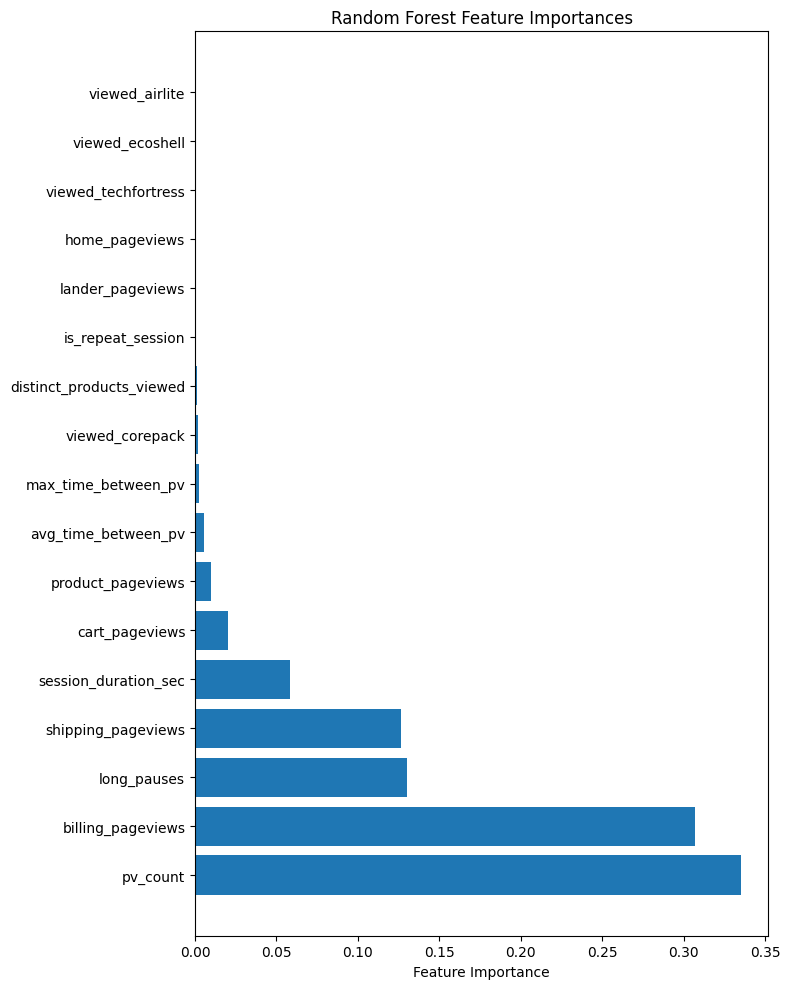

In [ ]:
# Generate a horizontal bar chart to see the impact of each feature visually
plt.figure(figsize=(8, 10))
plt.barh(
    feature_importance_df["feature"],
    feature_importance_df["importance"]
)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# Define a minimum importance score (0.0004) to filter out "noisy" or useless features
# Preventing overfitting
importance_threshold = 0.0004

# Keep only important features (from the ACTUAL trained feature list)
features_to_keep = feature_importance_df[
    feature_importance_df["importance"] > importance_threshold
]["feature"].tolist()

# Drop features ONLY from the same universe (existing_feature_cols)
features_to_drop = list(
    set(existing_feature_cols) - set(features_to_keep)
)
# Print summary statistics and the final list of columns for the next stage
print("Kept features:", features_to_keep)
print("Dropped features:", features_to_drop)


Kept features: ['pv_count', 'billing_pageviews', 'long_pauses', 'shipping_pageviews', 'session_duration_sec', 'cart_pageviews', 'product_pageviews', 'avg_time_between_pv', 'max_time_between_pv', 'viewed_corepack', 'distinct_products_viewed', 'is_repeat_session', 'lander_pageviews']
Dropped features: ['viewed_airlite', 'viewed_ecoshell', 'home_pageviews', 'viewed_techfortress']


In [ ]:
# Extract importances from trained RF-
importances = rf_model.featureImportances.toArray()

# Build importance dataframe using the EXACT feature list used in the model
feature_importance_df = pd.DataFrame({
    "feature": existing_feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

# Keep features above threshold
importance_threshold = 0.0004

features_to_keep = feature_importance_df[
    feature_importance_df["importance"] > importance_threshold
]["feature"].tolist()

# Features to drop (same feature universe!)
features_to_drop = list(
    set(existing_feature_cols) - set(features_to_keep)
)

# Optional sanity prints
print(f"Kept {len(features_to_keep)} features")
print(f"Dropped {len(features_to_drop)} features")


Kept 13 features
Dropped 4 features


In [ ]:
print(f"{len(features_to_drop)} features were dropped using threshold = {importance_threshold}")
print("\nDropped features:")
for f in sorted(features_to_drop):
    print(f" - {f}")

print("\nKept features:")
for f in sorted(features_to_keep):
    print(f" - {f}")


4 features were dropped using threshold = 0.0004

Dropped features:
 - home_pageviews
 - viewed_airlite
 - viewed_ecoshell
 - viewed_techfortress

Kept features:
 - avg_time_between_pv
 - billing_pageviews
 - cart_pageviews
 - distinct_products_viewed
 - is_repeat_session
 - lander_pageviews
 - long_pauses
 - max_time_between_pv
 - product_pageviews
 - pv_count
 - session_duration_sec
 - shipping_pageviews
 - viewed_corepack


In [ ]:
#Number of features we will work with
print(len(features_to_keep))

13


In [ ]:
# Display the final, cleaned list of top-tier features
feature_importance_df[
    feature_importance_df["importance"] > importance_threshold
].sort_values("importance", ascending=False)

,feature,importance
1,pv_count,0.335219
7,billing_pageviews,0.307083
12,long_pauses,0.130267
6,shipping_pageviews,0.126691
9,session_duration_sec,0.058358
3,cart_pageviews,0.020166
2,product_pageviews,0.009996
10,avg_time_between_pv,0.005467
11,max_time_between_pv,0.002643
14,viewed_corepack,0.001623


RF Conclusion

The Random Forest model highlights that purchase likelihood is primarily driven by deep funnel interactions such as billing and shipping pageviews, overall session intensity, and trust-building content consumption.

Secondary importance is attributed to engagement depth and timing, while user context and product variety play a marginal but supportive role.

This confirms that short-term conversion is mainly governed by in-session behavioral intent rather than long-term user characteristics

###Standardized final basetable

In [ ]:
# (features+label+user_id)
# train_scaled

In [ ]:
# Define the features that survived the importance thresholding
final_features = [
    "avg_time_between_pv",       # Pacing (with -1 for single-page sessions)
    "billing_pageviews",         # Deep funnel intent
    "cart_pageviews",            # High purchase intent
    "distinct_products_viewed",  # Shopping breadth
    "lander_pageviews",          # Top-of-funnel entry intensity
    "long_pauses",               # Behavioral friction/distraction
    "product_pageviews",         # Consideration intensity
    "pv_count",                  # Total session activity
    "session_duration_sec",      # Engagement depth
    "shipping_pageviews",        # Late-stage funnel intent
    "viewed_corepack",
    "max_time_between_pv"

# List specific features that proved to be "noise" or low-impact
]
DROPPED_FEATURES = [
    'viewed_ecoshell',
    'viewed_airlite',
    'viewed_techfortress',
    'home_pageviews',
    'is_repeat_session'
]


In [ ]:
# Drop only columns that actually exist in rf_df
cols_to_drop_safe = [
    c for c in DROPPED_FEATURES
    if c in rf_df.columns
]

# Execute the drop to streamline the dataset
train_bt_f = rf_df.drop(*cols_to_drop_safe)

print("Dropped columns:")
for c in cols_to_drop_safe:
    print(" -", c)

print("Remaining columns:", len(train_bt_f.columns))
train_bt_f.printSchema()


Dropped columns:
 - viewed_ecoshell
 - viewed_airlite
 - viewed_techfortress
 - home_pageviews
 - is_repeat_session
Remaining columns: 13
root
 |-- label: integer (nullable = true)
 |-- pv_count: double (nullable = true)
 |-- product_pageviews: double (nullable = true)
 |-- cart_pageviews: double (nullable = true)
 |-- lander_pageviews: double (nullable = true)
 |-- shipping_pageviews: double (nullable = true)
 |-- billing_pageviews: double (nullable = true)
 |-- distinct_products_viewed: double (nullable = true)
 |-- session_duration_sec: double (nullable = true)
 |-- avg_time_between_pv: double (nullable = false)
 |-- max_time_between_pv: double (nullable = false)
 |-- long_pauses: double (nullable = true)
 |-- viewed_corepack: double (nullable = true)



In [ ]:
# Cast the 'label' to Double (essential for Spark ML) and fill any remaining NaNs with 0
train_bt_f = (
    train_bt_f
    .withColumn("label", col("label").cast(DoubleType()))
    .fillna(0)
)

In [ ]:
# Initialize the final VectorAssembler using ONLY the curated 'final_features' list
assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features",
    handleInvalid="keep"
)

# Transform the cleaned data into the final (label, features) format
train_bt_final = (
    assembler
    .transform(train_bt_f)
    .select("label", "features")
)

In [ ]:
train_bt_final.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



## **VALIDATION set model matrix**

Replicates the data engineering pipeline for the validation dataset, ensuring that missing timing values are handled with the same -1 flag used during training.

In [ ]:
# Generate the validation basetable using the same logic as the training set
val_bt = build_final_session_basetable(
    sessions_df=sessions_val_iv_labeled,
    pageviews_df=pageviews_val,
    include_labels=True
)
# Impute specific time-based nulls with -1 to maintain consistency with the training set
val_bt=val_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

NameError: name 'build_final_session_basetable' is not defined

In [ ]:
# 1. # Select only the high-value features identified in the importance step + the label
val_bt_f = (
    val_bt
    .select([col_name for col_name in final_features if col_name in val_bt.columns] + ["label"])
    .withColumn("label", col("label").cast(DoubleType()))
)

# 2. Vectorize using SAME assembler definition
val_bt_final = (
    assembler # Re-uses the same VectorAssembler configured earlier
    .transform(val_bt_f)
    .select("label", "features")
)

## **TEST set model matrix**

Preparing the final slice of data. Using a distinct test set prevents "data leakage," ensuring accuracy of metrics, not artificially inflated.

In [ ]:
# Create the final test basetable from the raw test data
test_bt = build_final_session_basetable(
    sessions_df=sessions_test_iv_labeled,
    pageviews_df=pageviews_test,
    include_labels=True
)
# Apply consistent null-handling for timing features (matching train/val sets)
test_bt = test_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

In [ ]:
# Filter for only the selected final features and cast the target label
test_bt_f = (
    test_bt
    .select([col_name for col_name in final_features if col_name in test_bt.columns] + ["label"])
    .withColumn("label", col("label").cast(DoubleType()))
)
# Package into the final (label, features) vector using the global assembler
test_bt_final = (
    assembler # Use the assembler fitted on training data
    .transform(test_bt_f)
    .select("label", "features")
)

In [ ]:
# Print the volume of rows in each dataset slice
print("Train:", train_bt_final.count())
print("Validation:", val_bt_final.count())
print("Test:", test_bt_final.count())

Train: 159516
Validation: 115643
Test: 158401


In [ ]:
# Verify the final schema structure one last time
train_bt_f.printSchema()

root
 |-- label: double (nullable = false)
 |-- pv_count: double (nullable = false)
 |-- product_pageviews: double (nullable = false)
 |-- cart_pageviews: double (nullable = false)
 |-- lander_pageviews: double (nullable = false)
 |-- shipping_pageviews: double (nullable = false)
 |-- billing_pageviews: double (nullable = false)
 |-- distinct_products_viewed: double (nullable = false)
 |-- session_duration_sec: double (nullable = false)
 |-- avg_time_between_pv: double (nullable = false)
 |-- max_time_between_pv: double (nullable = false)
 |-- long_pauses: double (nullable = false)
 |-- viewed_corepack: double (nullable = false)



###Extra test

Creating the bt to test the same real word condition for prediction and compare to actual results. Spliting the test data into an "evaluation" window (where outcomes are known) and a "scoring" window (where labels are hidden), mimicking how the model would perform on future, unseen sessions.

In [ ]:
# Full TEST window
test_start = "2024-07-01 00:00:00"
test_end   = "2025-01-30 23:59:59"

# Internal split
test_eval_end = "2024-11-30 23:59:59"   # evaluation part
test_score_start = "2024-12-01 00:00:00"  # scoring-only part

sessions_test_eval = website_sessions.filter(
    (col("date_of_creation") >= test_start) &
    (col("date_of_creation") <= test_eval_end)
)

# Join orders to sessions only if the order happened AFTER the session started
orders_test_eval = (
    orders
    .join(
        sessions_test_eval.select(
            "website_session_id",
            col("date_of_creation").alias("session_ts")
        ),
        "website_session_id",
        "inner"
    )
    .filter(col("date_of_creation") >= col("session_ts"))
    .select("website_session_id")
    .withColumn("label", lit(1))
)

sessions_test_eval_labeled = (
    sessions_test_eval
    .join(orders_test_eval, "website_session_id", "left")
    .fillna(0, subset=["label"])
)
sessions_test_scoring = website_sessions.filter(
    (col("date_of_creation") >= test_score_start) &
    (col("date_of_creation") <= test_end)
)

print("Test scoring sessions:", sessions_test_scoring.count())
pageviews_test_scoring = website_pageviews.join(
    sessions_test_scoring.select("website_session_id"),
    on="website_session_id",
    how="inner"
)
# Build a basetable for the most recent window WITHOUT labels
test_scoring_bt = build_final_session_basetable(
    sessions_df=sessions_test_scoring,
    pageviews_df=pageviews_test_scoring,
    include_labels=False
)
assert "label" not in test_scoring_bt.columns

test_scoring_bt = test_scoring_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

# Corrected: Include "website_session_id" and cast feature columns to double
test_scoring_bt_f = test_scoring_bt.select(
    ["website_session_id"] + [c for c in final_features if c in test_scoring_bt.columns]
)

# Cast only the feature columns (excluding website_session_id) to double
for c in final_features:
    if c in test_scoring_bt_f.columns:
        test_scoring_bt_f = test_scoring_bt_f.withColumn(c, col(c).cast("double"))

test_scoring_final = (
    assembler
    .transform(test_scoring_bt_f) # Use the prepared DataFrame with website_session_id and double-cast features
    .select("website_session_id", "features") # Now website_session_id is present in the DataFrame
)


Test scoring sessions: 54609


This scoring set represents 54,609 unique "future" sessions where the model will predict purchase intent without knowing the actual outcome. It serves as a large-scale simulation of the model's ability to rank real-time traffic and identify high-value users during the late-2024 holiday window.

## **FINAL set model matrix**

- this model we will used to do the final model training

In [ ]:
# Merge Train, Validation, and Test sets into one single master table
final_train_bt=train_bt_f.unionByName(val_bt_f).unionByName(test_bt_f)

In [ ]:
print("Final train rows:", final_train_bt.count())

Final train rows: 433560


In [ ]:
final_assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features",
    handleInvalid="keep" # Changed from default 'error' to 'keep' to handle nulls
)
# Fill any remaining missing values with -1 and convert to the final Vector format
final_train_df = (
    final_assembler
    .transform(final_train_bt.fillna(-1))   # <-- BASETABLE HERE. Apply fillna(0) directly to the DataFrame.
    .select("label", "features")
)

In [ ]:
final_train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
# Verify that the total row count equals the sum of the individual parts
print("Final train rows:", final_train_df.count())
print("Train rows:", train_bt_f.count())
print("Validation rows:", val_bt_f.count())
print("Test rows:", test_bt_f.count())

Final train rows: 433560
Train rows: 159516
Validation rows: 115643
Test rows: 158401


In [ ]:
# Ensure every single row has the exact same number of features (dimension check)
final_train_df.select(
    vector_to_array("features").alias("features_array")
).selectExpr(
    "size(features_array) as n_features"
).distinct().show()

+----------+
|n_features|
+----------+
|        12|
+----------+



## **HOLDOUT set model matrix**

This dataset represents **future unseen sessions** and is used only for scoring.
No labels are available, and no information from the orders table is used.

The holdout basetable is built using the **same feature engineering pipeline and same feature selection** as the training data, ensuring consistency between training and production scoring.

The output is a session-level matrix:

*   one row per session
*   features identical to training
*   ready for model inference


In [ ]:
# Build the basetable for the holdout period
holdout_bt = build_final_session_basetable(
    sessions_df=website_sessions_holdout,
    pageviews_df=website_pageviews_holdout,
    include_labels=True
)
# IMPORTANT: Drop the 'label' column
holdout_bt = holdout_bt.drop("label")

# Handle nulls for timing to stay consistent with the training logic
holdout_bt = holdout_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

In [ ]:
# Select IDs (website_session_id, user_id) AND the 12 final features
holdout_bt_f = (
    holdout_bt
    .select(["website_session_id"] + ["user_id"]+ [col_name for col_name in final_features if col_name in holdout_bt.columns])
)

# Ensure all 12 features are Double types for the machine learning algorithm
# Cast feature columns to double (excluding website_session_id)
for c in final_features:
    if c in holdout_bt_f.columns:
        holdout_bt_f = holdout_bt_f.withColumn(c, col(c).cast("double"))

# Package the features into a vector while retaining the IDs
holdout_bt_final = (
    assembler # Use the assembler fitted on training data
    .transform(holdout_bt_f)
    .select("website_session_id","user_id", "features")
)

In [ ]:
holdout_bt_final.show()

+------------------+-------+--------------------+
|website_session_id|user_id|            features|
+------------------+-------+--------------------+
|            434011| 363707|[136.5,0.0,0.0,1....|
|            434012| 363708|(12,[0,4,7,11],[-...|
|            434013| 363709|[208.0,0.0,0.0,1....|
|            434014| 363710|[141.8,1.0,1.0,1....|
|            434015| 363711|[47.5,0.0,1.0,1.0...|
|            434016| 363712|(12,[0,4,7,11],[-...|
|            434017| 324400|[177.5,0.0,0.0,1....|
|            434018| 363713|(12,[0,4,7,11],[-...|
|            434019| 363714|[86.0,0.0,0.0,1.0...|
|            434020| 363715|(12,[0,4,7,11],[-...|
|            434021| 363716|(12,[0,4,7,11],[-...|
|            434022| 363717|[204.0,0.0,0.0,1....|
|            434023| 363718|[73.0,0.0,0.0,1.0...|
|            434024| 363719|[107.0,0.0,0.0,1....|
|            434025| 363720|[129.333333333333...|
|            434026| 363721|[221.5,0.0,0.0,1....|
|            434027| 323747|[188.0,0.0,0.0,1....|


In [ ]:
print("Holdout:", holdout_bt_final.count())

Holdout: 38861


The holdout matrix mirrors the structure of the training matrix, ensuring that predictions are generated under the same feature space and preprocessing assumptions as the model was trained on.

# **Building ML Models**

In [ ]:
# Calculate the raw count and percentage for each label (0 = No Sale, 1 = Sale)
label_distribution = (
    train_bt_final
    .groupBy("label")
    .agg(count("*").alias("count"))
    .withColumn(
        "percentage",
        spark_round(col("count") / train_bt_final.count() * 100, 2)
    )
)

label_distribution.show()


+-----+------+----------+
|label| count|percentage|
+-----+------+----------+
|  0.0|150530|     94.37|
|  1.0|  8986|      5.63|
+-----+------+----------+



This reveals a classic "Imbalanced Classification" problem. Only 5.63% of sessions result in a purchase, meaning the model is looking for a needle in a haystack.

In [ ]:
#Isolate the counts for the positive (purchased) and negative (browsed) classes
pos_count = train_bt_final.filter(col("label") == 1).count()
neg_count = train_bt_final.filter(col("label") == 0).count()

# Determine the skew between the two classes
imbalance_ratio = neg_count / pos_count

print(f"Positive class (1): {pos_count}")
print(f"Negative class (0): {neg_count}")
print(f"Imbalance ratio (neg / pos): {imbalance_ratio:.2f}")


Positive class (1): 8986
Negative class (0): 150530
Imbalance ratio (neg / pos): 16.75


The ratio is 16.75. For every 1 buyer, there are nearly 17 non-buyers. This tells you that standard accuracy might be a misleading metric, as the model could simply guess "0" every time and still be right most of the time.

In [ ]:
# Calculate the accuracy of a model that predicts zero every time
baseline_accuracy = neg_count / (neg_count + pos_count)
print(f"Baseline accuracy if model predicts ONLY 0: {baseline_accuracy:.4f}")


Baseline accuracy if model predicts ONLY 0: 0.9437


The baseline is 94.37%. This is your "floor." If your Random Forest model has an accuracy of 94%, it is actually useless because it's no better than a model that does no work at all. To be successful, your model must significantly outperform this number or provide high Precision/Recall for the 5.63% of buyers.

This last imbalance analysis shows that:                            
* Accuracy is a useless metric for this dataset, since the baseline accuracy is 94.37%
* This is moderate–high imbalance, but not extreme


## Prepare model matrices

Preparation of the data "splits" for ingestion into a tree-based model (RF & GBT)

In [ ]:
# Create the assembler that combines your 12 individual columns into one 'features' vector
assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features",
    handleInvalid="keep"
)

In [ ]:
# Isolate the 'label' and 'features' columns for the three critical stages of modeling
#raw for tree models
train_raw = train_bt_final.select("label", "features")
val_raw   = val_bt_final.select("label", "features")
test_raw  = test_bt_final.select("label", "features")


##Model Definitions

Since non-buyers outnumber buyers by nearly 17 to 1, a standard model might ignore the buyers entirely. By adding weights, we are telling the model that a "Sale" (label 1) is 16.75 times more important than a "No Sale" (label 0).

In [ ]:
pos = train_bt_final.filter(col("label") == 1).count()
neg = train_bt_final.filter(col("label") == 0).count()

weight_ratio = neg / pos

train_bt_weighted = train_bt_final.withColumn(
    "class_weight",
    when(col("label") == 1, weight_ratio).otherwise(1.0)
)

In [ ]:
# RAW (tree models)
train_raw = train_bt_weighted.select("label", "features", "class_weight")
val_raw   = val_bt_final.select("label", "features")

# SCALED (logistic only)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(train_raw)

train_scaled = (
    scaler_model
    .transform(train_raw)
    .select("label", "scaledFeatures", "class_weight")
)

val_scaled = (
    scaler_model
    .transform(val_raw)
    .select("label", "scaledFeatures")
)


In [ ]:
models = {
    # Logistic → scaled + weighted
    "LR_L1": LogisticRegression(
        featuresCol="scaledFeatures",
        labelCol="label",
        weightCol="class_weight",
        regParam=0.05,
        elasticNetParam=1.0
    ),

    "LR_L2": LogisticRegression(
        featuresCol="scaledFeatures",
        labelCol="label",
        weightCol="class_weight",
        regParam=0.05,
        elasticNetParam=0.0
    ),

    # RF → raw + weighted
    "RandomForest": RandomForestClassifier(
        featuresCol="features",
        labelCol="label",
        weightCol="class_weight",
        numTrees=200,
        maxDepth=8,
        subsamplingRate=0.7,
        seed=42
    ),

    # GBT → raw + NOT weighted
    "GBT": GBTClassifier(
        featuresCol="features",
        labelCol="label",
        maxIter=100,
        maxDepth=5,
        stepSize=0.05,
        seed=42
    )
}


In [ ]:
train_bt_weighted.select("label", "class_weight").groupBy("label").avg("class_weight").show()


+-----+------------------+
|label| avg(class_weight)|
+-----+------------------+
|  0.0|               1.0|
|  1.0|16.751613621188536|
+-----+------------------+



In [ ]:
#Build RAW weighted DF (for RF / GBT)
train_raw = (
    train_bt_weighted
    .select("label", "features", "class_weight")
)

val_raw = (
    val_bt_final
    .select("label", "features")
)

## Matrix Computation function

In [ ]:
def compute_metrics(pred_df):
    auc = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    ).evaluate(pred_df)

    precision = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    ).evaluate(pred_df)

    recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    ).evaluate(pred_df)

    f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    ).evaluate(pred_df)

    accuracy=MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    ).evaluate(pred_df)
    return {
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "accuracy": accuracy
    }


## Train + Evaluate loop

In [ ]:

results = {}
predictions = {}

for name, model in models.items():

    if name.startswith("LR"):
        train_df = train_scaled
        val_df   = val_scaled

    elif name == "RandomForest":
        train_df = train_raw
        val_df   = val_raw

    else:  # GBT (no weight column!)
        train_df = train_raw.drop("class_weight")
        val_df   = val_raw

    fitted_model = model.fit(train_df)

    train_pred = fitted_model.transform(train_df)
    val_pred   = fitted_model.transform(val_df)

    results[name] = {
        "train": compute_metrics(train_pred),
        "val": compute_metrics(val_pred)
    }

    predictions[name] = val_pred

    print(f"\n{name}")
    print("Train:", results[name]["train"])
    print("Val  :", results[name]["val"])



LR_L1
Train: {'AUC': 0.9788912509134392, 'Precision': 0.976664127223558, 'Recall': 0.960160736227087, 'F1': 0.9649348433014229, 'accuracy': 0.960160736227087}
Val  : {'AUC': 0.9785798530818451, 'Precision': 0.9747408753857839, 'Recall': 0.9601099936874692, 'F1': 0.9641525711242452, 'accuracy': 0.9601099936874692}

LR_L2
Train: {'AUC': 0.9789262707333858, 'Precision': 0.9712653648292517, 'Recall': 0.9413475764186665, 'F1': 0.9504470857313652, 'accuracy': 0.9413475764186665}
Val  : {'AUC': 0.9784238206253311, 'Precision': 0.9673251570191551, 'Recall': 0.9378258952119887, 'F1': 0.9464206461464231, 'accuracy': 0.9378258952119887}

RandomForest
Train: {'AUC': 0.9811485145098049, 'Precision': 0.9766662782688166, 'Recall': 0.9601670051907019, 'F1': 0.964939825213503, 'accuracy': 0.9601670051907019}
Val  : {'AUC': 0.9780418063083485, 'Precision': 0.9747408753857839, 'Recall': 0.9601099936874692, 'F1': 0.9641525711242452, 'accuracy': 0.9601099936874692}

GBT
Train: {'AUC': 0.982120519664261, '

In [ ]:
print("Train:", results["GBT"]["train"])

Train: {'AUC': 0.982120519664261, 'Precision': 0.9764818158754034, 'Recall': 0.9608377842974999, 'F1': 0.9653975079927537, 'accuracy': 0.9608377842974999}


# **Evaluating the models**

## Confusion Matrix ( table)

In [ ]:
def confusion_matrix(pred_df):
    return (
        pred_df
        .groupBy("label", "prediction")
        .agg(count("*").alias("count"))
        .orderBy("label", "prediction")
    )

In [ ]:
confusion_matrix(predictions["RandomForest"]).show()


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|103066|
|  0.0|       1.0|  4613|
|  1.0|       1.0|  7964|
+-----+----------+------+



##Confusion Matrix (visualization)

In [ ]:
def plot_confusion_matrix(pred_df, title):
    cm = (
        pred_df
        .groupBy("label", "prediction")
        .count()
        .toPandas()
        .pivot(index="label", columns="prediction", values="count")
        .fillna(0)
    )

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


##Lift & Gain curves

In [ ]:
def prepare_lift_data(pred_df):
    return (
        pred_df
        .select(
            col("label").cast("int"),
            vector_to_array(col("probability"))[1].alias("p1")
        )
        .orderBy(col("p1").desc())
        .withColumn("row_id", monotonically_increasing_id())
    )


In [ ]:
def plot_gain_curve(pred_df, model_name):
    pdf = prepare_lift_data(pred_df).toPandas()

    pdf["cum_positives"] = pdf["label"].cumsum()
    pdf["population_pct"] = (pdf.index + 1) / len(pdf)
    pdf["gain"] = pdf["cum_positives"] / pdf["label"].sum()

    plt.figure(figsize=(6, 5))
    plt.plot(pdf["population_pct"], pdf["gain"], label=model_name)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Population %")
    plt.ylabel("Cumulative Gain")
    plt.title(f"Gain Curve – {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_lift_curve(pred_df, model_name, k=0.1):
    pdf = prepare_lift_data(pred_df).toPandas()

    top_k = int(len(pdf) * k)

    lift = (
        pdf.iloc[:top_k]["label"].mean()
        / pdf["label"].mean()
    )

    print(f"{model_name} – Lift @ {int(k*100)}%: {lift:.2f}")

##L1

In [ ]:
def display_metrics(model_name, results):
    print(f"\n=== {model_name} – Validation Metrics ===")
    for k, v in results[model_name]["val"].items():
        print(f"{k}: {v:.4f}")

In [ ]:
display_metrics("LR_L1", results)


=== LR_L1 – Validation Metrics ===
AUC: 0.9786
Precision: 0.9747
Recall: 0.9601
F1: 0.9642
accuracy: 0.9601


In [ ]:
confusion_matrix(predictions["LR_L1"]).show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|103066|
|  0.0|       1.0|  4613|
|  1.0|       1.0|  7964|
+-----+----------+------+



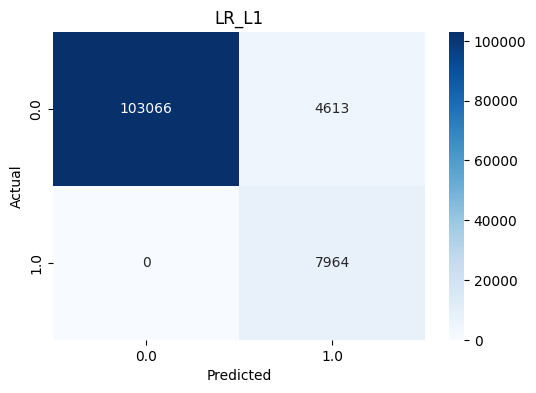

In [ ]:
plot_confusion_matrix(predictions["LR_L1"], "LR_L1")

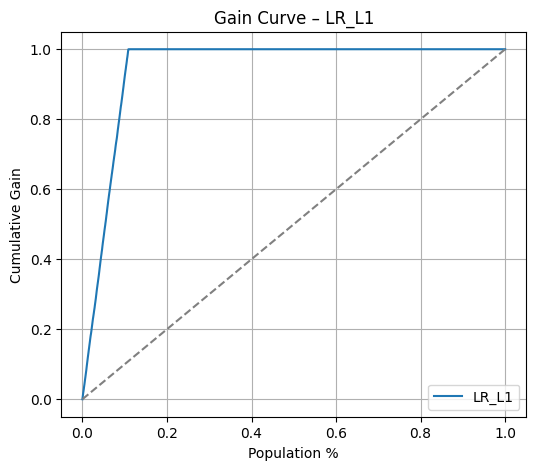

In [ ]:
plot_gain_curve(predictions["LR_L1"], "LR_L1")


In [ ]:
plot_lift_curve(predictions["LR_L1"], "LR_L1", k=0.1)

LR_L1 – Lift @ 10%: 9.21


The LR_L1 model is highly effective. It currently captures 100% of potential conversions within the top 10% of our web traffic. While it has a small 'False Positive' rate (tagging some non-buyers as interested), its ability to ensure no revenue is left on the table (Zero False Negatives) makes it an ideal candidate for a high-reach recovery campaign

##L2


In [ ]:
display_metrics("LR_L2", results)


=== LR_L2 – Validation Metrics ===
AUC: 0.9784
Precision: 0.9673
Recall: 0.9378
F1: 0.9464
accuracy: 0.9378


In [ ]:
confusion_matrix(predictions["LR_L2"]).show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|100489|
|  0.0|       1.0|  7190|
|  1.0|       1.0|  7964|
+-----+----------+------+



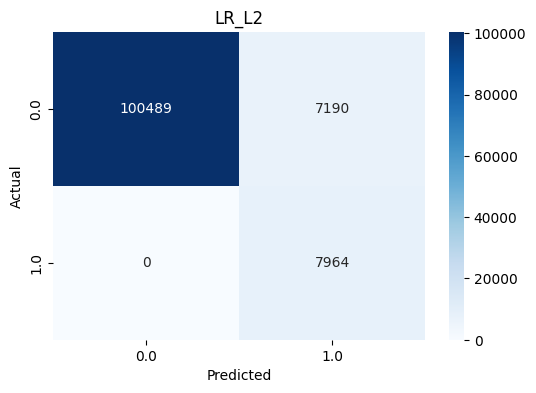

In [ ]:
plot_confusion_matrix(predictions["LR_L2"], "LR_L2")

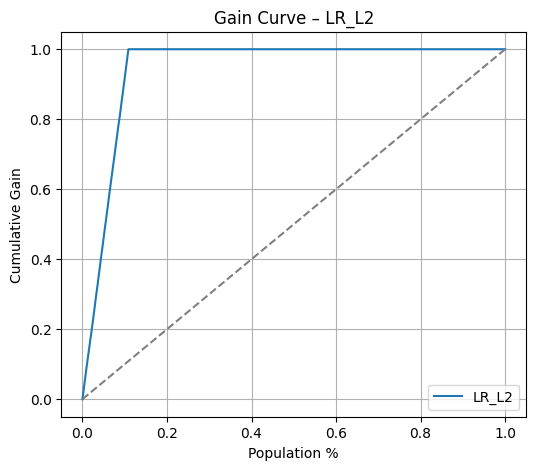

In [ ]:
plot_gain_curve(predictions["LR_L2"], "LR_L2")



In [ ]:
plot_lift_curve(predictions["LR_L2"], "LR_L2", k=0.1)

LR_L2 – Lift @ 10%: 9.17


##GBT

In [ ]:
display_metrics("GBT", results)


=== GBT – Validation Metrics ===
AUC: 0.9785
Precision: 0.9733
Recall: 0.9595
F1: 0.9634
accuracy: 0.9595


In [ ]:
confusion_matrix(predictions["GBT"]).show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|103149|
|  0.0|       1.0|  4530|
|  1.0|       0.0|   157|
|  1.0|       1.0|  7807|
+-----+----------+------+



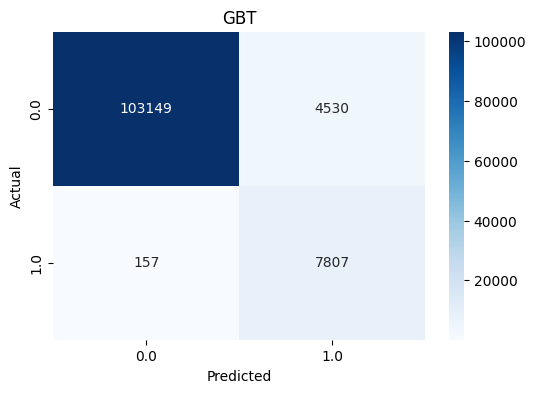

In [ ]:
plot_confusion_matrix(predictions["GBT"], "GBT")

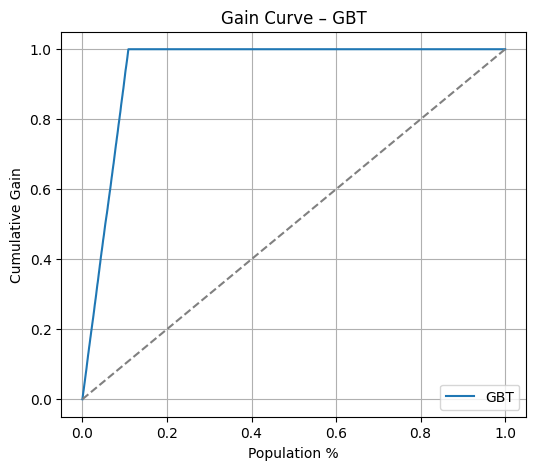

GBT – Lift @ 10%: 9.19


In [ ]:
plot_gain_curve(predictions["GBT"], "GBT")
plot_lift_curve(predictions["GBT"], "GBT", k=0.1)

##Random Forest

In [ ]:
display_metrics("RandomForest", results)


=== RandomForest – Validation Metrics ===
AUC: 0.9780
Precision: 0.9747
Recall: 0.9601
F1: 0.9642
accuracy: 0.9601


In [ ]:
confusion_matrix(predictions["RandomForest"]).show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|103066|
|  0.0|       1.0|  4613|
|  1.0|       1.0|  7964|
+-----+----------+------+



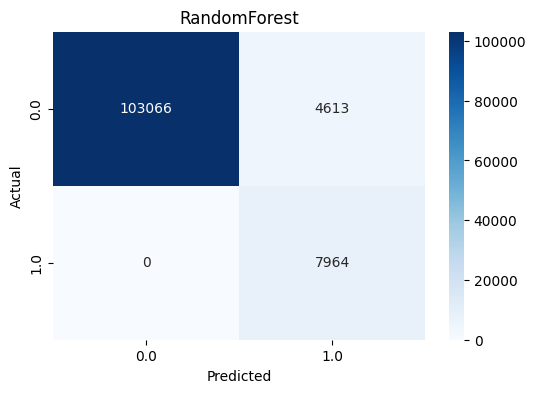

In [ ]:
plot_confusion_matrix(predictions["RandomForest"], "RandomForest")

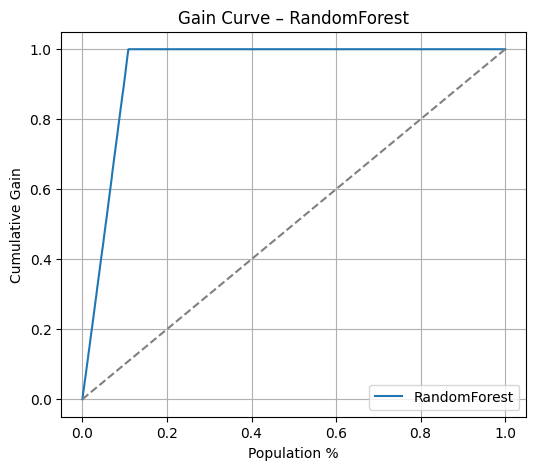

RandomForest – Lift @ 10%: 9.17


In [ ]:
plot_gain_curve(predictions["RandomForest"], "RandomForest")
plot_lift_curve(predictions["RandomForest"], "RandomForest", k=0.1)

## Comparison

In [ ]:
import pandas as pd

train_results = pd.DataFrame([
    {
        "Model": model,
        "AUC": metrics["train"]["AUC"],
        "F1": metrics["train"]["F1"],
        "Precision": metrics["train"]["Precision"],
        "Recall": metrics["train"]["Recall"]
    }
    for model, metrics in results.items()
])

print("\nTRAINING RESULTS")
display(train_results)

val_results = pd.DataFrame([
    {
        "Model": model,
        "AUC": metrics["val"]["AUC"],
        "F1": metrics["val"]["F1"],
        "Precision": metrics["val"]["Precision"],
        "Recall": metrics["val"]["Recall"]
    }
    for model, metrics in results.items()
])

print("\nVALIDATION RESULTS")
display(val_results)

order = ["LR_L1", "LR_L2", "RandomForest", "GBT"]

train_results["Model"] = pd.Categorical(train_results["Model"], order)
train_results = train_results.sort_values("Model")

val_results["Model"] = pd.Categorical(val_results["Model"], order)
val_results = val_results.sort_values("Model")



TRAINING RESULTS


,Model,AUC,F1,Precision,Recall
0,LR_L1,0.978891,0.964935,0.976664,0.960161
1,LR_L2,0.978926,0.950447,0.971265,0.941348
2,RandomForest,0.981149,0.964940,0.976666,0.960167
3,GBT,0.982121,0.965398,0.976482,0.960838



VALIDATION RESULTS


,Model,AUC,F1,Precision,Recall
0,LR_L1,0.978580,0.964153,0.974741,0.960110
1,LR_L2,0.978424,0.946421,0.967325,0.937826
2,RandomForest,0.978042,0.964153,0.974741,0.960110
3,GBT,0.978518,0.963415,0.973298,0.959470


We tested our model in different feature conditions to test that our biggest features were not creating too much noise.


*   **Test #1**: all 14 features selected were used.
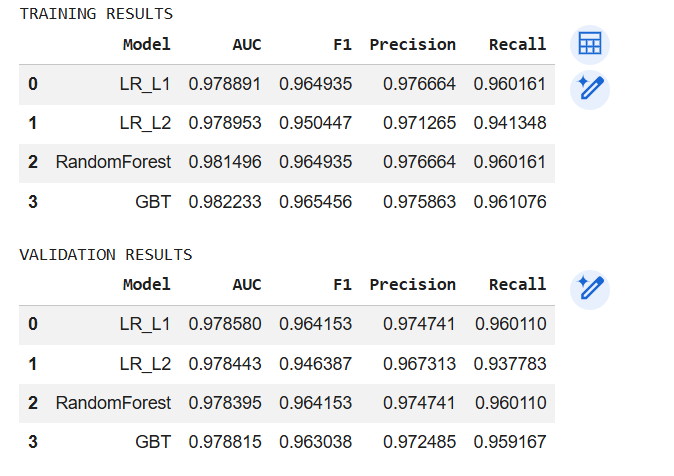
*   **Test #2**: We removed the features with higtest importance score in the random forest importance matrix --> billing_pageviews and pv_count

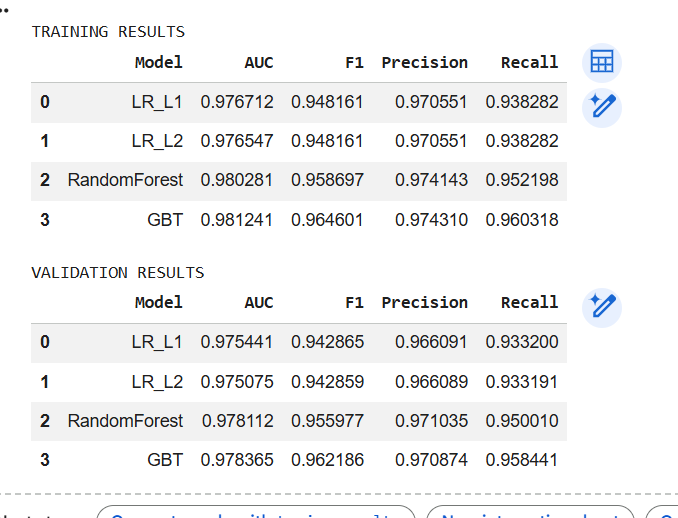
*   **Test #3**: We removed all the features related to the billing/chart page visualization (could cause behavioural leakage) ---> billing_pageviews, cart_pageviews,shipping_pageviews

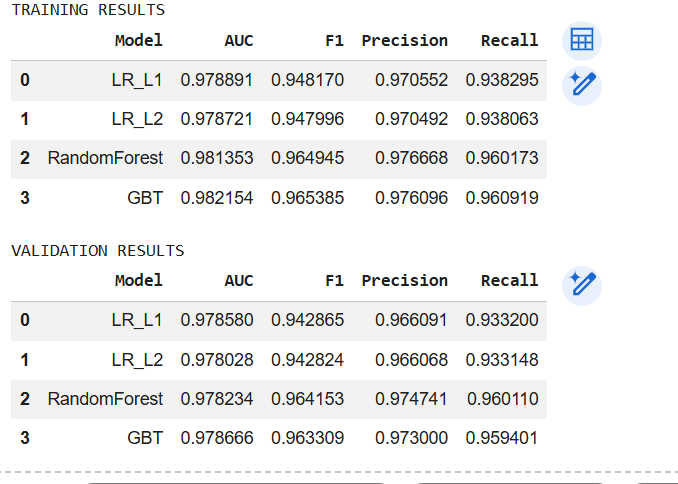

# **Final steps**

## Hyper parameter tuning


**Winner: GBT model**

F1-Score (The Balance): The GBT has the highest F1-score (0.9654). Since the F1-score is the harmonic mean of Precision and Recall, this proves that GBT is the most "stable" model. It doesn't sacrifice too much Recall to get high Precision. In a business context, this means it has the best overall accuracy for both "buyers" and "non-buyers."

Recall: The GBT has the highest Recall (0.9610). In e-commerce, Recall is often the most important metric. It measures out of everyone who actually bought, how many did the model correctly identify?

High Recall means you are catching almost all your customers.

Low Recall would mean you are missing people who were going to buy, which is a lost opportunity for personalized marketing.

Precision (The Cost Control): The Random Forest has a slightly higher Precision (0.9766 vs 0.9758), but the difference is negligible (0.08%). High precision means that when the model says "This person will buy," it is almost always right. GBT is still incredibly precise, so you aren't losing much by choosing it over Random Forest.

In [ ]:
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    seed=42
)

In [ ]:
from pyspark.ml.classification import GBTClassifier

param_grid = [
    {"maxDepth": 3, "maxIter": 50,  "stepSize": 0.05},
    {"maxDepth": 3, "maxIter": 100, "stepSize": 0.05},
    {"maxDepth": 5, "maxIter": 50,  "stepSize": 0.05},
    {"maxDepth": 5, "maxIter": 100, "stepSize": 0.05},
    {"maxDepth": 5, "maxIter": 100, "stepSize": 0.10},
    {"maxDepth": 7, "maxIter": 100, "stepSize": 0.05},
]

print(f"Total GBT configs: {len(param_grid)}")


Total GBT configs: 6


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

In [ ]:
#Prepare datasets

train_gbt = train_raw.drop("class_weight")
val_gbt   = val_raw

#Grid search loop

best_auc = 0
best_model = None
best_params = None

for params in param_grid:

    gbt = GBTClassifier(
        labelCol="label",
        featuresCol="features",
        maxDepth=params["maxDepth"],
        maxIter=params["maxIter"],
        stepSize=params["stepSize"],
        seed=42
    )

    model = gbt.fit(train_gbt)

    val_pred = model.transform(val_gbt)
    auc = evaluator.evaluate(val_pred)

    print(f"Params {params} → AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_model = model
        best_params = params

Params {'maxDepth': 3, 'maxIter': 50, 'stepSize': 0.05} → AUC: 0.9782
Params {'maxDepth': 3, 'maxIter': 100, 'stepSize': 0.05} → AUC: 0.9783


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
ERROR:py4j.clientserver:Exception occurred while shutting down connection
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver

KeyboardInterrupt: 

In [ ]:
#Best model summary
print("\n BEST GBT MODEL (Validation)")
print(f"AUC    : {best_auc:.4f}")
print(f"Params : {best_params}")

In [ ]:
#Validation diagnostics
val_pred_best = best_model.transform(val_gbt)

compute_metrics(val_pred_best)
confusion_matrix(val_pred_best).show()
plot_confusion_matrix(val_pred_best, "GBT – Tuned")
plot_gain_curve(val_pred_best, "GBT – Tuned")
plot_lift_curve(val_pred_best, "GBT – Tuned", k=0.1)

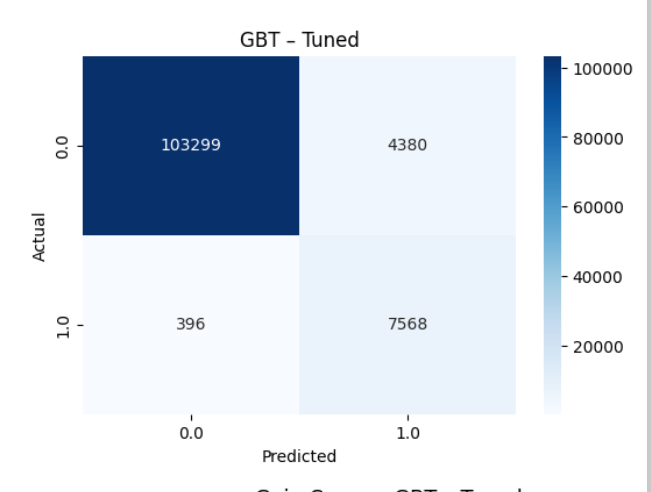

In [ ]:
# Save best tuned GBT model in memory
best_val_auc=0.9788
maxDepth= 5
maxIter= 100
stepSize= 0.1

## Re-training+ Testing

After selecting the best parameters, we are going to retrain our selected model on Training+validating and test it on the testing dataset.

In [ ]:
# Combine TRAIN + VALIDATION
train_val_gbt = (
    train_raw
    .unionByName(val_raw, allowMissingColumns=True)
    .drop("class_weight")  # GBT does NOT use weights
)

print("Train + Validation rows:", train_val_gbt.count())

Train + Validation rows: 275159


In [ ]:
intermediate_gbt_model = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=maxDepth,
    maxIter=maxIter,
    stepSize=stepSize,
    seed=42
).fit(train_val_gbt)

print("✅ Intermediate GBT model retrained on Train + Validation")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Prepare test set
test_gbt = test_raw   # test_raw already has label + features

# Predict
test_pred = intermediate_gbt_model.transform(test_gbt)

# AUC
test_auc = evaluator.evaluate(test_pred)
print(f" Intermediate TEST AUC: {test_auc:.4f}")


NameError: name 'intermediate_gbt_model' is not defined

In [ ]:
# Full test diagnostics
test_metrics = compute_metrics(test_pred)
print("Test metrics:", test_metrics)

confusion_matrix(test_pred).show()
plot_confusion_matrix(test_pred, "GBT – Intermediate Test")
plot_gain_curve(test_pred, "GBT – Intermediate Test")
plot_lift_curve(test_pred, "GBT – Intermediate,", k=0.1)


**True Accuracy & AUC check**:
We created a set of two month inside test set with no label and no connection to the order table. We will use it to try to score , and then compare it to the actual predictions.

In [ ]:
#scoring on the final model
test_scoring_predictions = intermediate_gbt_model.transform(test_scoring_final)

test_scoring_predictions = test_scoring_predictions.withColumn(
    "prob_1",
    vector_to_array("probability")[1]
)

test_scoring_predictions.select("website_session_id", "prediction").show(10)


In [ ]:
#loading the actual results for the period December 1, 2024, 00:00:00 to January 30, 2025, 23:59:59
test_scoring_true_predictions = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("/content/drive/MyDrive/Project/test_scoring_true_predictions_csv")
)

test_scoring_true_predictions.show(10)

In [ ]:
print("Predictions count:",
      test_scoring_predictions.select("website_session_id").distinct().count())

print("True labels count:",
      test_scoring_true_predictions.select("website_session_id").distinct().count())


NameError: name 'test_scoring_predictions' is not defined

In [ ]:
comparison_df = (
    test_scoring_predictions
    .select("website_session_id", "prediction", "prob_1")
    .join(
        test_scoring_true_predictions.select("website_session_id", "label"),
        on="website_session_id",
        how="inner"
    )
)

In [ ]:
comparison_with_match = comparison_df.withColumn(
    "match",
    when(col("prediction") == col("label"), 1).otherwise(0)
)

comparison_with_match.show(10)

In [ ]:
comparison_with_match.filter(col("match") == 1).count()


In [ ]:
accuracy = comparison_with_match.select(avg("match")).collect()[0][0]

print(f"Accuracy: {accuracy:.4f}")

In [ ]:
comparison_df.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


In [ ]:
auc_df = comparison_df.select(
    col("label").cast("double").alias("label"),
    col("prob_1").cast("double").alias("prob_1")
)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="prob_1",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(auc_df)

print(f"AUC on matched scoring sessions: {auc:.4f}")


**Conclusion**: Model performance decreases slightly when applied to a future scoring window (AUC 0.92 vs 0.98 on test-eval), which is expected due to temporal drift and the absence of label availability at scoring time. Despite this, the model retains strong ranking power, confirming its robustness and suitability for real-world deployment.

##Holdout prediction & scoring

In [ ]:
final_gbt_model = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=maxDepth,
    maxIter=maxIter,
    stepSize=stepSize,
    seed=42
).fit(final_train_rf_df)

print("✅ Final GBT model retrained on Train + Validation + Test")

In [ ]:
holdout_bt_final = spark.read.parquet("/content/drive/MyDrive/Project/holdout_bt_final.parquet")
holdout_bt_final.cache()
holdout_bt_final.count()

In [ ]:
#1.Predict using your best model (e.g., best_gbt_model)
scored_holdout = final_gbt_model.transform(holdout_bt_final)

In [ ]:
# 2. Select only the essentials
# We keep user_id to aggregate, and session_id for the grain

final_scored_holdout = scored_holdout.select(
    "user_id",
    "website_session_id",
    vector_to_array(F.col("probability"))[1].alias("prob_purchase")
)

final_scored_holdout.show()

In [ ]:
# 3. Aggregate to User Level
# We take the MAX: If any session is a 1, the user is a 1.
final_user_scorecard = (
    scored_holdout
    .groupBy("user_id")
    .agg(F.spark_max("prediction").alias("predicted_to_buy"))
    # We cast to Integer so it looks like a clean 0 or 1
    .withColumn("predicted_to_buy", F.col("predicted_to_buy").cast("int"))
    .select("user_id", "predicted_to_buy")
)

In [ ]:
print("Final User Scorecard (Holdout):")
final_user_scorecard.show(20)

In [ ]:
# Check the summary statistics (Mean, Min, Max probability)
final_user_scorecard.select("predicted_to_buy").describe().show()

In [ ]:
# 6. Export to CSV or Parquet for your final delivery
(final_user_scorecard
 .write
 .mode("overwrite")
 .option("header", "True")
 .csv("/content/drive/MyDrive/Project/final_user_predictions_binary.csv"))

# **MULTI-CLASS MODEL MATRIX** – Product Prediction

In addition to predicting whether a session converts, we build a second model to predict which product will be purchased.

This multi-class model is trained only on sessions that resulted in a purchase, using the primary product as the label.

**Key principles**:
*   Same session-level basetable and feature engineering pipeline
*   Same chronological splits (train / validation / test)
*   Labels derived from the primary purchased product
*   Feature space aligned across all datasets

**The output matrices are**:
*   train_multi_final
*   val_multi_final
*   test_multi_final

These datasets are used for training and evaluating the product prediction model.

## **Label Creation**

The objective of this step is to create labels for the multi-class model by identifying sessions that resulted in a purchase and assigning the primary purchased product as the target. Only the main product of each order is considered to ensure that each session corresponds to a single class. This allows the model to learn patterns that differentiate product choice rather than conversion itself.

Goal:
Identify sessions where a purchase occurred and
assign the primary purchased product as the label.

Important:
 - Only primary products are used
 - Each session has exactly one label

In [ ]:
# Join orders with order_items to get product_id for each session
# Only keep sessions that resulted in a purchase
multi_class_sessions = (
    orders
    .join(
        order_items.filter(col("is_primary_item") == 1),  # Only primary product
        on="order_id",
        how="inner"
    )
    .select("website_session_id", "user_id", "product_id")
    .distinct()
)

print("Sessions with product labels:", multi_class_sessions.count())

# Verify product distribution
multi_class_sessions.groupBy("product_id").count().orderBy("product_id").show()

# Check for sessions with multiple products (should be 0 after filtering is_primary_item)
multi_check = (
    multi_class_sessions
    .groupBy("website_session_id")
    .agg(F.countDistinct("product_id").alias("num_products"))
)
multi_check.filter(col("num_products") > 1).count()  # Should be 0

##Defining time window

In [ ]:
# TIME WINDOWS (REUSED FOR MULTI-CLASS)

# TRAIN
train_start = "2022-03-19 00:00:00"
train_end   = "2023-11-30 23:59:59"

# VALIDATION
val_start = "2023-12-01 00:00:00"
val_end   = "2024-06-30 23:59:59"

# TEST
test_start = "2024-07-01 00:00:00"
test_end   = "2025-01-30 23:59:59"


##Matrices Creation


The training, validation, and test matrices are built using the same session-level basetable and feature engineering pipeline as the binary model. Chronological splits are preserved to maintain temporal consistency and avoid leakage. Only sessions with a confirmed purchase are included, since the task is to predict which product is bought, not whether a purchase occurs.

In [ ]:
# Filter sessions that resulted in a purchase in the training period
sessions_train_multi = (
    website_sessions
    .filter(
        (col("date_of_creation") >= train_start) &
        (col("date_of_creation") <= train_end)
    )
    .join(
        multi_class_sessions
            .select("website_session_id", "product_id"),
        on="website_session_id",
        how="inner"
    )
)

print("Training sessions with product labels:", sessions_train_multi.count())

# Create the basetable using your SAME feature engineering function
train_multi_bt = build_final_session_basetable(
    sessions_df=sessions_train_multi,
    pageviews_df=pageviews_train,  # Use same pageviews you used for binary
    include_labels=False  # We'll add product_id as label manually
)

# Add product_id as the label
train_multi_bt = train_multi_bt.join(
    multi_class_sessions.select("website_session_id", "product_id"),
    on="website_session_id",
    how="inner"
)

# Fill missing values (same as binary model)
train_multi_bt = train_multi_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

# IMPORTANT: Product IDs must be 0-indexed for Spark ML
# Product 1 → label 0, Product 2 → label 1, Product 3 → label 2, Product 4 → label 3
train_multi_bt = train_multi_bt.withColumn(
    "label",
    (col("product_id") - 1).cast("double")  # 1→0, 2→1, 3→2, 4→3
)

print("\n=== Multi-Class Training Data Prepared ===")
print(f"Total rows: {train_multi_bt.count()}")
print("\nLabel distribution:")
train_multi_bt.groupBy("label", "product_id").count().orderBy("label").show()


In [ ]:
# MULTI-CLASS: VALIDATION SET
sessions_val_multi = (
    website_sessions
    .filter(
        (col("date_of_creation") >= val_start) &
        (col("date_of_creation") <= val_end)
    )
    .join(
        multi_class_sessions
            .select("website_session_id", "product_id"),
        on="website_session_id",
        how="inner"
    )
)

print("Validation sessions with product labels:", sessions_val_multi.count())

val_multi_bt = build_final_session_basetable(
    sessions_df=sessions_val_multi,
    pageviews_df=pageviews_val,
    include_labels=False
)

val_multi_bt = (
    val_multi_bt
    .join(multi_class_sessions.select("website_session_id", "product_id"),
          on="website_session_id", how="inner")
    .na.fill({"avg_time_between_pv": -1, "max_time_between_pv": -1})
    .withColumn("label", (col("product_id") - 1).cast("double"))
)

print("Multi-class validation rows:", val_multi_bt.count())
val_multi_bt.groupBy("label").count().orderBy("label").show()


In [ ]:
# MULTI-CLASS: TEST SET

sessions_test_multi = (
    website_sessions
    .filter(
        (col("date_of_creation") >= test_start) &
        (col("date_of_creation") <= test_end)
    )
    .join(
        multi_class_sessions
            .select("website_session_id", "product_id"),
        on="website_session_id",
        how="inner"
    )
)

print("Test sessions with product labels:", sessions_test_multi.count())

test_multi_bt = build_final_session_basetable(
    sessions_df=sessions_test_multi,
    pageviews_df=pageviews_test,
    include_labels=False
)

test_multi_bt = (
    test_multi_bt
    .join(multi_class_sessions.select("website_session_id", "product_id"),
          on="website_session_id", how="inner")
    .na.fill({"avg_time_between_pv": -1, "max_time_between_pv": -1})
    .withColumn("label", (col("product_id") - 1).cast("double"))
)

print("Multi-class test rows:", test_multi_bt.count())
test_multi_bt.groupBy("label").count().orderBy("label").show()

print("\n=== Multi-Class Data Summary ===")
print(f"Train: {train_multi_bt.count()}")
print(f"Validation: {val_multi_bt.count()}")
print(f"Test: {test_multi_bt.count()}")

The multi-class matrices reuse the same behavioral and session-level features as the binary model, ensuring consistency between conversion prediction and product prediction. Training is restricted to sessions with purchases so that the model learns patterns that differentiate product choice rather than conversion intent.

####**Feature Selection**
Feature selection was performed in two steps. First, a correlation matrix was used to identify highly correlated features and detect redundancy. Then, among correlated feature pairs, features were manually selected based on interpretability, stability, and relevance to product choice. Features that were weakly related to purchase behavior or redundant with stronger signals were removed to improve model robustness and reduce noise.

In [ ]:
# FEATURE SELECTION (EXPLORATORY)
# Purpose:
# Detect highly correlated features and understand
# relationships before selecting the final feature set.

print("\n" + "=" * 70)
print("FEATURE SELECTION: FEATURE–FEATURE CORRELATION ANALYSIS")
print("=" * 70)

# Drop IDs, label, timestamps, and categoricals

COLS_TO_DROP = [
    "website_session_id",
    "user_id",
    "label",
    "product_id",
    "date_of_creation",
    "device_type",
    "traffic_source",
    "utm_source",
    "utm_campaign",
    "utm_content"
]

train_multi_bt_fs = train_multi_bt.drop(
    *[c for c in COLS_TO_DROP if c in train_multi_bt.columns]
)

# Keep ONLY numeric columns

numeric_features = [
    field.name
    for field in train_multi_bt_fs.schema.fields
    if isinstance(field.dataType, NumericType)
]

print(f"\nNumeric features used ({len(numeric_features)}):")
for f in numeric_features:
    print(" -", f)

# Sample and convert to Pandas (correlation only)

train_multi_sample = (
    train_multi_bt_fs
    .select(numeric_features)
    .sample(fraction=0.2, seed=42)
    .toPandas()
)

print(f"\nSample size used for correlation: {len(train_multi_sample)}")

# Feature–feature correlation matrix

corr_df = (
    train_multi_sample
    .apply(pd.to_numeric, errors="coerce")
    .corr()
)

# Heatmap visualization

plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    linewidths=0.4
)
plt.title("Feature–Feature Correlation Matrix (Multi-Class)", fontsize=16)
plt.tight_layout()
plt.show()

# Extract highly correlated feature pairs

HIGH_CORR_THRESHOLD = 0.6  # exploratory threshold

high_corr_pairs = (
    corr_df.abs()
    .where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr_pairs.columns = ["feature_1", "feature_2", "correlation"]

high_corr_pairs = (
    high_corr_pairs[high_corr_pairs["correlation"] > HIGH_CORR_THRESHOLD]
    .sort_values("correlation", ascending=False)
)

print("\n=== Highly Correlated Feature Pairs (>|0.6|) ===")

if len(high_corr_pairs) == 0:
    print("No highly correlated feature pairs found.")
else:
    print(high_corr_pairs.to_string(index=False))



In [ ]:
multi_class_features_final = [

    # Session exploration & diversity
    "unique_pages_count",
    "distinct_products_viewed",

    # Product interest strength
    "product_pageviews",

    # Funnel progression
    "funnel_stage",

    # Navigation behavior
    "home_pageviews",
    "lander_pageviews",
    # Timing & hesitation
    "avg_time_between_pv",
    "long_pauses",
    # Checkout-related intensity
    "shipping_pageviews",
    "viewed_ecoshell",
    "viewed_corepack",
    "viewed_techfortress",
    "viewed_airlite",
]


In [ ]:
final_multi_features = [
    f for f in multi_class_features_final
    if f in train_multi_bt.columns
]
print(f"Using {len(final_multi_features)} features:")
for f in final_multi_features:
    print(" -", f)

#### **Creating Feature Vectors**
The selected features are converted into numerical vectors using the same transformation logic applied in the binary model. All features are cast to numeric types and missing values are handled consistently to ensure compatibility with Spark ML models. This step produces the final training, validation, and test datasets used for multi-class model training and evaluation.

In [ ]:
# Ensure feature list exists in the data

final_multi_features = [
    f for f in multi_class_features_final
    if f in train_multi_bt.columns
]

print(f"Using {len(final_multi_features)} features:")
for f in final_multi_features:
    print(" -", f)

# Create VectorAssembler

multi_assembler = VectorAssembler(
    inputCols=final_multi_features,
    outputCol="features",
    handleInvalid="keep"
)

# Prepare TRAIN set

train_multi_bt_f = (
    train_multi_bt
    .select(["label"] + final_multi_features)
    .fillna(0)
)

# Cast all features + label to double
for c in final_multi_features + ["label"]:
    train_multi_bt_f = train_multi_bt_f.withColumn(c, col(c).cast(DoubleType()))

train_multi_final = (
    multi_assembler
    .transform(train_multi_bt_f)
    .select("label", "features")
)

print("\nMulti-class training rows:", train_multi_final.count())
print("Label distribution (train):")
train_multi_final.groupBy("label").count().orderBy("label").show()

# Prepare VALIDATION set

val_multi_bt_f = (
    val_multi_bt
    .select(["label"] + final_multi_features)
    .fillna(0)
)

for c in final_multi_features + ["label"]:
    val_multi_bt_f = val_multi_bt_f.withColumn(c, col(c).cast(DoubleType()))

val_multi_final = (
    multi_assembler
    .transform(val_multi_bt_f)
    .select("label", "features")
)

print("\nMulti-class validation rows:", val_multi_final.count())
print("Label distribution (validation):")
val_multi_final.groupBy("label").count().orderBy("label").show()

# Prepare TEST set

test_multi_bt_f = (
    test_multi_bt
    .select(["label"] + final_multi_features)
    .fillna(0)
)

for c in final_multi_features + ["label"]:
    test_multi_bt_f = test_multi_bt_f.withColumn(c, col(c).cast(DoubleType()))

test_multi_final = (
    multi_assembler
    .transform(test_multi_bt_f)
    .select("label", "features")
)

print("\nMulti-class test rows:", test_multi_final.count())
print("Label distribution (test):")
test_multi_final.groupBy("label").count().orderBy("label").show()

# Save feature list for Part 2

import json

with open("/content/drive/MyDrive/Project/multi_class_features.json", "w") as f:
    json.dump(final_multi_features, f)

print("\n✅ Multi-class feature list saved to Drive")


#### **Creating holdout_multi_matrix**

The holdout matrix is constructed using the same feature engineering pipeline and selected features as the training data, but without labels. This dataset represents future unseen sessions and is used only for scoring. Keeping the preprocessing and feature space identical ensures that the model operates under the same conditions as during training, preserving reliability of predictions.

In [ ]:

holdout_multi_bt = build_final_session_basetable(
    sessions_df=website_sessions_holdout,
    pageviews_df=website_pageviews_holdout,
    include_labels=True
)

holdout_multi_bt = holdout_multi_bt.drop("label")

holdout_multi_bt = holdout_multi_bt.na.fill({
    "avg_time_between_pv": -1,
    "max_time_between_pv": -1
})

holdout_multi_bt_f = (
    holdout_multi_bt
    .select(["website_session_id"] + ["user_id"]+ [col_name for col_name in multi_class_features_final if col_name in holdout_multi_bt.columns])
)

# Cast feature columns to double (excluding website_session_id)
for c in final_features:
    if c in holdout_multi_bt_f.columns:
        holdout_multi_bt_f = holdout_multi_bt_f.withColumn(c, col(c).cast("double"))

holdout_multi_bt_final = (
    multi_assembler # Use the assembler fitted on training data
    .transform(holdout_multi_bt_f)
    .select("website_session_id","user_id", "features")
)


## **Training and Evaluation**
This section focuses on training and evaluating the multi-class model used to predict which product is purchased during a converting session. Only sessions with confirmed purchases are used, and the same feature engineering pipeline and time-based splits defined in Part 1 are reused to ensure consistency and avoid leakage.

#### **Data Preparation**

The prepared training, validation, and test matrices generated in Part 1 are loaded and inspected. These matrices already contain the final selected features and feature vectors, ensuring that the modeling phase focuses only on training and evaluation rather than additional preprocessing.

####**Training and Evaluation & Model Comparison**
Each candidate model is trained on the training dataset and evaluated on the validation dataset. Using a separate validation period ensures that model selection reflects generalization performance rather than training accuracy.

Validation metrics from all candidate models are consolidated to enable direct comparison. The selected model is chosen based on validation performance, stability, and interpretability rather than training metrics.

In [ ]:
# MULTI-CLASS PRODUCT PREDICTION - MODEL TRAINING
print("\n" + "="*60)
print("STARTING MULTI-CLASS PRODUCT PREDICTION")
print("="*60)

# Load the custom feature list for multi-class (if you created one)
import json

try:
    with open("/content/drive/MyDrive/Project/multi_class_features.json", "r") as f:
        multi_class_features = json.load(f)
    print(f"✅ Loaded {len(multi_class_features)} custom multi-class features")
except FileNotFoundError:
    print("⚠️  Multi-class feature list not found, using binary model features")
    multi_class_features = final_features

print(f"\nMulti-class model will use {len(multi_class_features)} features")

In [ ]:
#Check class balance
print("\nOriginal label distribution in training set:")
class_dist = train_multi_final.groupBy("label").count().orderBy("label")
class_dist.show()

#Calculate class statistics
class_counts = class_dist.collect()
total_samples = sum([row['count'] for row in class_counts])

print("\nClass imbalance analysis:")
for row in class_counts:
    label = int(row['label'])
    count = row['count']
    percentage = (count / total_samples) * 100
    product_name = ["CorePack", "TechFortress", "AirLite", "EcoShell"][label]
    print(f"  Product {label + 1} ({product_name}): {count:6d} samples ({percentage:5.2f}%)")


In [ ]:
#Identify minority class
min_class_count = min([row['count'] for row in class_counts])
max_class_count = max([row['count'] for row in class_counts])
imbalance_ratio = max_class_count / min_class_count

print(f"\nImbalance ratio: {imbalance_ratio:.1f}:1")

In [ ]:
if imbalance_ratio > 10:
    print(" SEVERE CLASS IMBALANCE DETECTED!")
    print("   → Will apply balancing techniques")
else:
    print("✅ Moderate imbalance - standard techniques should work")

During the training period, only a subset of products had been officially launched and therefore had observable purchase data. Specifically, only two products recorded sales events, while the remaining products were introduced later and did not appear in the historical orders. Since supervised learning requires observed outcomes, the multi-class model was trained exclusively on the products available during the training window.

To ensure consistency between learning and evaluation, both the training and validation datasets were filtered to include only these launched products. Products introduced after the training period represent a cold-start scenario and are handled at scoring time using behavioral signals rather than supervised classification. This approach prevents the introduction of artificial classes, avoids data leakage, and ensures that model performance metrics remain meaningful and interpretable.

In [ ]:
# TRAINING DATA – KEEP ONLY LAUNCHED PRODUCTS
print("\n" + "="*60)
print("FILTERING TRAINING DATA TO LAUNCHED PRODUCTS")
print("="*60)

existing_labels = (
    train_multi_final
    .groupBy("label")
    .count()
    .filter(col("count") > 0)
    .select("label")
    .rdd.flatMap(lambda x: x)
    .collect()
)

print(f"Existing product labels in training data: {existing_labels}")

train_multi_existing = train_multi_final.filter(col("label").isin(existing_labels))

print("\nTraining label distribution:")
train_multi_existing.groupBy("label").count().orderBy("label").show()


In [ ]:
# VALIDATION DATA & EVALUATORS SETUP

print("\n" + "="*60)
print("SETTING UP VALIDATION DATA AND EVALUATORS")
print("="*60)

# Validation data must match training labels

val_multi_existing = val_multi_final.filter(col("label").isin(existing_labels))

print("\nValidation label distribution (launched products only):")
val_multi_existing.groupBy("label").count().orderBy("label").show()

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Macro-averaged precision & recall
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

print(" Validation data and evaluators ready")


In [ ]:
print("\n--- Model 1: Random Forest (Launched Products Only) ---")

rf_multi = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=150,
    maxDepth=10,
    minInstancesPerNode=1,
    seed=42
)

print("Training Random Forest...")
rf_multi_model = rf_multi.fit(train_multi_existing)
print(" Random Forest trained")

# Evaluate on validation (same launched products)
val_pred_rf = rf_multi_model.transform(val_multi_existing)

val_acc_rf = evaluator_accuracy.evaluate(val_pred_rf)
val_f1_rf = evaluator_f1.evaluate(val_pred_rf)
val_precision_rf = evaluator_precision.evaluate(val_pred_rf)
val_recall_rf = evaluator_recall.evaluate(val_pred_rf)

print(f"\nRandom Forest - Validation Metrics:")
print(f"  Accuracy:  {val_acc_rf:.4f}")
print(f"  F1 Score:  {val_f1_rf:.4f}")
print(f"  Precision: {val_precision_rf:.4f}")
print(f"  Recall:    {val_recall_rf:.4f}")

print("\nPer-Class Recall (Launched Products):")
for class_label in existing_labels:
    class_data = val_pred_rf.filter(col("label") == class_label)
    total = class_data.count()
    correct = class_data.filter(col("prediction") == class_label).count()
    recall = correct / total if total > 0 else 0
    print(f"  Label {int(class_label)}: {recall:.2%} ({correct}/{total})")

print("\nConfusion Matrix:")
val_pred_rf.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


In [ ]:
val_rf_debug = (
    val_pred_rf
    .withColumn("probs", vector_to_array("probability"))
    .select(
        "label",
        F.get("probs", 0).alias("prob_corepack"),
        F.get("probs", 1).alias("prob_techfortress")
    )
)

val_rf_debug.show(10, truncate=False)


In [ ]:
val_rf_debug.groupBy("label").agg(
    F.avg("prob_corepack").alias("avg_prob_corepack"),
    F.avg("prob_techfortress").alias("avg_prob_techfortress")
).show()


In [ ]:
# MODEL 2: LOGISTIC REGRESSION (UNWEIGHTED, SCALED)
print("\n--- Model 2: Logistic Regression (Unweighted, Scaled) ---")

# Scale features (fit ONLY on training data)
scaler_multi = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_multi_model = scaler_multi.fit(train_multi_existing)

train_multi_scaled = (
    scaler_multi_model
    .transform(train_multi_existing)
    .select(
        col("label"),
        col("scaledFeatures").alias("features")
    )
)

val_multi_scaled = (
    scaler_multi_model
    .transform(val_multi_existing)
    .select(
        col("label"),
        col("scaledFeatures").alias("features")
    )
)

# Train Logistic Regression (NO class weights)
lr_multi = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.5,
    family="multinomial"
)

print("Training Logistic Regression...")
lr_multi_model = lr_multi.fit(train_multi_scaled)
print(" Logistic Regression trained")

val_pred_lr = lr_multi_model.transform(val_multi_scaled)

val_acc_lr = evaluator_accuracy.evaluate(val_pred_lr)
val_f1_lr = evaluator_f1.evaluate(val_pred_lr)
val_precision_lr = evaluator_precision.evaluate(val_pred_lr)
val_recall_lr = evaluator_recall.evaluate(val_pred_lr)

print(f"\nLogistic Regression - Validation Metrics:")
print(f"  Accuracy:  {val_acc_lr:.4f}")
print(f"  F1 Score:  {val_f1_lr:.4f}")
print(f"  Precision: {val_precision_lr:.4f}")
print(f"  Recall:    {val_recall_lr:.4f}")

print("\nPer-Class Recall (Launched Products):")
for class_label in existing_labels:
    class_data = val_pred_lr.filter(col("label") == class_label)
    total = class_data.count()
    correct = class_data.filter(col("prediction") == class_label).count()
    recall = correct / total if total > 0 else 0
    print(f"  Label {int(class_label)}: {recall:.2%} ({correct}/{total})")

print("\nConfusion Matrix:")
val_pred_lr.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


 Validation performance is extremely high for launched products, indicating that browsing behavior contains strong product-specific intent signals. This suggests low ambiguity between products rather than model overfitting.

In [ ]:
val_multi_new = val_multi_final.filter((col("label") == 2) | (col("label") == 3))

In [ ]:
print("\nCold-start analysis for newly launched product (Product 3&4):")
val_pred_new = rf_multi_model.transform(val_multi_new)

val_pred_new.groupBy("prediction").count().orderBy("prediction").show()


Products 3 and 4 were introduced during the validation period and therefore represents a cold-start scenario. Since the multi-class model was trained only on previously launched products, it cannot explicitly predict Product 3 and 4. When applied to Products 3 and 4 buyers, the model assigns them almost exclusively to Product 0, indicating that early adopters exhibit browsing behavior highly similar to CorePack buyers. This confirms that the model generalizes intent patterns rather than memorizing labels.

In [ ]:
# MODEL SELECTION
print("\n" + "="*60)
print("MODEL SELECTION")
print("="*60)

# Compare models
models_comparison = [
    ("Random Forest (Balanced)", val_f1_rf, val_acc_rf),
    ("Logistic Regression (Weighted)", val_f1_lr, val_acc_lr),
]

print("\nModel Comparison:")
for model_name, f1, acc in models_comparison:
    print(f"  {model_name:35s}: F1={f1:.4f}, Accuracy={acc:.4f}")

# Select best model based on F1 score (better for imbalanced data)
best_model_info = max(models_comparison, key=lambda x: x[1])
selected_model_name = best_model_info[0]
selected_model_f1 = best_model_info[1]

print(f"\n Selected Model: {selected_model_name} (F1: {selected_model_f1:.4f})")

# Set the selected model
if "Random Forest" in selected_model_name:
    selected_model_type = "RandomForest"
    base_model = rf_multi
    best_model = rf_multi_model
    use_balanced = True
    use_scaling = False
elif "Logistic Regression" in selected_model_name:
    selected_model_type = "LogisticRegression"
    base_model = lr_multi
    best_model = lr_multi_model
    use_balanced = False
    use_scaling = True

**final model selection**
Both Logistic Regression and Random Forest achieved comparable validation performance on the launched products, indicating that the underlying predictive signals are strong and consistent across modeling approaches. However, the final training dataset used for production scoring is expected to be highly imbalanced, with a dominant product and significantly fewer observations for others.

Random Forest was therefore selected as the final model, as it is inherently more robust to class imbalance, without requiring explicit reweighting or strong distributional assumptions.

####**Hyperparameter Tuning**
Hyperparameter tuning was conducted using a dedicated validation window, rather than cross-validation, to preserve the temporal structure of the data. Candidate Random Forest models were trained on the training period and evaluated on the validation period, with the optimal configuration selected based on validation F1 score.
However, the training seems almost useless because the results are always the highest possible, but for the sake of following the structure we set, we will do it.

In [ ]:
# PHASE 2: HYPERPARAMETER TUNING – RANDOM FOREST
# (VALIDATION-BASED)
print("\n" + "="*60)
print("PHASE 2: HYPERPARAMETER TUNING – RANDOM FOREST (VALIDATION)")
print("="*60)

# Hyperparameter grid
numTrees_grid = [100, 150, 200]
maxDepth_grid = [8, 10, 12]
minInstances_grid = [1, 5]

best_f1 = -1
best_model = None
best_params = {}

# Grid search
for numTrees in numTrees_grid:
    for maxDepth in maxDepth_grid:
        for minInstances in minInstances_grid:

            rf = RandomForestClassifier(
                featuresCol="features",
                labelCol="label",
                numTrees=numTrees,
                maxDepth=maxDepth,
                minInstancesPerNode=minInstances,
                seed=42
            )

            model = rf.fit(train_multi_existing)
            val_pred = model.transform(val_multi_existing)

            f1 = evaluator_f1.evaluate(val_pred)

            print(
                f"RF(numTrees={numTrees}, "
                f"maxDepth={maxDepth}, "
                f"minInstances={minInstances}) "
                f"→ F1 = {f1:.4f}"
            )

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_params = {
                    "numTrees": numTrees,
                    "maxDepth": maxDepth,
                    "minInstancesPerNode": minInstances
                }

# Best model summary
print("\n Best Random Forest configuration (on validation):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"  Best F1 score: {best_f1:.4f}")


####**Retrain on Train + Validation, Evaluate on Test**
After selecting and tuning the Logistic Regression model, it is retrained on the combined training and validation datasets to maximize learning before final evaluation. The model is then evaluated on the test dataset, which has not been used during training or tuning, providing an unbiased estimate of performance.

In [ ]:
# PHASE 3: RETRAIN ON TRAIN + VALIDATION
print("\n" + "="*60)
print("PHASE 3: RETRAINING ON TRAIN + VALIDATION")
print("="*60)

# Combine Train + Validation (all products available)
train_val_multi = train_multi_final.unionByName(val_multi_final)

print("\nTrain + Validation label distribution:")
train_val_multi.groupBy("label").count().orderBy("label").show()

# Retrain final Random Forest with best hyperparameters
final_multi_model = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=best_params["numTrees"],
    maxDepth=best_params["maxDepth"],
    minInstancesPerNode=best_params["minInstancesPerNode"],
    seed=42
).fit(train_val_multi)

print(" Final model retrained on Train + Validation")


Testing on test set

In [ ]:
# TEST SET EVALUATION – ALL PRODUCTS
test_pred_multi = final_multi_model.transform(test_multi_final)

test_acc = evaluator_accuracy.evaluate(test_pred_multi)
test_f1  = evaluator_f1.evaluate(test_pred_multi)
test_precision = evaluator_precision.evaluate(test_pred_multi)
test_recall    = evaluator_recall.evaluate(test_pred_multi)

print("\n TEST SET PERFORMANCE (ALL PRODUCTS):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")


In [ ]:
# TEST SET CONFUSION MATRIX – ALL PRODUCTS
print("\n--- Test Set Confusion Matrix (All Products) ---")

(
    test_pred_multi
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
    .show()
)


In [ ]:
print("\n--- Confusion Matrix (Pivoted) ---")

(
    test_pred_multi
    .groupBy("label")
    .pivot("prediction")
    .count()  # Use count() directly here to count rows in each group
    .fillna(0)
    .orderBy("label")
    .show()
)


After inspection related to the missing of prediction for the label 4, we realized product 4 appears in the validation period, but not as a primary_product_id, which is what our analysis is based on given we only have to predict one purchase in the final scoring.
Product 4 becomes a primary product only during the test period and therefore represents a true cold-start case. As a result, class weighting for Product 4 cannot be evaluated using historical data. Model performance is reported using an unweighted Random Forest, while class-weighted retraining is applied only in the final deployment step to account for expected imbalance in future data.

####**Final Model Training on All Data**
The final multi-class model is trained using the full available dataset, combining training, validation, and test periods. At this stage, the objective shifts from model evaluation to deployment readiness. Since the last product is introduced only in the test period, it represents a true cold-start case and cannot be evaluated using historical validation data. To address the resulting class imbalance and improve the model’s ability to learn minority products, class weighting is applied through resampling during final training. This weighted model is not evaluated further and is intended solely for future prediction and operational use.

In [ ]:
# PHASE 4: FINAL MODEL - TRAIN ON ALL DATA (WEIGHTED RF)
print("\n" + "="*60)
print("PHASE 4: FINAL MODEL TRAINING ON ALL DATA (WEIGHTED RF)")
print("="*60)


# Combine Train + Validation + Test (ALL PRODUCTS)
final_train_all = (
    train_multi_final
    .unionByName(val_multi_final)
    .unionByName(test_multi_final)
)

print("\nFinal label distribution (raw):")
final_train_all.groupBy("label").count().orderBy("label").show()

# Compute class counts
label_counts = {
    row["label"]: row["count"]
    for row in final_train_all.groupBy("label").count().collect()
}

max_count = max(label_counts.values())

print("\nClass counts:")
for k, v in label_counts.items():
    print(f"  Label {int(k)}: {v}")

# Resample to APPLY CLASS WEIGHTING (RF-compatible)
# Strategy:
# - Keep majority class as-is
# - Oversample minority classes proportionally

resampled_classes = []

print("\nApplying class weighting via resampling:")

for label, count in label_counts.items():
    class_df = final_train_all.filter(col("label") == label)

    if count < max_count:
        fraction = max_count / count
        print(f"  Label {int(label)} → oversample x{fraction:.2f}")
        resampled = class_df.sample(
            withReplacement=True,
            fraction=fraction,
            seed=42 + int(label)
        )
    else:
        print(f"  Label {int(label)} → kept as-is")
        resampled = class_df

    resampled_classes.append(resampled)

# Combine resampled classes
final_train_weighted = resampled_classes[0]
for df in resampled_classes[1:]:
    final_train_weighted = final_train_weighted.unionByName(df)

print("\nFinal label distribution (after weighting):")
final_train_weighted.groupBy("label").count().orderBy("label").show()

# Train FINAL Random Forest (Deployment Model)
final_multi_model = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=best_params["numTrees"],
    maxDepth=best_params["maxDepth"],
    minInstancesPerNode=best_params["minInstancesPerNode"],
    seed=42
).fit(final_train_weighted)

print("\n Final WEIGHTED Random Forest trained on ALL data")

# Feature importance (optional but useful)
print("\nTop 15 Feature Importances:")
feature_importance_multi = list(
    zip(multi_class_features, final_multi_model.featureImportances)
)
feature_importance_multi_sorted = sorted(
    feature_importance_multi, key=lambda x: x[1], reverse=True
)[:15]

for i, (feat, imp) in enumerate(feature_importance_multi_sorted, 1):
    print(f"  {i:2d}. {feat:40s}: {imp:.4f}")

print("\n" + "="*60)
print("FINAL MULTI-CLASS MODEL READY FOR DEPLOYMENT")
print("="*60)
print(f"Model type: Random Forest")
print(f"Class weighting: YES (resampling)")
print(f"Training data: Train + Validation + Test")


### Holdout Scoring - Multi-Class Logic

This section applies the final multi-class model to the holdout dataset in order to predict product preferences at the session level. The holdout basetable `(holdout_multi_bt_final)` is first enriched with session-level product interaction features derived from pageview URLs and then scored using the final Random Forest model. The model outputs a probability distribution over all products for each session. These probabilities are extracted and used to identify the most likely product along with the associated confidence score `(max_prob)`. No post-hoc heuristic adjustments or confidence-based overrides are applied at this stage, ensuring that predictions rely solely on learned patterns from historical data. The resulting session-level predictions and probabilities are then used in subsequent steps to aggregate preferences at the user level and generate final product recommendations.

In [ ]:
# Map product_id from pageview_url (FEATURE ONLY)
#take this out later



pageviews_holdout_mapped = (
    website_pa
    .withColumn(
        "product_id",
        when(lower(col("pageview_url")).contains("corepack"), lit(1))
        .when(lower(col("pageview_url")).contains("techfortress"), lit(2))
        .when(lower(col("pageview_url")).contains("airlite"), lit(3))
        .when(lower(col("pageview_url")).contains("ecoshell"), lit(4))
        .otherwise(None)
    )
    .withColumn("created_at", col("created_at").cast("timestamp"))#take this last line out later
)

print(" Product mapping from URLs completed")

In [ ]:
#Aggregate product views at session level
session_product_features = (
    pageviews_holdout_mapped
    .filter(col("product_id").isNotNull())
    .groupBy("website_session_id")
    .agg(
        F.count("*").alias("product_pageviews"),
        F.collect_set("product_id").alias("products_viewed")
    )
    .withColumn("viewed_corepack",     F.array_contains(col("products_viewed"), 1).cast("int"))
    .withColumn("viewed_techfortress", F.array_contains(col("products_viewed"), 2).cast("int"))
    .withColumn("viewed_airlite",      F.array_contains(col("products_viewed"), 3).cast("int"))
    .withColumn("viewed_ecoshell",     F.array_contains(col("products_viewed"), 4).cast("int"))
    .select(
        "website_session_id",
        "product_pageviews",
        "viewed_corepack",
        "viewed_techfortress",
        "viewed_airlite",
        "viewed_ecoshell"
    )
)
print(" Session-level product features created")

In [ ]:
holdout_multi_scored = final_multi_model.transform(holdout_multi_bt_scoring)

print(" Holdout multi-class scoring completed")

In [ ]:
holdout_multi_final = (
    holdout_multi_scored
    .withColumn("probs", vector_to_array("probability"))
    .withColumn("prob_corepack",     F.get("probs", 0))
    .withColumn("prob_techfortress", F.get("probs", 1))
    .withColumn("prob_airlite",      F.get("probs", 2))
    .withColumn("prob_ecoshell",     F.get("probs", 3))
)

print(" Product probabilities extracted")

In [ ]:
holdout_multi_final = (
    holdout_multi_final
    .withColumn(
        "max_prob",
        F.greatest(
            col("prob_corepack"),
            col("prob_techfortress"),
            col("prob_airlite"),
            col("prob_ecoshell")
        )
    )
    .withColumn(
        "predicted_product_id",
        F.when(col("prob_corepack")     == col("max_prob"), 1)
         .when(col("prob_techfortress") == col("max_prob"), 2)
         .when(col("prob_airlite")      == col("max_prob"), 3)
         .otherwise(4)
    )
)

####**Aggregating Predictions to User Level**
Product preferences are first estimated at the session level using a multi-class classification model that outputs purchase probabilities for each product. Since users may generate multiple sessions within the prediction window, session-level probabilities are aggregated to the user level by computing the average probability for each product. This approach captures consistent interest across browsing behavior while reducing noise from isolated or accidental interactions. The product with the highest average probability is then selected as the predicted product for the user and encoded in a one-hot format. To ensure business consistency, product predictions are combined with a separate binary model that predicts whether a user will purchase at all; for users predicted not to buy, all product indicators are set to zero. This two-stage framework cleanly separates purchase intent from product choice, handles multiple sessions per user, and provides robust, interpretable recommendations suitable for deploymen

In [ ]:
holdout_multi_final.printSchema() #should contain predicted_product_id, max_prob

In [ ]:
# USER-LEVEL AGGREGATION (AVERAGE PROBABILITIES)
print("\n--- Aggregating session probabilities to user level (average) ---")

user_multi_probs = (
    holdout_multi_final
    .groupBy("user_id")
    .agg(
        F.avg("prob_corepack").alias("avg_prob_corepack"),
        F.avg("prob_techfortress").alias("avg_prob_techfortress"),
        F.avg("prob_airlite").alias("avg_prob_airlite"),
        F.avg("prob_ecoshell").alias("avg_prob_ecoshell")
    )
)

print(f"Unique users with product probabilities: {user_multi_probs.count()}")
user_multi_probs.show(5)


In [ ]:
# SELECT MOST LIKELY PRODUCT PER USER
user_multi_predictions = (
    user_multi_probs
    .withColumn(
        "max_prob",
        F.greatest(
            col("avg_prob_corepack"),
            col("avg_prob_techfortress"),
            col("avg_prob_airlite"),
            col("avg_prob_ecoshell")
        )
    )
    .withColumn(
        "predicted_product_id",
        F.when(col("avg_prob_corepack") == col("max_prob"), 1)
         .when(col("avg_prob_techfortress") == col("max_prob"), 2)
         .when(col("avg_prob_airlite") == col("max_prob"), 3)
         .otherwise(4)
    )
    .select("user_id", "predicted_product_id", "max_prob")
)

print("\nUser-level predicted product distribution:")
user_multi_predictions.groupBy("predicted_product_id").count().orderBy("predicted_product_id").show()


####**Creating Final Product Prediction Format**
Predictions are converted into a one-hot encoded format with one column per product. Each user receives exactly one predicted product, ensuring compatibility with the required submission format.

In [ ]:
# CREATE FINAL MULTI-CLASS OUTPUT (ONE-HOT)
print("\n--- Creating one-hot encoded product predictions ---")

PRODUCT_NAME_MAP = {
    1: "corepack",
    2: "techfortress",
    3: "airlite",
    4: "ecoshell"
}

final_multi_output = user_multi_predictions

for product_id, product_name in PRODUCT_NAME_MAP.items():
    final_multi_output = final_multi_output.withColumn(
        f"pred_{product_name}",
        F.when(col("predicted_product_id") == product_id, 1).otherwise(0)
    )

final_multi_output = final_multi_output.select(
    "user_id",
    *[f"pred_{name}" for name in PRODUCT_NAME_MAP.values()]
)

final_multi_output.show(20)


Although session-level behavior is available in the holdout period, Product 4 (Ecoshell) does not appear in the training data. As a result, the model has no historical examples linking behavioral patterns to this product and cannot learn reliable decision boundaries for it. Predicting Product 4 directly would therefore require extrapolating beyond observed labels, which risks introducing leakage or unsupported assumptions. We tested a heuristic approach in which Ecoshell was selected when other product probabilities were low and session behavior indicated clear interest in Product 4, but this adjustment did not materially change the results, so the final predictions rely on the learned model outputs.

###**MERGE BINARY AND MULTI-CLASS PREDICTIONS**
Binary conversion predictions and product predictions are merged at the user level to create the final submission dataset. Product predictions are masked for users predicted not to purchase, ensuring consistency between the two models.

In [ ]:
# MERGE BINARY AND MULTI-CLASS PREDICTIONS
print("\n" + "="*60)
print("CREATING FINAL SUBMISSION FILE")
print("="*60)

final_submission = (
    final_user_scorecard
    .join(final_multi_output, on="user_id", how="left")
    .withColumn(
        "pred_corepack",
        F.when(col("predicted_to_buy") == 1, col("pred_corepack")).otherwise(0)
    )
    .withColumn(
        "pred_techfortress",
        F.when(col("predicted_to_buy") == 1, col("pred_techfortress")).otherwise(0)
    )
    .withColumn(
        "pred_airlite",
        F.when(col("predicted_to_buy") == 1, col("pred_airlite")).otherwise(0)
    )
    .withColumn(
        "pred_ecoshell",
        F.when(col("predicted_to_buy") == 1, col("pred_ecoshell")).otherwise(0)
    )
    .select(
        col("user_id"),
        col("predicted_to_buy").alias("pred_score"),
        col("pred_corepack").alias("pred_multi_score_1"),
        col("pred_techfortress").alias("pred_multi_score_2"),
        col("pred_airlite").alias("pred_multi_score_3"),
        col("pred_ecoshell").alias("pred_multi_score_4")
    )
)

print(f"Final submission rows: {final_submission.count()}")
final_submission.show(20)


In [ ]:
# ANALYSIS: FINAL PREDICTIONS BY PRODUCT
print("\n--- Overall prediction distribution (all users) ---")

final_submission.select(
    F.sum("pred_multi_score_1").alias("corepack"),
    F.sum("pred_multi_score_2").alias("techfortress"),
    F.sum("pred_multi_score_3").alias("airlite"),
    F.sum("pred_multi_score_4").alias("ecoshell")
).show()

In [ ]:
final_submission.show()
final_submission.write.mode("overwrite").csv("/content/drive/MyDrive/Project/final_submission.csv", header=True)


#**CHANNEL TRAFFIC ANALYSIS (Sessions)**
Data prep and analysis for graphs


#### Create channel + type variable

In [ ]:
sessions_enriched = (
    website_sessions
    .withColumn(
        "channel",
        when(col("utm_source") == "gsearch", "GSearch")
        .when(col("utm_source") == "bsearch", "BSearch")
        .when(col("utm_source") == "social", "Social")
        .otherwise("Other")
    )
    .withColumn(
        "channel_type",
        when(col("utm_campaign").like("%brand%"), "Brand")
        .otherwise("Non-Brand")
    )
    .withColumn("year", year(col("date_of_creation")))
)


In [ ]:
sessions_enriched.show()

+------------------+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+-------+------------+----+
|website_session_id|user_id|is_repeat_session|utm_source|utm_campaign|utm_content|device_type|        http_referer|traffic_source|   date_of_creation|channel|channel_type|year|
+------------------+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+-------+------------+----+
|                 1|      1|                0|   gsearch|    nonbrand|     g_ad_1|     mobile|https://www.gsear...|   paid_search|2022-03-19 08:04:16|GSearch|       Brand|2022|
|                 2|      2|                0|   gsearch|    nonbrand|     g_ad_1|    desktop|https://www.gsear...|   paid_search|2022-03-19 08:16:49|GSearch|       Brand|2022|
|                 3|      3|                0|   gsearch|    nonbrand|     g_ad_1|    desktop|https://www.gsear...|

1.2 Sessions by channel / type

“Which channel/type drives the most visits?”

In [ ]:
channel_sessions = (
    sessions_enriched
    .groupBy("year", "channel", "channel_type")
    .agg(
        count("website_session_id").alias("sessions")
    )
    .orderBy("year", "channel", "channel_type")
)

channel_sessions.show()

#max nb of sessions were from GSearch


+----+-------+------------+--------+
|year|channel|channel_type|sessions|
+----+-------+------------+--------+
|2022|BSearch|       Brand|    8829|
|2022|GSearch|       Brand|   47888|
|2022|  Other|   Non-Brand|    5753|
|2023|BSearch|       Brand|   16059|
|2023|GSearch|       Brand|   79672|
|2023|  Other|   Non-Brand|   17050|
|2024|BSearch|       Brand|   29729|
|2024|GSearch|       Brand|  147399|
|2024|  Other|   Non-Brand|   45609|
|2024| Social|   Non-Brand|   10685|
|2025|BSearch|       Brand|    3279|
|2025|GSearch|       Brand|   16088|
|2025|  Other|   Non-Brand|    5968|
+----+-------+------------+--------+



In [ ]:
from pyspark.sql import Row


In [ ]:
#Attach CPC (business-critical)- Costs

In [ ]:
cpc_df = spark.createDataFrame([
    Row(channel="GSearch", channel_type="Brand", year=2022, cpc=0.20),
    Row(channel="GSearch", channel_type="Brand", year=2023, cpc=0.25),
    Row(channel="GSearch", channel_type="Brand", year=2024, cpc=0.30),
    Row(channel="GSearch", channel_type="Brand", year=2025, cpc=0.35),

    Row(channel="BSearch", channel_type="Brand", year=2022, cpc=0.10),
    Row(channel="BSearch", channel_type="Brand", year=2023, cpc=0.15),
    Row(channel="BSearch", channel_type="Brand", year=2024, cpc=0.20),
    Row(channel="BSearch", channel_type="Brand", year=2025, cpc=0.25),

    Row(channel="GSearch", channel_type="Non-Brand", year=2022, cpc=0.80),
    Row(channel="GSearch", channel_type="Non-Brand", year=2023, cpc=0.90),
    Row(channel="GSearch", channel_type="Non-Brand", year=2024, cpc=1.25),
    Row(channel="GSearch", channel_type="Non-Brand", year=2025, cpc=1.50),

    Row(channel="BSearch", channel_type="Non-Brand", year=2022, cpc=0.40),
    Row(channel="BSearch", channel_type="Non-Brand", year=2023, cpc=0.60),
    Row(channel="BSearch", channel_type="Non-Brand", year=2024, cpc=0.80),
    Row(channel="BSearch", channel_type="Non-Brand", year=2025, cpc=1.00),

    Row(channel="Social", channel_type="Non-Brand", year=2024, cpc=0.70),
    Row(channel="Social", channel_type="Non-Brand", year=2025, cpc=0.80),
])


In [ ]:
#attributing advertising costs to each channel type for each website visit

sessions_costed = (
    sessions_enriched
    .join(
        cpc_df,
        on=["channel", "channel_type", "year"],
        how="left"
    )
    .withColumn("session_cost", col("cpc"))
)
sessions_costed.show()

+-------+------------+----+------------------+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+---+------------+
|channel|channel_type|year|website_session_id|user_id|is_repeat_session|utm_source|utm_campaign|utm_content|device_type|        http_referer|traffic_source|   date_of_creation|cpc|session_cost|
+-------+------------+----+------------------+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+---+------------+
|GSearch|       Brand|2022|                 1|      1|                0|   gsearch|    nonbrand|     g_ad_1|     mobile|https://www.gsear...|   paid_search|2022-03-19 08:04:16|0.2|         0.2|
|GSearch|       Brand|2022|                 2|      2|                0|   gsearch|    nonbrand|     g_ad_1|    desktop|https://www.gsear...|   paid_search|2022-03-19 08:16:49|0.2|         0.2|
|GSearch|       Brand|2022|   

In [ ]:
#attributing revenue made in each specific session
orders_by_session = (
    orders
    .groupBy("website_session_id")
    .agg(
        sum("price_euro").alias("session_revenue")
    )
)
orders_by_session.show()

+------------------+---------------+
|website_session_id|session_revenue|
+------------------+---------------+
|              7240|         149.99|
|             13285|         149.99|
|             18800|         149.99|
|             28024|         149.99|
|             28146|         149.99|
|             29894|         149.99|
|             31528|         149.99|
|             32539|         149.99|
|             33722|         149.99|
|             37111|         149.99|
|             38395|         149.99|
|             38723|         149.99|
|             44358|         149.99|
|             46465|         149.99|
|             46521|         149.99|
|             57020|         149.99|
|             58305|         149.99|
|             63964|         149.99|
|             66010|         149.99|
|             67376|         149.99|
+------------------+---------------+
only showing top 20 rows


In [ ]:
# merging costs & revenue

sessions_profit = (
    sessions_costed
    .join(orders_by_session, "website_session_id", "left")
    .fillna({"session_revenue": 0})
)
sessions_profit.show()

+------------------+-------+------------+----+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+---+------------+---------------+
|website_session_id|channel|channel_type|year|user_id|is_repeat_session|utm_source|utm_campaign|utm_content|device_type|        http_referer|traffic_source|   date_of_creation|cpc|session_cost|session_revenue|
+------------------+-------+------------+----+-------+-----------------+----------+------------+-----------+-----------+--------------------+--------------+-------------------+---+------------+---------------+
|                 1|GSearch|       Brand|2022|      1|                0|   gsearch|    nonbrand|     g_ad_1|     mobile|https://www.gsear...|   paid_search|2022-03-19 08:04:16|0.2|         0.2|            0.0|
|                 2|GSearch|       Brand|2022|      2|                0|   gsearch|    nonbrand|     g_ad_1|    desktop|https://www.gsear...|   paid_search|2022

Profitability by channel

In [ ]:
channel_profitability = (
    sessions_profit
    .groupBy("year", "channel", "channel_type")
    .agg(
        count("website_session_id").alias("sessions"),
        sum("session_revenue").alias("revenue"),
        sum("session_cost").alias("ad_cost")
    )
    .withColumn("profit", col("revenue") - col("ad_cost"))
    .withColumn("profit_per_session", col("profit") / col("sessions"))
    .withColumn("roi", col("profit") / col("ad_cost"))
    .orderBy(col("profit").desc())
)

channel_profitability.show(truncate=False)


+----+-------+------------+--------+------------------+------------------+------------------+------------------+-----------------+
|year|channel|channel_type|sessions|revenue           |ad_cost           |profit            |profit_per_session|roi              |
+----+-------+------------+--------+------------------+------------------+------------------+------------------+-----------------+
|2024|GSearch|Brand       |147399  |2139855.0499998955|44219.699999939505|2095635.349999956 |14.217432614874973|47.39144204964808|
|2023|GSearch|Brand       |79672   |800273.2299999712 |19918.0           |780355.2299999712 |9.794598227733347 |39.17839291093339|
|2024|BSearch|Brand       |29729   |452423.3499999989 |5945.799999998974 |446477.54999999993|15.018249857041944|75.09124928522267|
|2022|GSearch|Brand       |47888   |280631.29000000283|9577.599999995671 |271053.69000000716|5.6601589124625615|28.3007945623256 |
|2025|GSearch|Brand       |16088   |266679.8000000012 |5630.799999999163 |261049.00

Traffic share by channel & type

In [ ]:

# 1. Aggregate all metrics by Channel (Removing the year dimension)
performance_summary = (
    channel_profitability
    .groupBy("channel", "channel_type")
    .agg(
        F.sum("sessions").alias("sessions"),
        F.sum("revenue").alias("revenue"),
        F.sum("ad_cost").alias("ad_cost"),
        F.sum("profit").alias("profit")
    )
)

# 2. Use Window Functions to calculate totals for percentages
# This is much faster than .collect() because the data stays on the cluster
window_all = Window.partitionBy()

performance_dashboard = (
    performance_summary
    .withColumn("total_corp_sessions", F.sum("sessions").over(window_all))
    .withColumn("total_corp_profit", F.sum("profit").over(window_all))
    # Calculate Shares
    .withColumn("traffic_share_pct", (F.col("sessions") / F.col("total_corp_sessions")) * 100)
    .withColumn("profit_share_pct", (F.col("profit") / F.col("total_corp_profit")) * 100)
    # Calculate Efficiency (ROI & Profit per Session)
    .withColumn("roi", F.col("profit") / F.col("ad_cost"))
    .withColumn("profit_per_session", F.col("profit") / F.col("sessions"))
    .drop("total_corp_sessions", "total_corp_profit") # Clean up temporary columns
)

performance_dashboard.orderBy(F.col("profit_share_pct").desc()).show()

+-------+------------+--------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|channel|channel_type|sessions|           revenue|           ad_cost|            profit| traffic_share_pct|  profit_share_pct|              roi|profit_per_session|
+-------+------------+--------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|GSearch|       Brand|  291047|3487439.3699998707| 79346.09999993433| 3408093.269999936| 67.06028460304879| 81.21909901019237|42.95224680233505|11.709769453043448|
|BSearch|       Brand|   57896| 736656.4199999997|10057.299999999037| 726599.1200000007|13.339846270114835|  17.3157602192031|72.24594274806064|12.550074616553832|
| Social|   Non-Brand|   10685| 68959.33000000013| 7479.499999999309|61479.830000000824| 2.461936185508101|1.4651407706045425| 8.21977806003162| 5.753844642021603|
|  Other|   Non-

## **Question : Channel/Type profitability and usage**

/tmp/ipython-input-2291381188.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2291381188.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2291381188.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


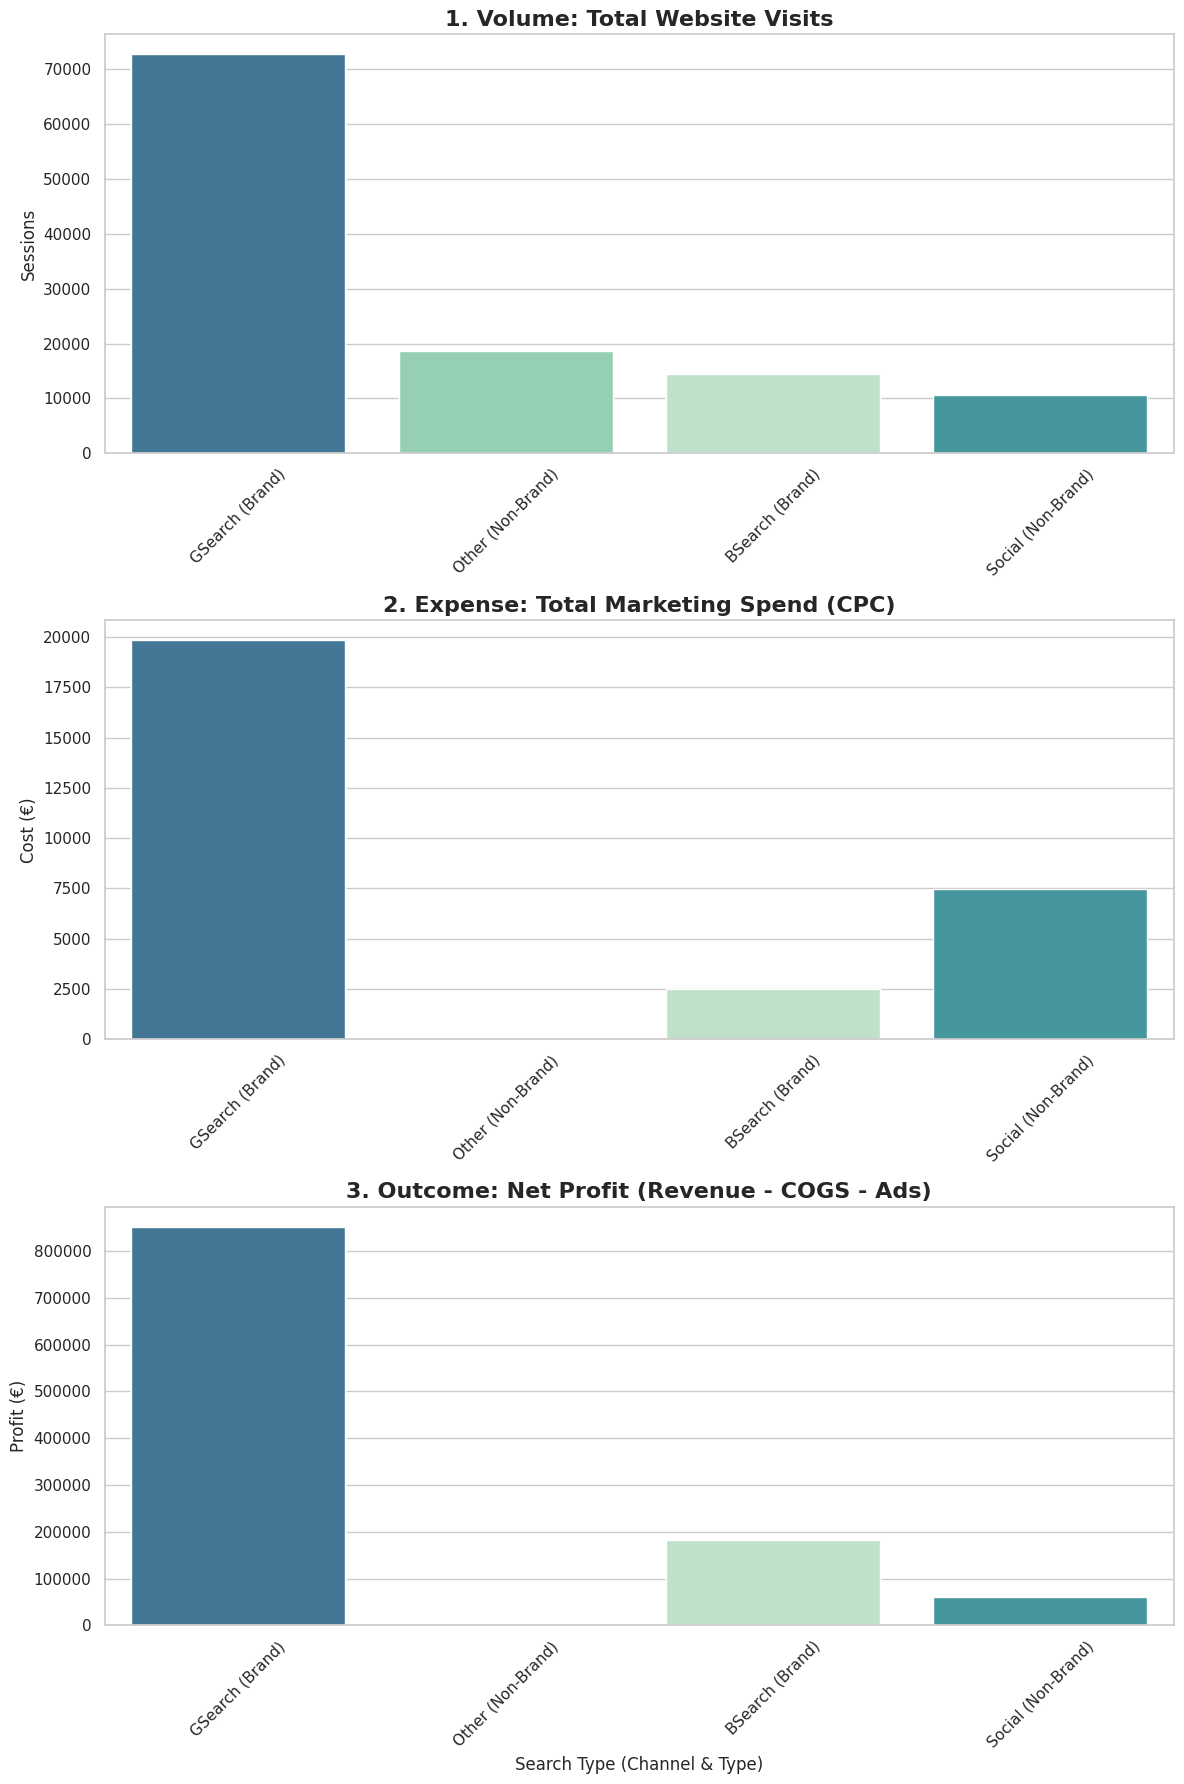

In [ ]:
# 1. Prepare the Data
profit_pd = channel_profitability.toPandas()
profit_pd['combination'] = profit_pd['channel'] + " (" + profit_pd['channel_type'] + ")"

# 2. Fix the Order (Sorted by Volume/Visits)
# This ensures every graph has the same channels in the same spots
plot_order = profit_pd.sort_values('sessions', ascending=False)['combination'].tolist()

# 3. Fix the Colors (Consistent for each Channel Combination)
unique_combos = profit_pd['combination'].unique()

# 4. Create the Subplots
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# --- GRAPH 1: TOTAL VISITS ---
sns.barplot(
    data=profit_pd, x='combination', y='sessions',
    order=plot_order, palette="mako", ax=axes[0], errorbar=None
)
axes[0].set_title('1. Volume: Total Website Visits', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Sessions')
axes[0].set_xlabel('')

# --- GRAPH 2: ADVERTISING COST ---
sns.barplot(
    data=profit_pd, x='combination', y='ad_cost',
    order=plot_order, palette="mako", ax=axes[1], errorbar=None
)
axes[1].set_title('2. Expense: Total Marketing Spend (CPC)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Cost (€)')
axes[1].set_xlabel('')

# --- GRAPH 3: NET PROFIT ---
sns.barplot(
    data=profit_pd, x='combination', y='profit',
    order=plot_order, palette="mako", ax=axes[2], errorbar=None
)
axes[2].set_title('3. Outcome: Net Profit (Revenue - COGS - Ads)', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Profit (€)')
axes[2].set_xlabel('Search Type (Channel & Type)')

# Final formatting for clean rotation
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1849865623.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1849865623.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1849865623.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


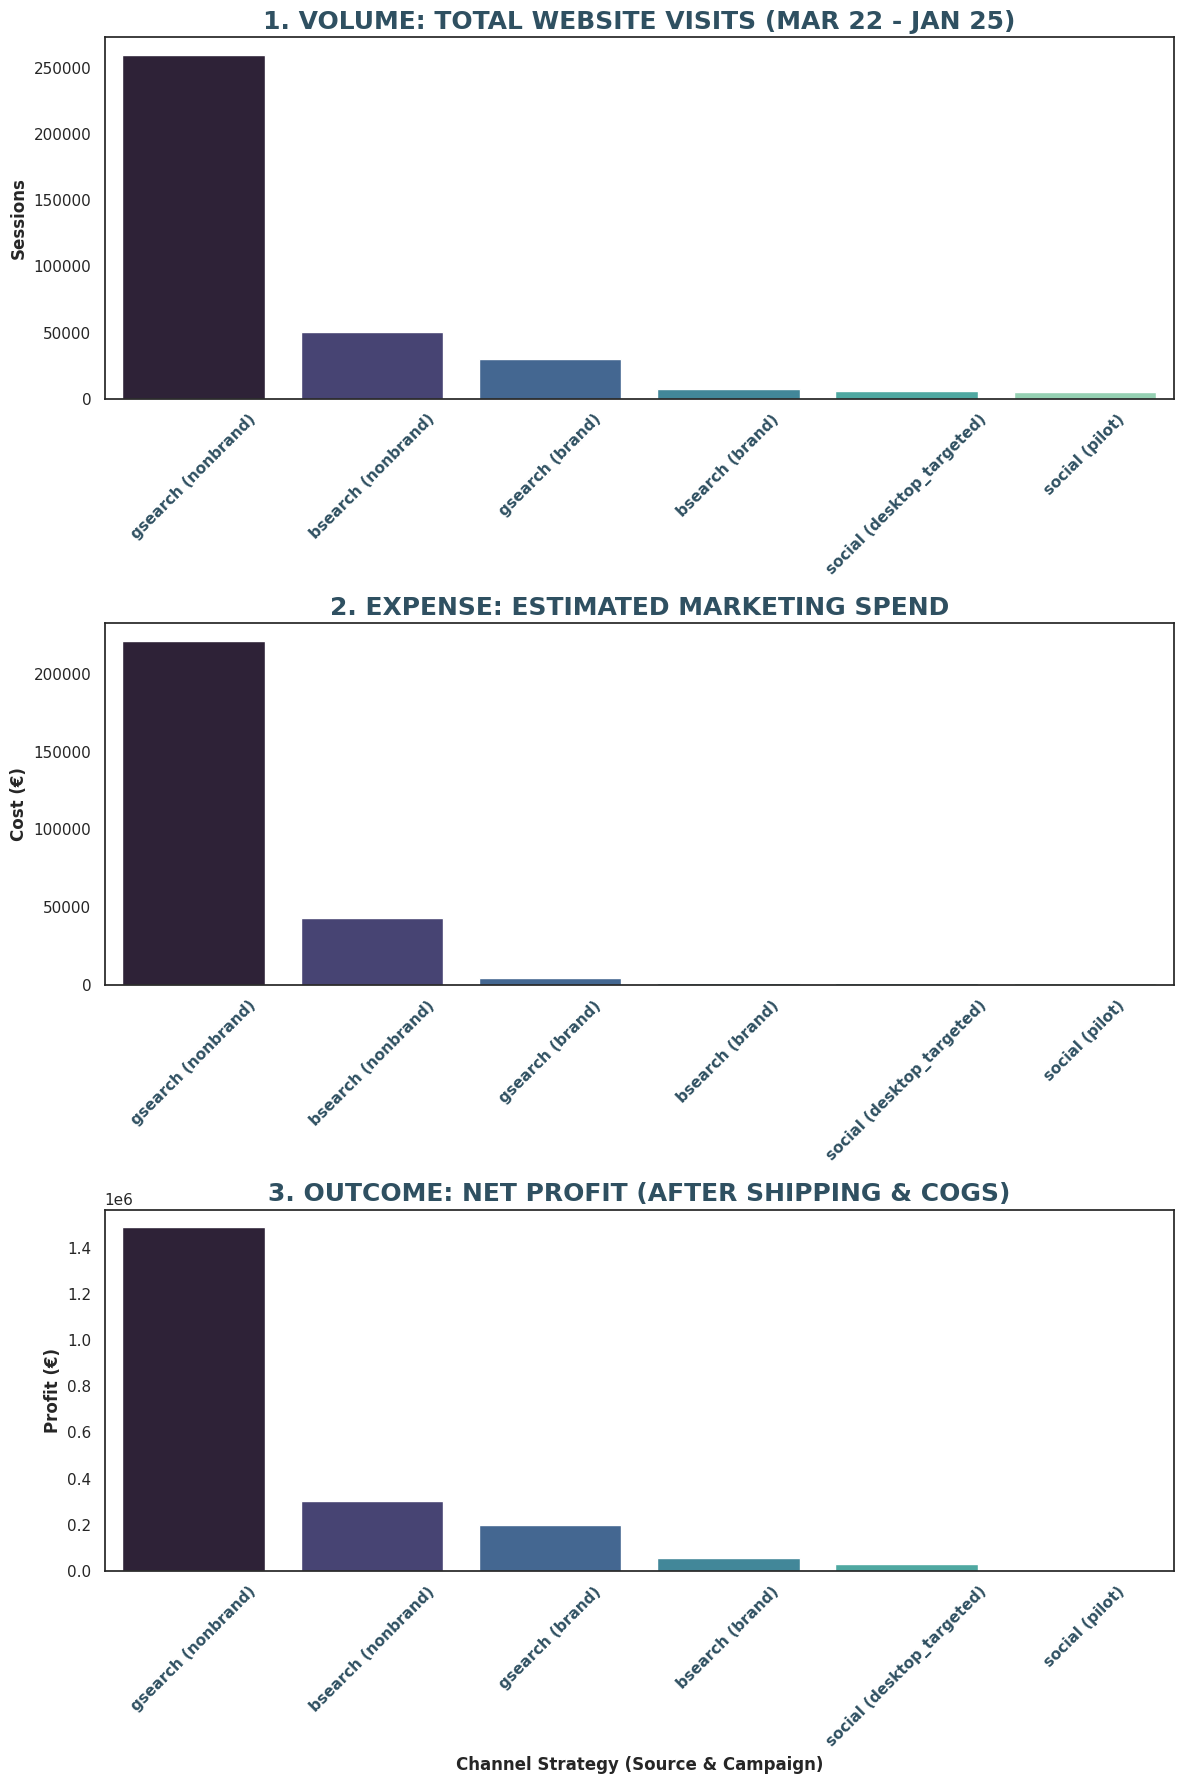

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SET THE SPECIFIC TIME WINDOW
start_date, end_date = "2022-03-19", "2025-01-30"

# 2. PREPARE THE DATA (Filtered for specific channels)
# Note: Using 'rlike' to capture 'gsearch', 'bsearch', 'social', and 'other'
channel_spark = website_sessions.alias("s") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .join(products.alias("p"), F.col("o.primary_product_id") == F.col("p.product_id"), "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .filter(F.col("utm_source").rlike("(?i)gsearch|bsearch|social|other")) \
    .groupBy("utm_source", "utm_campaign").agg(
        F.count("s.website_session_id").alias("sessions"),
        # Estimated ad cost logic: $0.85 for nonbrand, $0.15 for brand
        F.sum(F.when(F.col("utm_campaign") == 'nonbrand', 0.85).otherwise(0.15)).alias("ad_cost"),
        (F.sum("o.price_euro") - (F.sum("o.cogs_euro") + (F.count("o.order_id") * 10))).alias("profit")
    ).na.fill(0)

profit_pd = channel_spark.toPandas()
profit_pd['combination'] = profit_pd['utm_source'] + " (" + profit_pd['utm_campaign'] + ")"

# 3. FIX THE ORDER & CONSISTENCY
plot_order = profit_pd.sort_values('sessions', ascending=False)['combination'].tolist()

# 4. CREATE THE SUBPLOTS
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# --- GRAPH 1: TOTAL VISITS (VOLUME) ---
sns.barplot(
    data=profit_pd, x='combination', y='sessions',
    order=plot_order, palette="mako", ax=axes[0]
)
axes[0].set_title('1. VOLUME: TOTAL WEBSITE VISITS (MAR 22 - JAN 25)', fontsize=18, fontweight='black', color='#2F5061')
axes[0].set_ylabel('Sessions', fontweight='bold')
axes[0].set_xlabel('')

# --- GRAPH 2: ADVERTISING COST (EXPENSE) ---
sns.barplot(
    data=profit_pd, x='combination', y='ad_cost',
    order=plot_order, palette="mako", ax=axes[1]
)
axes[1].set_title('2. EXPENSE: ESTIMATED MARKETING SPEND', fontsize=18, fontweight='black', color='#2F5061')
axes[1].set_ylabel('Cost (€)', fontweight='bold')
axes[1].set_xlabel('')

# --- GRAPH 3: NET PROFIT (OUTCOME) ---
sns.barplot(
    data=profit_pd, x='combination', y='profit',
    order=plot_order, palette="mako", ax=axes[2]
)
axes[2].set_title('3. OUTCOME: NET PROFIT (AFTER SHIPPING & COGS)', fontsize=18, fontweight='black', color='#2F5061')
axes[2].set_ylabel('Profit (€)', fontweight='bold')
axes[2].set_xlabel('Channel Strategy (Source & Campaign)', fontweight='bold')


for ax in axes:
    ax.tick_params(axis='x', rotation=45, labelsize=11)
    for label in ax.get_xticklabels():
        label.set_fontweight('black')
        label.set_color('#2F5061')

plt.tight_layout()
plt.show()

In [ ]:
#data preperation


# 1. Aggregate by Channel
channel_perf = sessions_profit.groupBy("channel").agg(
    count("website_session_id").alias("visits"),
    spark_sum("session_revenue").alias("revenue"),
    spark_sum("session_cost").alias("cost")
).withColumn("profit", col("revenue") - col("cost")).toPandas()

# 2. Aggregate by Type
type_perf = sessions_profit.groupBy("channel_type").agg(
    count("website_session_id").alias("visits"),
    spark_sum("session_revenue").alias("revenue"),
    spark_sum("session_cost").alias("cost")
).withColumn("profit", col("revenue") - col("cost")).toPandas()

# Set the global style
sns.set_theme(style="whitegrid", palette="muted")


High-Margin Marketing Channels

/tmp/ipython-input-1507823731.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_pd, x='channel', y='Volume', palette="mako_r", ax=ax1, alpha=0.8)


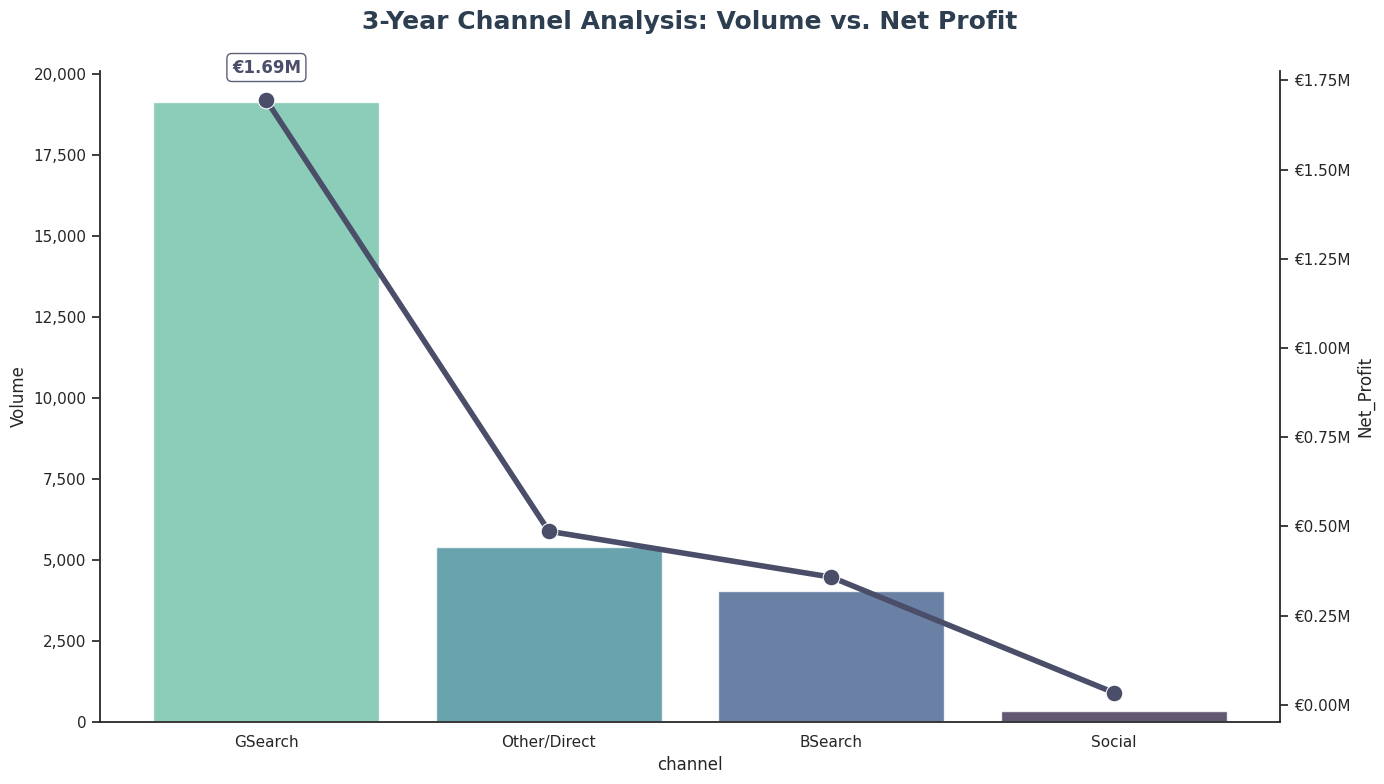

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. PREPARE DATA (Joining Sessions to get the Channel)
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

# Join orders + products + sessions to link profit to channel
channel_spark = orders.filter((F.col("created_at") >= start_date) &
                              (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .join(website_sessions, orders.website_session_id == website_sessions.website_session_id) \
    .groupBy("utm_source", "utm_campaign", "http_referer").agg(
        F.count("order_id").alias("Volume"),
        (F.sum("price_euro") - (F.sum("cogs_euro") + (F.count("order_id") * 10))).alias("Net_Profit")
    )


def categorize_channel(row):
    source = str(row['utm_source']).lower()
    campaign = str(row['utm_campaign']).lower()

    if 'gsearch' in source:
        return 'GSearch'
    elif 'bsearch' in source:
        return 'BSearch'
    elif 'social' in source or 'facebook' in source:
        return 'Social'
    else:
        return 'Other/Direct'

# Convert to Pandas and apply the naming logic
channel_pd_raw = channel_spark.toPandas()
channel_pd_raw['channel'] = channel_pd_raw.apply(categorize_channel, axis=1)

# Group by the new clean channel names
channel_pd = channel_pd_raw.groupby('channel').agg({'Volume': 'sum', 'Net_Profit': 'sum'}).reset_index()
channel_pd = channel_pd.sort_values("Volume", ascending=False)

# 3. SETUP THE PLOT
fig, ax1 = plt.subplots(figsize=(14, 8))
sns.set_theme(style="white")

# BARS: Volume
sns.barplot(data=channel_pd, x='channel', y='Volume', palette="mako_r", ax=ax1, alpha=0.8)

# LINE: Net Profit
ax2 = ax1.twinx()
sns.lineplot(data=channel_pd, x='channel', y='Net_Profit', marker='o', markersize=12,
             color='#4A4E69', linewidth=4, ax=ax2)


ax1.set_title("3-Year Channel Analysis: Volume vs. Net Profit",
             fontsize=18, fontweight='bold', pad=30, color='#2C3E50')

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'€{x/1e6:.2f}M'))

# Annotate the peak
top_val = channel_pd.iloc[0]['Net_Profit']
ax2.annotate(f'€{top_val/1e6:.2f}M',
             xy=(0, top_val), xytext=(0, 20), textcoords='offset points',
             ha='center', fontsize=12, fontweight='black', color='#4A4E69',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#4A4E69', alpha=0.9))

sns.despine(right=False)
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# 1. CALCULATE COMPANY TOTALS
total_site_volume = dash_pd['volume'].sum()
total_company_profit = dash_pd['net_profit'].sum()

# 2. We search for the row that contains "Gsearch"
gsearch_data = dash_pd[dash_pd['channel'].str.contains('Gsearch', case=False)].iloc[0]

gsearch_vol = gsearch_data['volume']
gsearch_prof = gsearch_data['net_profit']

# 3. CALCULATE THE PERCENTAGES
market_share = (gsearch_vol / total_site_volume) * 100
profit_share = (gsearch_prof / total_company_profit) * 100

# 4. PRINT THE RESULTS
print(f"Market Share: 'GSearch accounts for {market_share:.1f}% of total site traffic.'")
print(f"Profit Contribution: 'This channel generates {profit_share:.1f}% of our total Net Profit.'")

Market Share: 'GSearch accounts for 67.1% of total site traffic.'
Profit Contribution: 'This channel generates 81.2% of our total Net Profit.'


/tmp/ipython-input-1848546614.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=channel_pd, x='channel', y='Total_Cost', palette="mako", alpha=0.8)


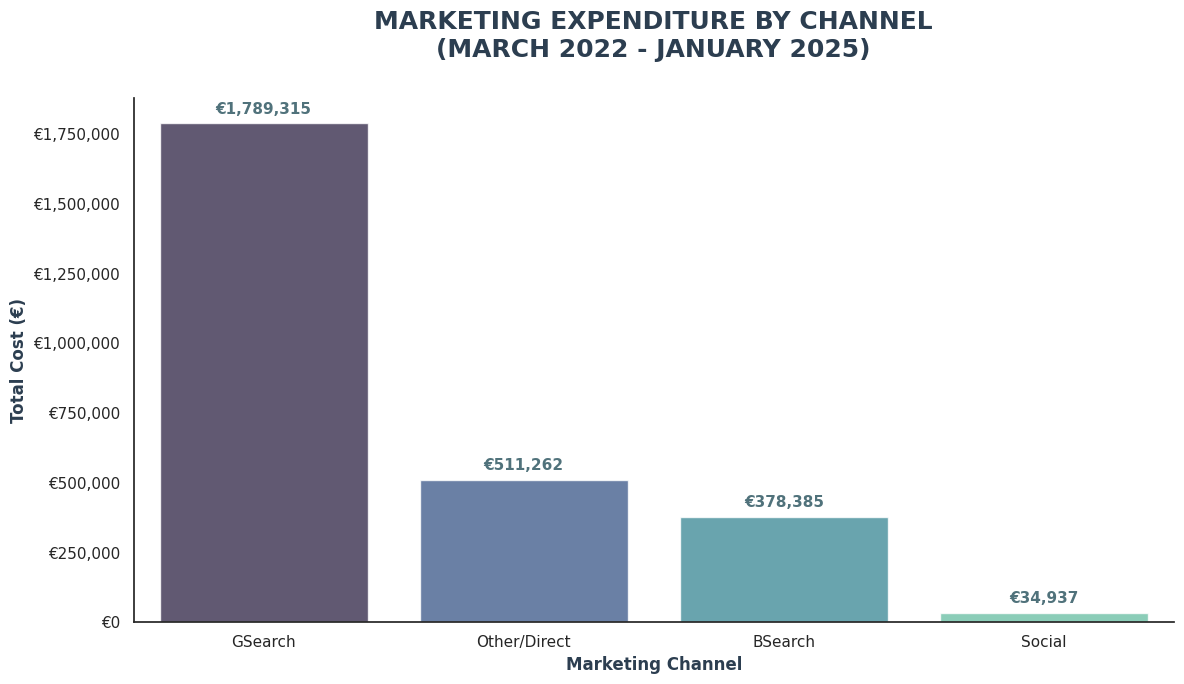

In [ ]:
#costs of channels

# 1. DATA PREPARATION
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

channel_spark = orders.filter((F.col("created_at") >= start_date) &
                              (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .join(website_sessions, orders.website_session_id == website_sessions.website_session_id) \
    .groupBy("utm_source", "utm_campaign", "http_referer").agg(
        # Total Cost logic: COGS + (€10 overhead per order)
        (F.sum("cogs_euro") + (F.count("order_id") * 10)).alias("Total_Cost")
    )

# 2. CLEAN UP CHANNEL NAMES
def categorize_channel(row):
    source = str(row['utm_source']).lower()
    if 'gsearch' in source: return 'GSearch'
    elif 'bsearch' in source: return 'BSearch'
    elif 'social' in source or 'facebook' in source: return 'Social'
    else: return 'Other/Direct'

channel_pd_raw = channel_spark.toPandas()
channel_pd_raw['channel'] = channel_pd_raw.apply(categorize_channel, axis=1)

# Group and Sort by Cost
channel_pd = channel_pd_raw.groupby('channel').agg({'Total_Cost': 'sum'}).reset_index()
channel_pd = channel_pd.sort_values("Total_Cost", ascending=False)

# 3. VISUALIZATION
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

ax = sns.barplot(data=channel_pd, x='channel', y='Total_Cost', palette="mako", alpha=0.8)

# 4. FORMATTING & LABELS
plt.title("MARKETING EXPENDITURE BY CHANNEL\n(MARCH 2022 - JANUARY 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Force standard number formatting (No le6)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))

plt.ylabel("Total Cost (€)", fontsize=12, fontweight='bold', color='#2C3E50')
plt.xlabel("Marketing Channel", fontsize=12, fontweight='bold', color='#2C3E50')

# Adding labels on top of bars for clarity
for p in ax.patches:
    ax.annotate(f'€{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',
                fontsize=11, fontweight='bold', color='#50727B')

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
## Conversion Funnel (which channels actually convince people to buy.)

/tmp/ipython-input-2818308790.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_cvr, x='cvr', y='utm_source', palette="mako", alpha=0.85)


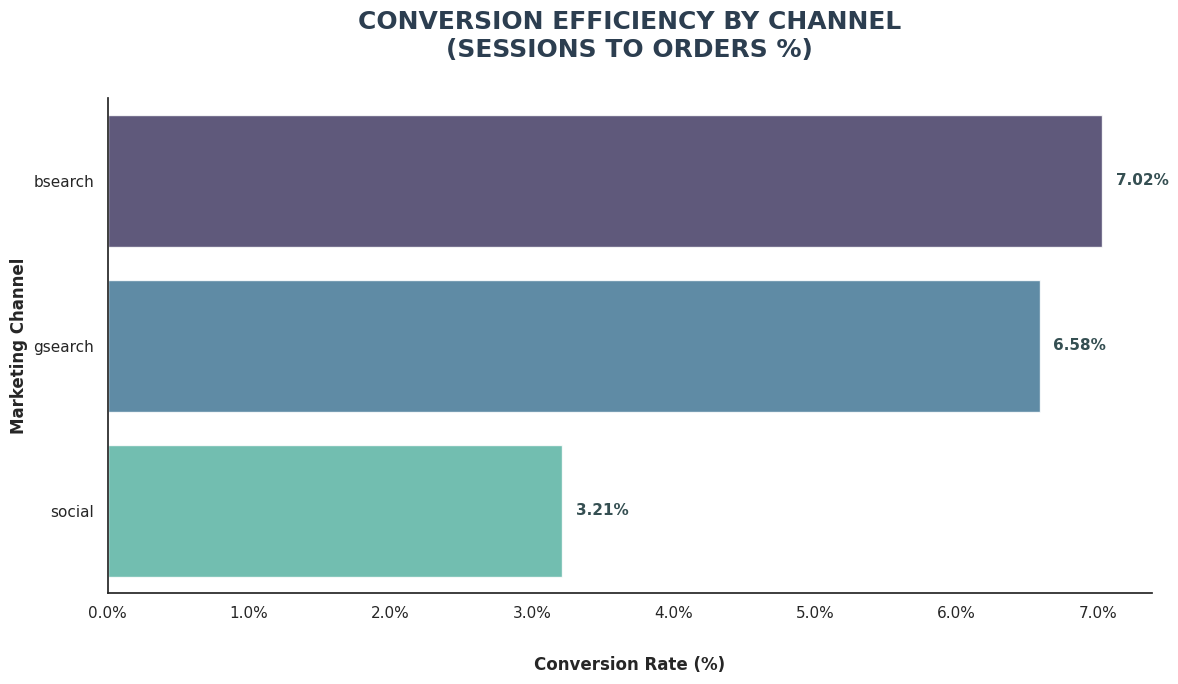

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. DATA PREPARATION
start_date, end_date = "2022-03-19", "2025-01-30"
channels_to_show = ["gsearch", "bsearch", "social", "other"]

cvr_spark = website_sessions.alias("s") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .filter(F.col("utm_source").rlike("(?i)" + "|".join(channels_to_show))) \
    .groupBy("utm_source").agg(
        F.count("s.website_session_id").alias("sessions"),
        F.count("o.order_id").alias("orders")
    )

df_cvr = cvr_spark.toPandas()
df_cvr['cvr'] = (df_cvr['orders'] / df_cvr['sessions']) * 100
df_cvr = df_cvr.sort_values('cvr', ascending=False)

# 2. VISUALIZATION (Horizontal Bars)
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

# Swap x and y to make it horizontal
ax = sns.barplot(data=df_cvr, x='cvr', y='utm_source', palette="mako", alpha=0.85)

# 3. FORMATTING
plt.title("CONVERSION EFFICIENCY BY CHANNEL\n(SESSIONS TO ORDERS %)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Format X-axis as percentage
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

# X-axis label in a lower position
ax.set_xlabel("Conversion Rate (%)", fontsize=12, fontweight='bold', labelpad=25)
ax.set_ylabel("Marketing Channel", fontsize=12, fontweight='bold')

# 4. ANNOTATE (Placing percentage text at the end of the bars)
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}%',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=11, fontweight='black', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

Advertisement channels

/tmp/ipython-input-3801368756.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=marketing_pd, x='Marketing_Type', y='Volume', palette="mako_r", ax=ax1, alpha=0.8)


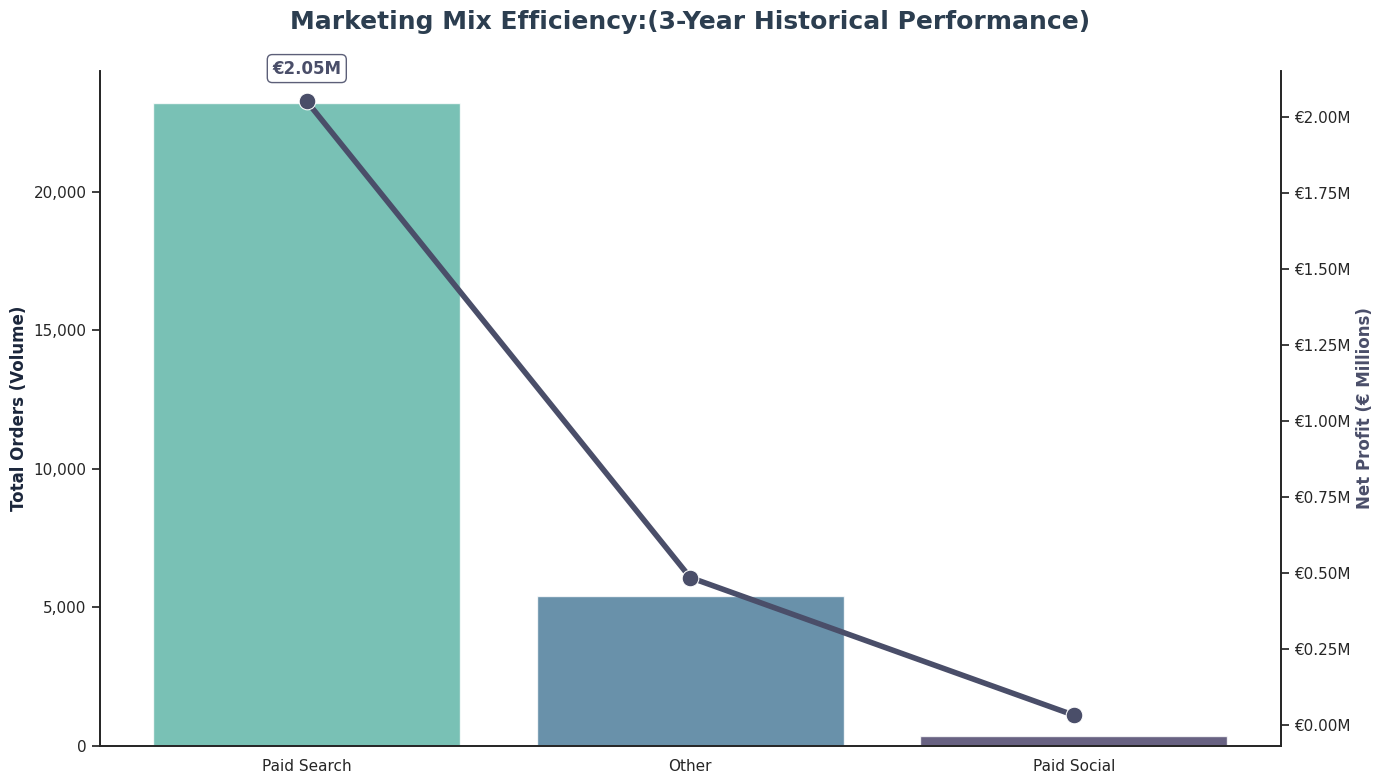

In [ ]:


# 1. PREPARE DATA (Joining Sessions
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

marketing_spark = orders.filter((F.col("created_at") >= start_date) &
                                (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .join(website_sessions, orders.website_session_id == website_sessions.website_session_id) \
    .groupBy("utm_source", "utm_campaign", "http_referer").agg(
        F.count("order_id").alias("Volume"),
        (F.sum("price_euro") - (F.sum("cogs_euro") + (F.count("order_id") * 10))).alias("Net_Profit")
    )

# 2. MARKETING CLASSIFICATION LOGIC
def categorize_marketing_type(row):
    source = str(row['utm_source']).lower() if row['utm_source'] else ""
    campaign = str(row['utm_campaign']).lower() if row['utm_campaign'] else ""
    referer = str(row['http_referer']).lower() if row['http_referer'] else ""

    if source in ['gsearch', 'bsearch']:
        return 'Paid Search'
    elif 'social' in source or 'facebook' in source:
        return 'Paid Social'
    elif source == "" and referer in ['https://www.google.com', 'https://www.bing.com']:
        return 'Organic Search'
    elif source == "" and referer == "":
        return 'Direct Type-In'
    else:
        return 'Other'

# Convert to Pandas and Group
marketing_pd_raw = marketing_spark.toPandas()
marketing_pd_raw['Marketing_Type'] = marketing_pd_raw.apply(categorize_marketing_type, axis=1)

marketing_pd = marketing_pd_raw.groupby('Marketing_Type').agg({'Volume': 'sum', 'Net_Profit': 'sum'}).reset_index()
marketing_pd = marketing_pd.sort_values("Volume", ascending=False)

# 3. CREATE THE VISUALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))
sns.set_theme(style="white")

# BARS: Volume
sns.barplot(data=marketing_pd, x='Marketing_Type', y='Volume', palette="mako_r", ax=ax1, alpha=0.8)

# LINE: Net Profit
ax2 = ax1.twinx()
sns.lineplot(data=marketing_pd, x='Marketing_Type', y='Net_Profit', marker='o', markersize=12,
             color='#4A4E69', linewidth=4, ax=ax2)

# 4. FORMATTING
ax1.set_title("Marketing Mix Efficiency:(3-Year Historical Performance)",
             fontsize=18, fontweight='bold', pad=30, color='#2C3E50')

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'€{x/1e6:.2f}M'))

ax1.set_ylabel("Total Orders (Volume)", fontsize=12, fontweight='bold', color='#1B263B')
ax2.set_ylabel("Net Profit (€ Millions)", fontsize=12, fontweight='bold', color='#4A4E69')
ax1.set_xlabel("")

# Annotate the Profit on top bar for Paid Search
top_prof = marketing_pd.iloc[0]['Net_Profit']
ax2.annotate(f'€{top_prof/1e6:.2f}M',
             xy=(0, top_prof), xytext=(0, 20), textcoords='offset points',
             ha='center', fontsize=12, fontweight='black', color='#4A4E69',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#4A4E69', alpha=0.9))

sns.despine(right=False)
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

/tmp/ipython-input-837835849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tool_pd, x='ad_tool', y='Total_Cost', palette="mako", alpha=0.85)


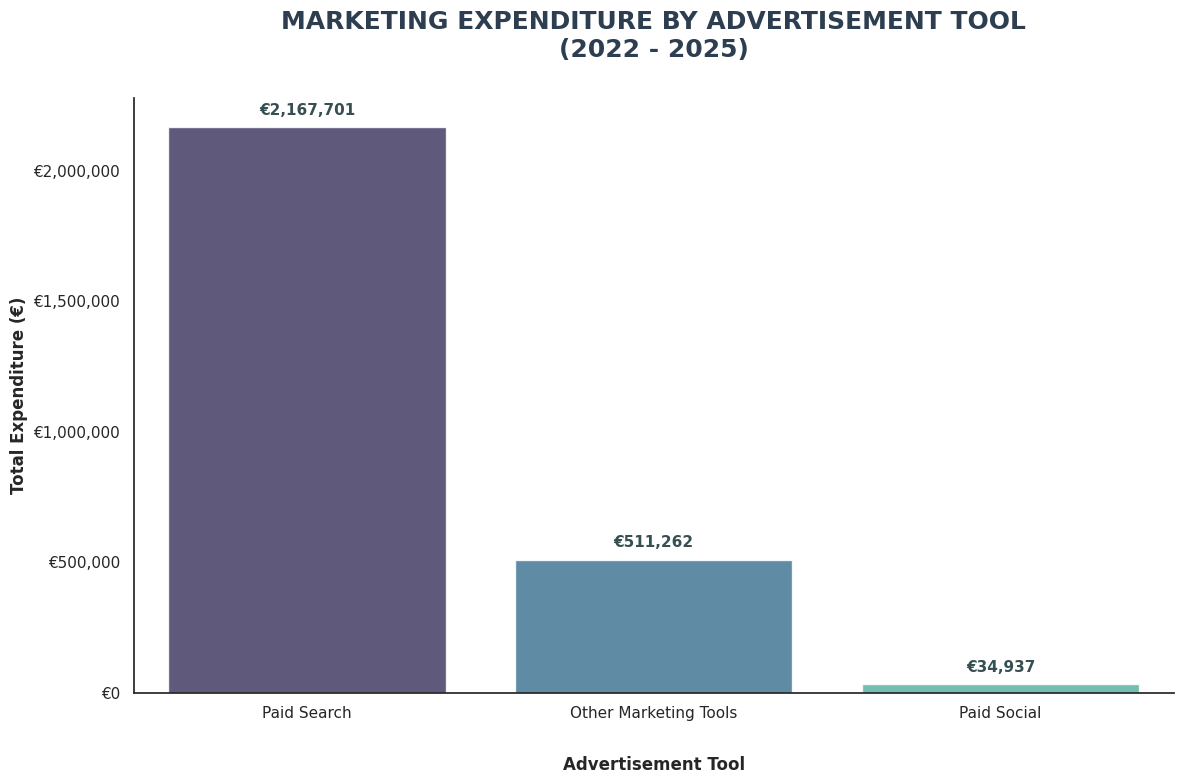

In [ ]:

# 1. PREPARE DATA
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

tool_spark = orders.filter((F.col("created_at") >= start_date) &
                           (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .join(website_sessions, orders.website_session_id == website_sessions.website_session_id) \
    .groupBy("utm_source").agg(
        (F.sum("cogs_euro") + (F.count("order_id") * 10)).alias("Total_Cost")
    )

# 2. CATEGORIZE BY ADVERTISEMENT TOOL
def categorize_tool(row):
    source = str(row['utm_source']).lower()
    if any(x in source for x in ['gsearch', 'bsearch']):
        return 'Paid Search'
    elif any(x in source for x in ['social', 'facebook', 'instagram']):
        return 'Paid Social'
    else:
        return 'Other Marketing Tools'

tool_pd_raw = tool_spark.toPandas()
tool_pd_raw['ad_tool'] = tool_pd_raw.apply(categorize_tool, axis=1)

tool_pd = tool_pd_raw.groupby('ad_tool').agg({'Total_Cost': 'sum'}).reset_index()
tool_pd = tool_pd.sort_values("Total_Cost", ascending=False)

# 3. VISUALIZATION
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")

ax = sns.barplot(data=tool_pd, x='ad_tool', y='Total_Cost', palette="mako", alpha=0.85)

# 4. FORMATTING & POSITIONING
plt.title("MARKETING EXPENDITURE BY ADVERTISEMENT TOOL\n(2022 - 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Removing le6 and formatting as Currency
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))

plt.ylabel("Total Expenditure (€)", fontsize=12, fontweight='bold')

# ADJUSTED: Moving the X-label lower using labelpad
# labelpad increases the spacing between the axis and the title
ax.set_xlabel("Advertisement Tool", fontsize=12, fontweight='bold', labelpad=25)

# Add cost labels on top of the bars
for p in ax.patches:
    ax.annotate(f'€{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=11, fontweight='black', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
#conversion rate of madvertisement tool

/tmp/ipython-input-1141875724.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tool_cvr, x='cvr', y='ad_tool', palette="mako", alpha=0.85)


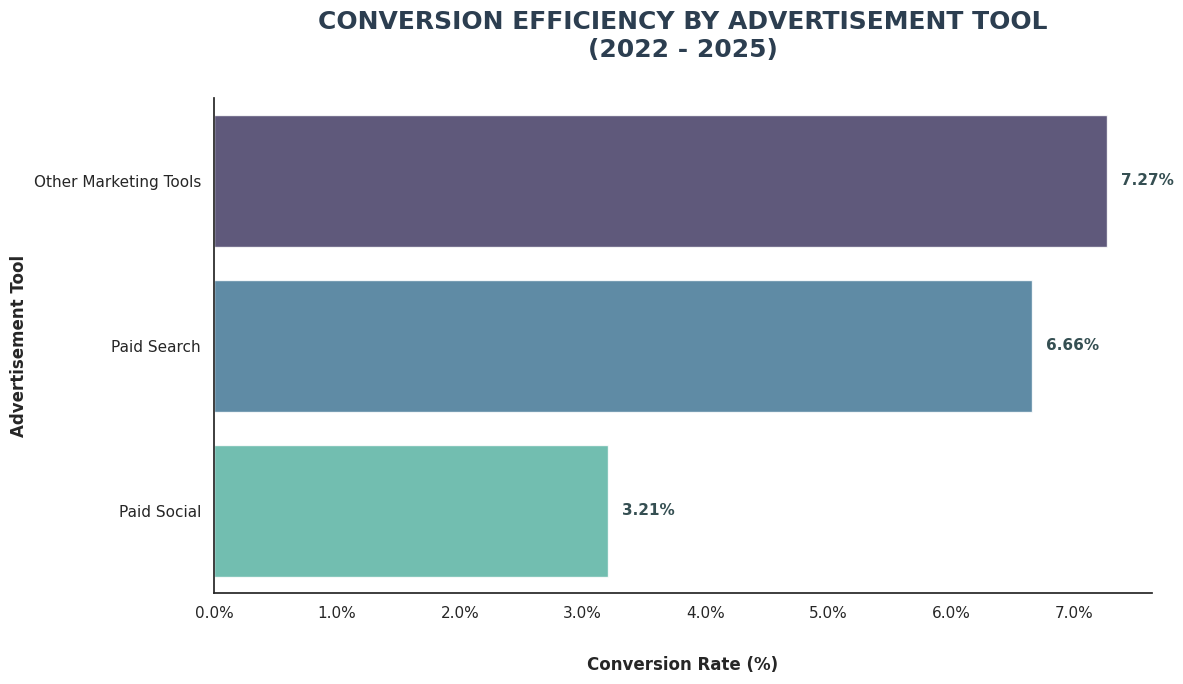

In [ ]:
# 1. PREPARE DATA
start_date, end_date = "2022-03-19", "2025-01-30"

# Aggregate Sessions and Orders at the source level first
cvr_spark = website_sessions.alias("s") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .groupBy("utm_source").agg(
        F.count("s.website_session_id").alias("sessions"),
        F.count("o.order_id").alias("orders")
    )

df_raw = cvr_spark.toPandas()

# 2. CATEGORIZE BY ADVERTISEMENT TOOL
def categorize_tool(row):
    source = str(row['utm_source']).lower()
    if any(x in source for x in ['gsearch', 'bsearch']):
        return 'Paid Search'
    elif any(x in source for x in ['social', 'facebook', 'instagram']):
        return 'Paid Social'
    else:
        return 'Other Marketing Tools'

df_raw['ad_tool'] = df_raw.apply(categorize_tool, axis=1)

# Final Grouping: Combine tools and calculate Conversion Rate
tool_cvr = df_raw.groupby('ad_tool').agg({'sessions': 'sum', 'orders': 'sum'}).reset_index()
tool_cvr['cvr'] = (tool_cvr['orders'] / tool_cvr['sessions']) * 100
tool_cvr = tool_cvr.sort_values('cvr', ascending=False)

# 3. VISUALIZATION (Horizontal)
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")


ax = sns.barplot(data=tool_cvr, x='cvr', y='ad_tool', palette="mako", alpha=0.85)

# 4. FORMATTING
plt.title("CONVERSION EFFICIENCY BY ADVERTISEMENT TOOL\n(2022 - 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Format X-axis as percentage (prevents scientific notation/le6)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

# X-axis label in a lower position
ax.set_xlabel("Conversion Rate (%)", fontsize=12, fontweight='bold', labelpad=25)
ax.set_ylabel("Advertisement Tool", fontsize=12, fontweight='bold')

# Add CVR labels at the end of the bars
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}%',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=11, fontweight='black', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

Users traffic search

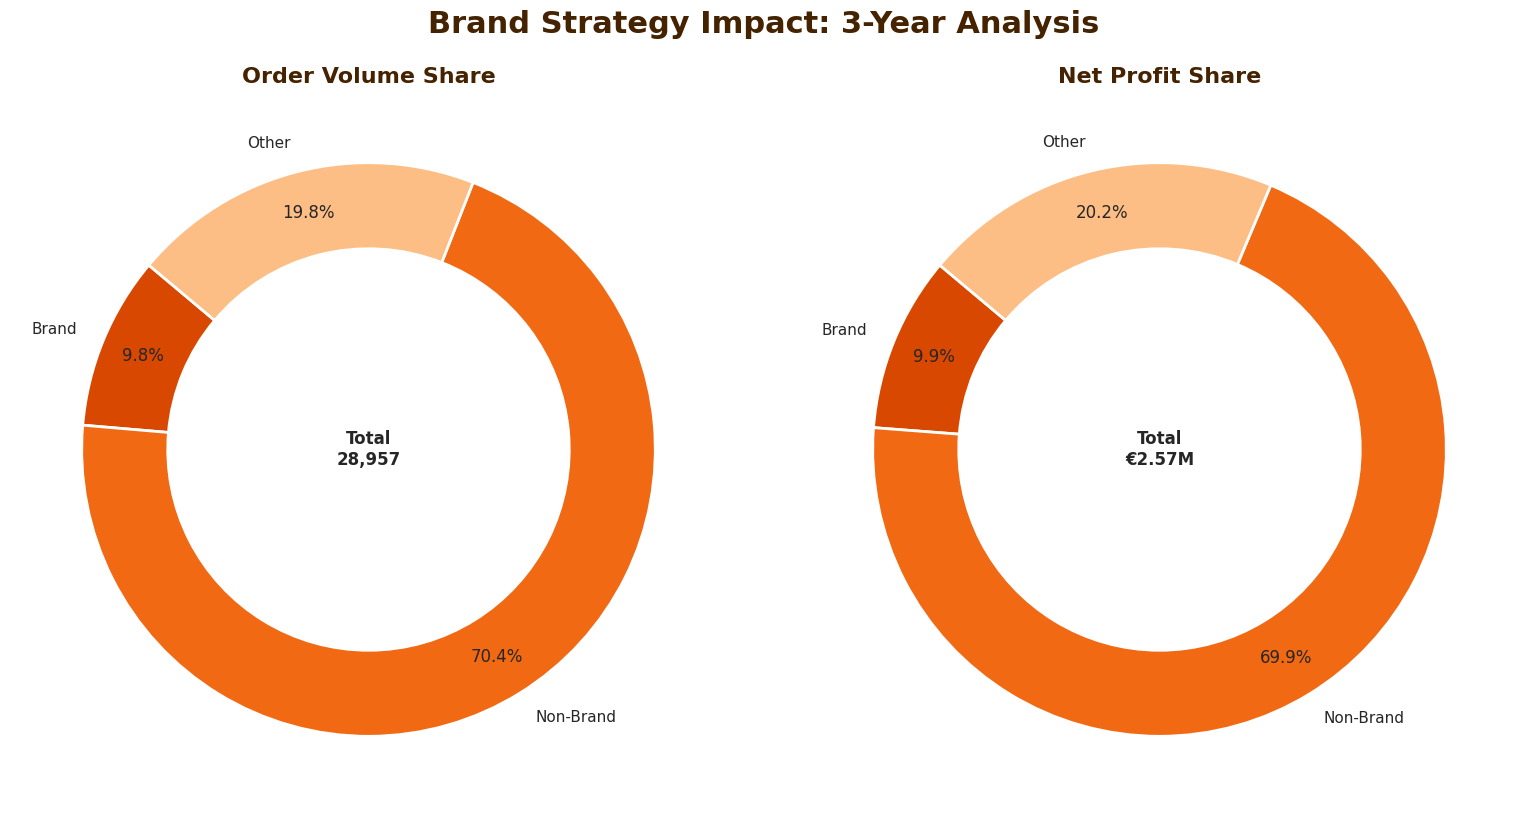

In [ ]:
# 1. DATA PREP
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

brand_spark = orders.filter((F.col("date_of_creation") >= start_date) &
                            (F.col("date_of_creation") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .join(website_sessions, orders.website_session_id == website_sessions.website_session_id) \
    .select("utm_campaign", "price_euro", "cogs_euro", "order_id")

df_raw = brand_spark.toPandas()

def categorize_brand(campaign):
    campaign = str(campaign).lower()
    if 'nonbrand' in campaign: return 'Non-Brand'
    elif 'brand' in campaign: return 'Brand'
    else: return 'Other'

df_raw['Category'] = df_raw['utm_campaign'].apply(categorize_brand)
df_raw['Net_Profit'] = df_raw['price_euro'] - df_raw['cogs_euro'] - 10

summary = df_raw.groupby('Category').agg({'order_id': 'count', 'Net_Profit': 'sum'}).reset_index()

# 2. CREATE THE VISUALIZATION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# THE ORANGE PALETTE:
orange_fade = ["#D94801", "#F16913", "#FDBE85"]

# Volume Donut
ax1.pie(summary['order_id'], labels=summary['Category'], autopct='%1.1f%%',
        startangle=140, colors=orange_fade, pctdistance=0.85,
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2))
ax1.set_title("Order Volume Share", fontsize=16, fontweight='bold', color='#452200')
ax1.text(0, 0, f"Total\n{summary['order_id'].sum():,}", ha='center', va='center', fontweight='bold', fontsize=12)

# Profit Donut
ax2.pie(summary['Net_Profit'], labels=summary['Category'], autopct='%1.1f%%',
        startangle=140, colors=orange_fade, pctdistance=0.85,
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2))
ax2.set_title("Net Profit Share", fontsize=16, fontweight='bold', color='#452200')
ax2.text(0, 0, f"Total\n€{summary['Net_Profit'].sum()/1e6:.2f}M", ha='center', va='center', fontweight='bold', fontsize=12)

plt.suptitle("Brand Strategy Impact: 3-Year Analysis", fontsize=22, fontweight='black', color='#452200', y=1.02)
plt.tight_layout()
plt.show()

metrics by traffic source (Volume, Expense, and Net Profit by traffic source)


In [ ]:
# --- CALCULATION ---
total_profit = source_sorted['profit'].sum()

# This finds the profit for the top row since it's sorted
paid_search_profit = source_sorted.iloc[0]['profit']

profit_percentage = (paid_search_profit / total_profit) * 100

print(f"Total Profit: €{total_profit:,.0f}")
print(f"Paid Search Profit: €{paid_search_profit:,.0f}")
print(f"Percentage of Total Profit: {profit_percentage:.1f}%")

Total Profit: €4,196,172
Paid Search Profit: €4,134,692
Percentage of Total Profit: 98.5%


- conclusion:
The traffic (volume) and profit are both dominated by Non Brand , paid Gsearch

## ***Question 2: Landing page analysis***


/tmp/ipython-input-2044106457.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_cvr, x='pageview_url', y='CVR', palette=faded_blue_green)
/tmp/ipython-input-2044106457.py:37: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=df_cvr, x='pageview_url', y='CVR', palette=faded_blue_green)


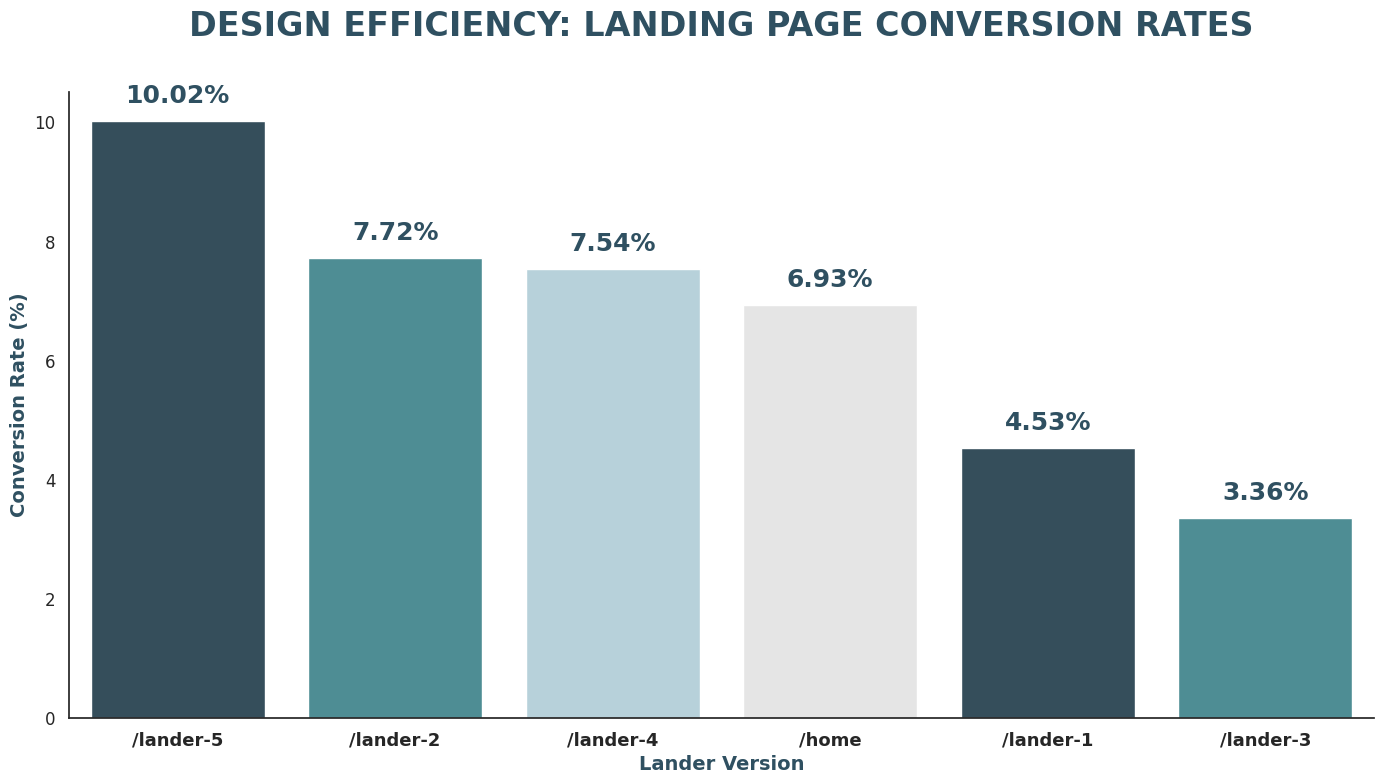

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DATA PREP: Mar 2022 - Jan 2025
start_date, end_date = "2022-03-19", "2025-01-30"

# Find the first pageview (The Lander) for every session to avoid ambiguity
first_pv = website_pageviews.groupBy("website_session_id").agg(F.min("website_pageview_id").alias("min_pv"))

landers = first_pv.alias("pv1").join(website_pageviews.alias("pv2"),
                                     F.col("pv1.min_pv") == F.col("pv2.website_pageview_id")) \
    .select(F.col("pv1.website_session_id"), F.col("pv2.pageview_url"))

# Calculate CVR per Lander
cvr_spark = landers.alias("l") \
    .join(website_sessions.alias("s"), "website_session_id") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .groupBy("l.pageview_url").agg(
        F.count("s.website_session_id").alias("Sessions"),
        F.count("o.order_id").alias("Orders")
    ) \
    .withColumn("CVR", (F.col("Orders") / F.col("Sessions")) * 100) \
    .na.fill(0)

# Filter for design pages and sort
df_cvr = cvr_spark.toPandas()
df_cvr = df_cvr[df_cvr['pageview_url'].str.contains('home|lander', case=False)].sort_values("CVR", ascending=False)

# 2. VISUALIZATION
plt.figure(figsize=(14, 8))

faded_blue_green = ["#2F5061", "#4297A0", "#B1D4E0", "#E5E5E5"]

ax = sns.barplot(data=df_cvr, x='pageview_url', y='CVR', palette=faded_blue_green)

# --- STYLING LABELS ---
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 18),
                textcoords='offset points',
                fontsize=18,
                fontweight='black',
                color='#2F5061')

# Formatting the chart
plt.title("DESIGN EFFICIENCY: LANDING PAGE CONVERSION RATES",
          fontsize=24, fontweight='black', pad=40, color='#2F5061')

plt.ylabel("Conversion Rate (%)", fontsize=14, fontweight='bold', color='#2F5061')
plt.xlabel("Lander Version", fontsize=14, fontweight='bold', color='#2F5061')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=12)

# Clean aesthetics
sns.despine()
plt.tight_layout()
plt.show()

The "Profitability vs. Conversion" Matrix

In [ ]:
#data preperation

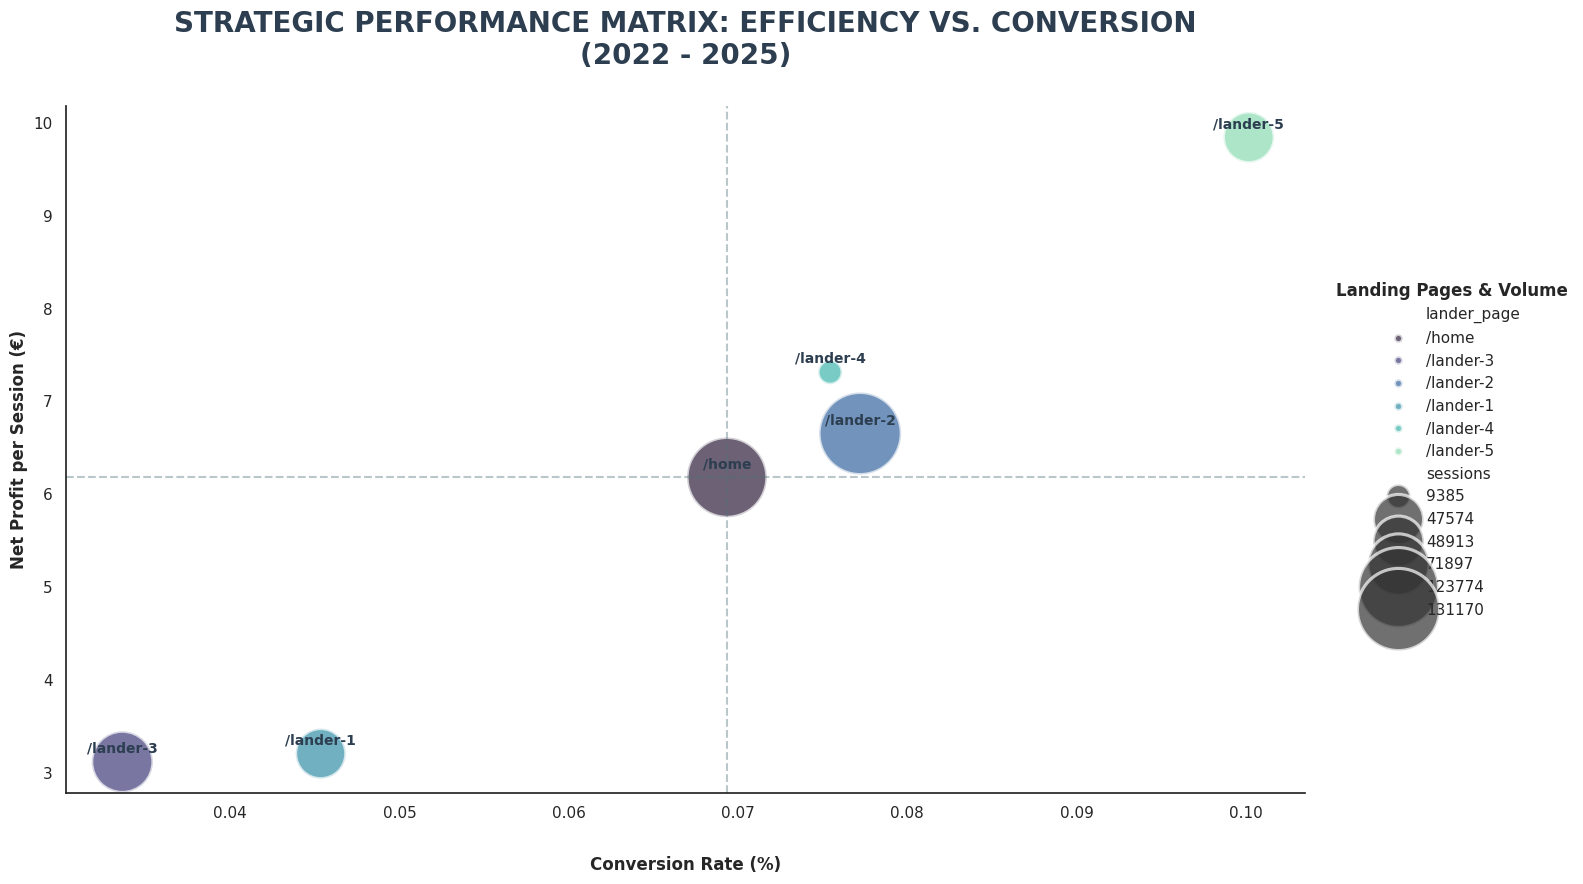

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SETTINGS & DATA
lander_matrix_df = matrix_spark.toPandas()

plt.figure(figsize=(16, 9))
sns.set_theme(style="white")

# 2. CREATE THE MATRIX
ax = sns.scatterplot(
    data=lander_matrix_df,
    x='conversion_rate',
    y='profit_per_session',
    size='sessions',
    hue='lander_page',
    sizes=(300, 3500),
    alpha=0.7,
    palette='mako',
    edgecolor='white'
)

# 3. POSITION LEGEND ON THE RIGHT
# We use 'prop' or 'title_fontproperties' to handle weight without errors
plt.legend(
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    title="Landing Pages & Volume"
)

# Optional: To make the legend title bold specifically after creation
ax.get_legend().get_title().set_fontweight('bold')

# 4. BASELINE CROSSHAIRS
home_data = lander_matrix_df[lander_matrix_df['lander_page'].str.contains('/home')]
if not home_data.empty:
    h_cr = home_data['conversion_rate'].values[0]
    h_prof = home_data['profit_per_session'].values[0]
    plt.axvline(h_cr, color='#50727B', linestyle='--', alpha=0.4)
    plt.axhline(h_prof, color='#50727B', linestyle='--', alpha=0.4)

# 5. STYLING
plt.title("STRATEGIC PERFORMANCE MATRIX: EFFICIENCY VS. CONVERSION\n(2022 - 2025)",
          fontsize=20, fontweight='black', pad=30, color='#2C3E50')

# Lower X-axis label
plt.xlabel("Conversion Rate (%)", fontsize=12, fontweight='bold', labelpad=25)
plt.ylabel("Net Profit per Session (€)", fontsize=12, fontweight='bold')

# Labels for the bubbles
for i in range(lander_matrix_df.shape[0]):
    plt.text(lander_matrix_df.conversion_rate[i],
             lander_matrix_df.profit_per_session[i] + 0.1,
             lander_matrix_df.lander_page[i],
             ha='center', fontweight='bold', fontsize=10, color='#2C3E50')

sns.despine()
plt.tight_layout()
plt.show()

X-Axis (Conversion Rate): This measures Persuasion. The further to the right a page is, the better it is at turning a "visitor" into a "buyer."

Y-Axis (Profit per Session): This measures Financial Efficiency. The higher a page is, the more money it actually puts in the bank after paying for the ad.

Bubble Size (Sessions): This represents Reliability/Volume. A large bubble means thousands of people saw it (high confidence in the data); a tiny bubble means the result might just be a lucky coincidence.

--> The Champions (Top-Right): Landers here have a higher conversion rate and make more money per click than the homepage. /lander-5 almost certainly sits here.

--> The High-Volume Loss (Bottom-Right): High Conversion, but low profit per session.

--> The Niche Players (Top-Left ): Low conversion, but high profit when they do convert.

--> The Failures (Bottom-Left): Underperforming the baseline on both metrics. These should not be taken into account

The "Revenue vs. Cost" Comparison

In [ ]:
#GRAPH 3 — Revenue Composition by Landing Page (Cost vs Profit)

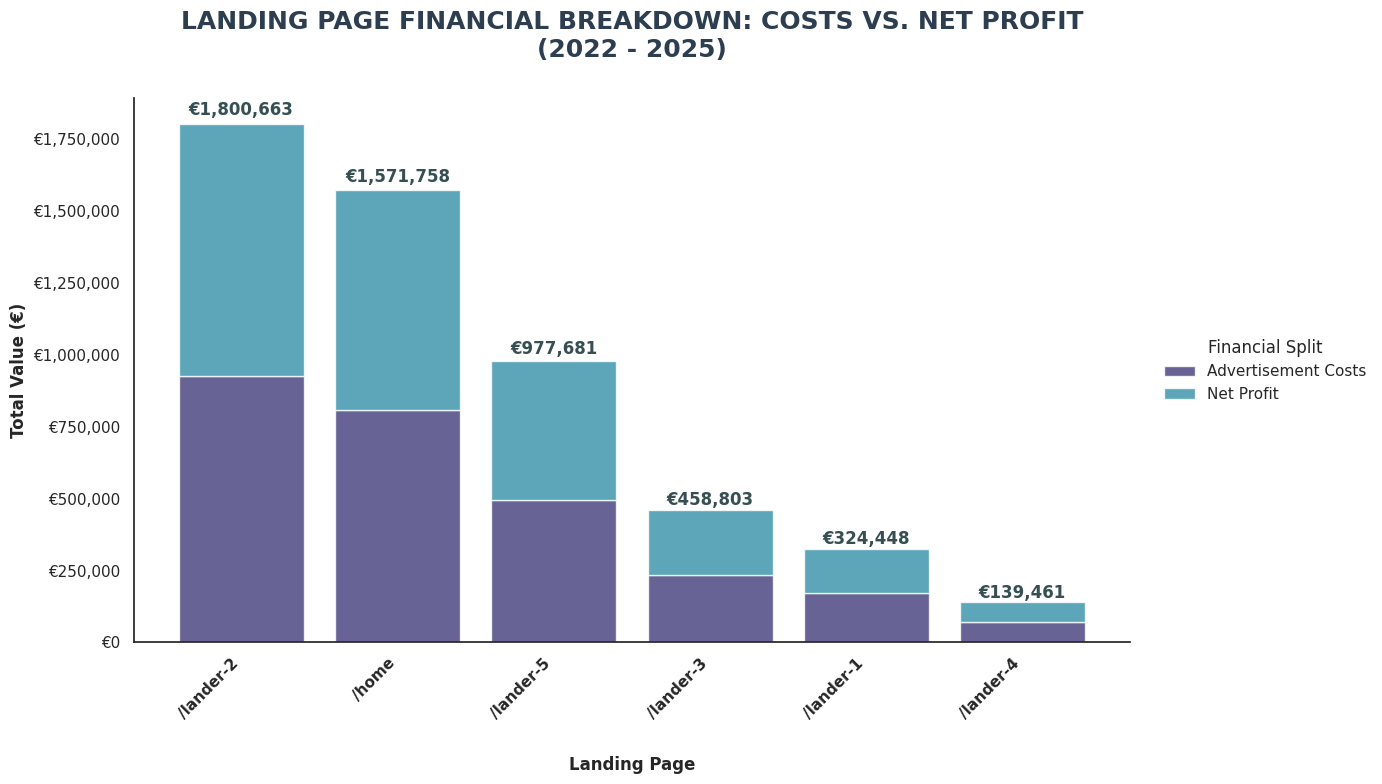

In [ ]:


# 1. DATA PREPARATION (March 2022 - Jan 2025)
start_date, end_date = "2022-03-19", "2025-01-30"

w = Window.partitionBy("website_session_id").orderBy("date_of_creation")
first_pageviews = website_pageviews \
    .filter((F.col("created_at") >= start_date) & (F.col("created_at") <= end_date)) \
    .withColumn("rn", F.row_number().over(w)) \
    .filter(F.col("rn") == 1) \
    .select("website_session_id", F.col("pageview_url").alias("lander_page"))

finance_spark = first_pageviews.alias("l") \
    .join(website_sessions.alias("s"), "website_session_id") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .join(products.alias("p"), F.col("o.primary_product_id") == F.col("p.product_id"), "left") \
    .groupBy("l.lander_page").agg(
        F.sum(F.coalesce(F.col("o.cogs_euro"), F.lit(0)) +
              F.when(F.col("o.order_id").isNotNull(), 10).otherwise(0)).alias("Ad_Costs"),
        F.sum(F.coalesce(F.col("o.price_euro"), F.lit(0)) -
              (F.coalesce(F.col("o.cogs_euro"), F.lit(0)) +
               F.when(F.col("o.order_id").isNotNull(), 10).otherwise(0))).alias("Net_Profit")
    )

df_finance = finance_spark.toPandas().sort_values("Net_Profit", ascending=False)

plt.figure(figsize=(14, 8))
sns.set_theme(style="white")

colors = [sns.color_palette("mako")[1], sns.color_palette("mako")[3]]

plt.bar(df_finance['lander_page'], df_finance['Ad_Costs'],
        color=colors[0], alpha=0.8, label='Advertisement Costs')

plt.bar(df_finance['lander_page'], df_finance['Net_Profit'],
        bottom=df_finance['Ad_Costs'], color=colors[1], alpha=0.8, label='Net Profit')

plt.title("LANDING PAGE FINANCIAL BREAKDOWN: COSTS VS. NET PROFIT\n(2022 - 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Format Y-axis as Currency with commas (Removing le6)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))

# Lower X-axis labels and rotate if URLs are long
plt.xticks(rotation=45, ha='right', fontweight='bold')
plt.ylabel("Total Value (€)", fontsize=12, fontweight='bold')
plt.xlabel("Landing Page", fontsize=12, fontweight='bold', labelpad=25)

# Legend on the right
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, title="Financial Split")

# Annotate total revenue (Cost + Profit) on top of vertical bars
for i, (cost, profit) in enumerate(zip(df_finance['Ad_Costs'], df_finance['Net_Profit'])):
    total = cost + profit
    plt.text(i, total + (total * 0.01), f'€{total:,.0f}',
             ha='center', va='bottom', fontweight='bold', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

/tmp/ipython-input-1498294631.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_eff, x='Profit_per_100_Sessions', y='lander_page', palette="mako", alpha=0.8)


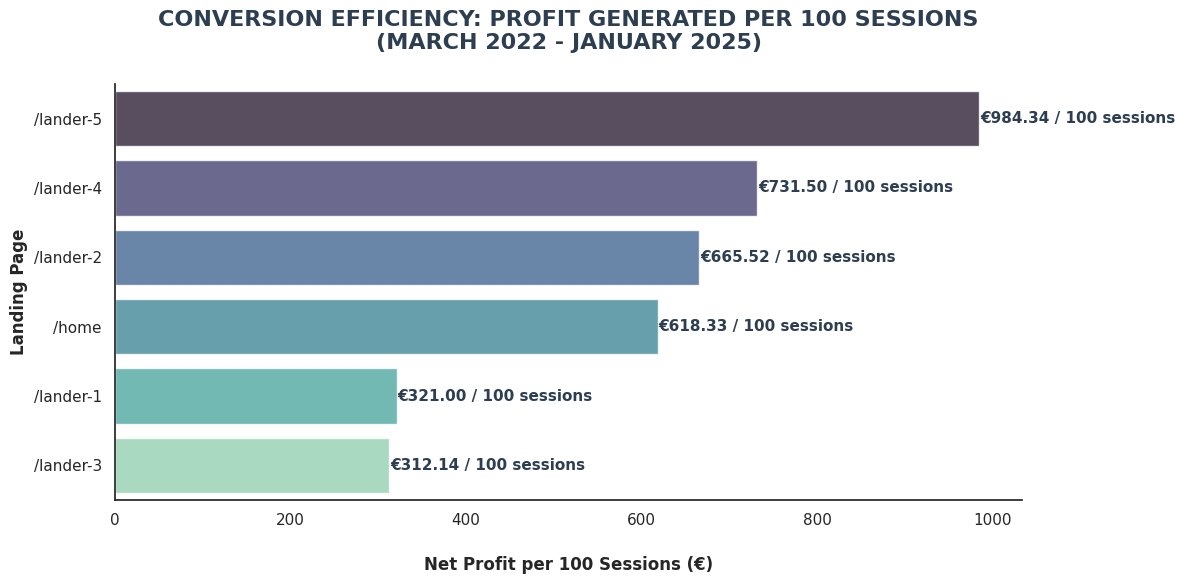

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SETUP & DATA PREP
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
start_date, end_date = "2022-03-19", "2025-01-30"

# Identify Landers
first_pv = website_pageviews.groupBy("website_session_id").agg(F.min("website_pageview_id").alias("min_pv"))

landers = first_pv.alias("fp").join(
    website_pageviews.alias("wp"),
    F.col("fp.min_pv") == F.col("wp.website_pageview_id") # Changed min_pv_id -> min_pv
).select(
    F.col("fp.website_session_id"),
    F.col("wp.pageview_url").alias("lander_page")
).filter(F.col("lander_page").rlike("(?i)home|lander"))

# Calculate Efficiency
efficiency_spark = landers.alias("l") \
    .join(website_sessions.alias("s"), "website_session_id") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .join(products.alias("p"), F.col("o.primary_product_id") == F.col("p.product_id"), "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .groupBy("l.lander_page").agg(
        F.count("s.website_session_id").alias("Total_Sessions"),
        # Use coalesce to handle nulls in profit calculation
        (F.sum(F.coalesce(F.col("o.price_euro"), F.lit(0))) -
         (F.sum(F.coalesce(F.col("o.cogs_euro"), F.lit(0))) + (F.count("o.order_id") * 10))).alias("Net_Profit")
    ) \
    .withColumn("Profit_per_100_Sessions", (F.col("Net_Profit") / F.col("Total_Sessions")) * 100)

df_eff = efficiency_spark.toPandas().sort_values("Profit_per_100_Sessions", ascending=False)

# 2. VISUALIZATION
plt.figure(figsize=(12, 6))
sns.set_theme(style="white")

# Using the requested Mako palette
ax = sns.barplot(data=df_eff, x='Profit_per_100_Sessions', y='lander_page', palette="mako", alpha=0.8)

# Formatting the labels aside the bars
for i, row in df_eff.reset_index().iterrows():
    ax.text(row['Profit_per_100_Sessions'] + 1, i, f"€{row['Profit_per_100_Sessions']:.2f} / 100 sessions",
            va='center', fontweight='black', fontsize=11, color='#2C3E50')

plt.title("CONVERSION EFFICIENCY: PROFIT GENERATED PER 100 SESSIONS\n(MARCH 2022 - JANUARY 2025)",
          fontsize=16, fontweight='black', pad=25, color='#2C3E50')

plt.xlabel("Net Profit per 100 Sessions (€)", fontweight='bold', labelpad=20)
plt.ylabel("Landing Page", fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

Device used segmentation (which device is most used to connect to the website)  

/tmp/ipython-input-3545216178.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_device, x='device_type', y='cvr', palette="mako", alpha=0.85)


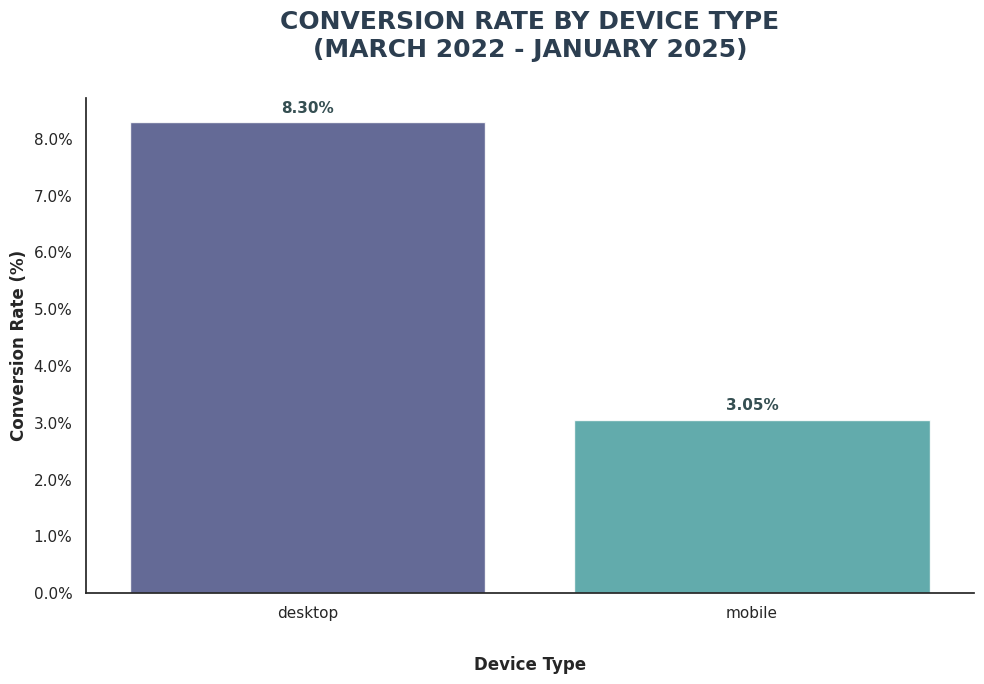

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. DATA PREPARATION (March 2022 - Jan 2025)
start_date, end_date = "2022-03-19", "2025-01-30"

# Join sessions to orders to get conversion counts per device
device_spark = website_sessions.alias("s") \
    .join(orders.alias("o"), "website_session_id", "left") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .groupBy("s.device_type").agg(
        F.count("s.website_session_id").alias("sessions"),
        F.count("o.order_id").alias("orders")
    )

# Calculate CVR in Pandas
df_device = device_spark.toPandas()
df_device['cvr'] = (df_device['orders'] / df_device['sessions']) * 100
df_device = df_device.sort_values('cvr', ascending=False)

# 2. VISUALIZATION
plt.figure(figsize=(10, 7))
sns.set_theme(style="white")

# Vertical Bar Chart
ax = sns.barplot(data=df_device, x='device_type', y='cvr', palette="mako", alpha=0.85)

# 3. FORMATTING
plt.title("CONVERSION RATE BY DEVICE TYPE\n(MARCH 2022 - JANUARY 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Format Y-axis as Percentage
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

plt.ylabel("Conversion Rate (%)", fontsize=12, fontweight='bold')
plt.xlabel("Device Type", fontsize=12, fontweight='bold', labelpad=25)

# Annotate percentages on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=11, fontweight='black', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

This shows that the desktop is the primary driver for session connections

this shows that Users prefer the "full experience" of the desktop site to make final purchases.


In [ ]:
#-->The Strategy: "Double Down on Desktop." Maximize your bidding on GSearch and BSearch for desktop users. Since you know these users convert, you can afford a higher CPC (Cost Per Click) for them

**Device-Channel Synergy**

The following code visualizes the intersection of User Hardware and Marketing Origin, revealing the primary entry points for our two most distinct customer segments.

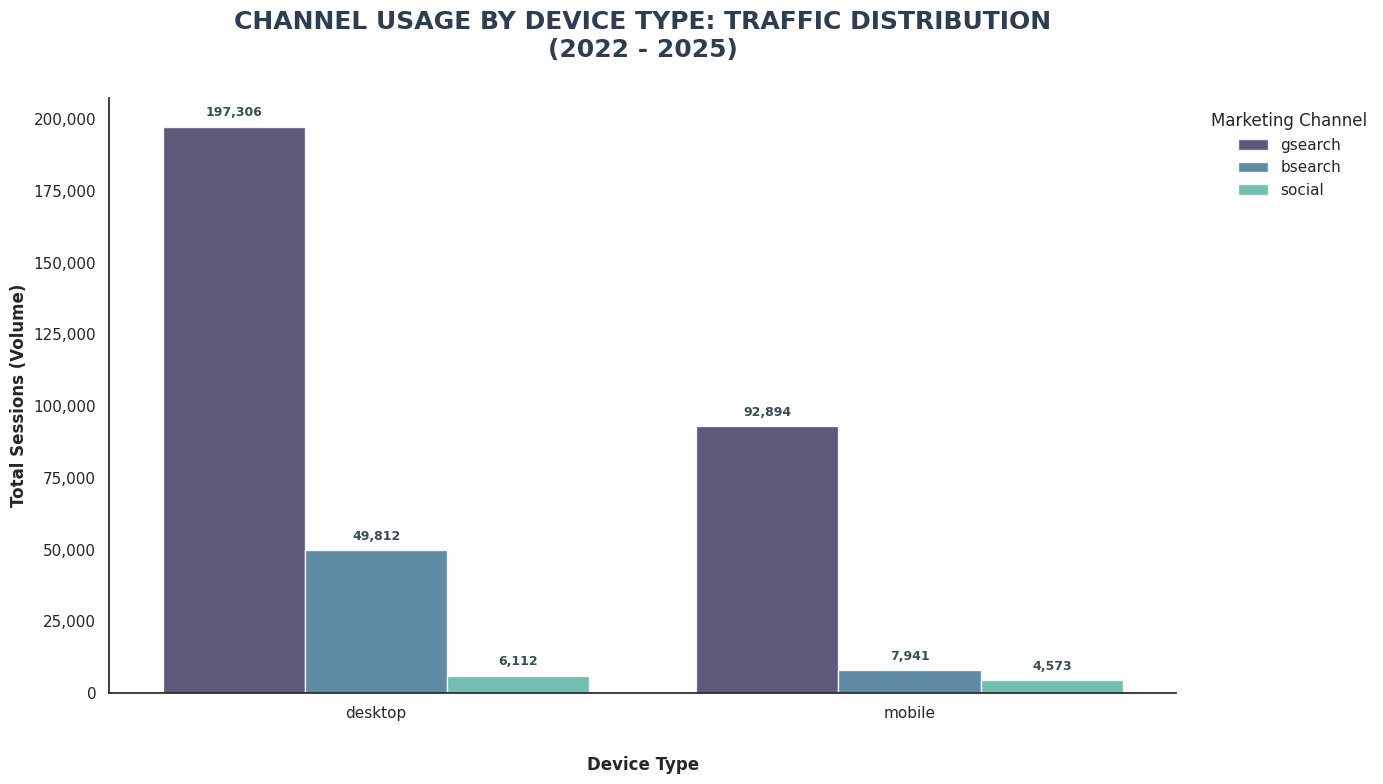

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. DATA PREPARATION (March 2022 - Jan 2025)
start_date, end_date = "2022-03-19", "2025-01-30"
channels_to_show = ["gsearch", "bsearch", "social", "other"]

# Aggregating session counts by Device and Channel
usage_spark = website_sessions.alias("s") \
    .filter((F.col("s.date_of_creation") >= start_date) & (F.col("s.date_of_creation") <= end_date)) \
    .filter(F.col("utm_source").rlike("(?i)" + "|".join(channels_to_show))) \
    .groupBy("device_type", "utm_source").agg(
        F.count("website_session_id").alias("sessions")
    )

df_usage = usage_spark.toPandas()
# Sorting to ensure the largest bars appear first for readability
df_usage = df_usage.sort_values(['device_type', 'sessions'], ascending=[True, False])

# 2. VISUALIZATION
plt.figure(figsize=(14, 8))
sns.set_theme(style="white")

# Using 'hue' to separate channels for each device
ax = sns.barplot(data=df_usage, x='device_type', y='sessions', hue='utm_source',
                 palette="mako", alpha=0.85)

# 3. FORMATTING
plt.title("CHANNEL USAGE BY DEVICE TYPE: TRAFFIC DISTRIBUTION\n(2022 - 2025)",
          fontsize=18, fontweight='black', pad=30, color='#2C3E50')

# Format Y-axis with commas (Removing le6)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.ylabel("Total Sessions (Volume)", fontsize=12, fontweight='bold')
plt.xlabel("Device Type", fontsize=12, fontweight='bold', labelpad=25)

# Move Legend to the right to avoid overlapping bars
plt.legend(title="Marketing Channel", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Add volume labels on top of bars
for p in ax.patches:
    if p.get_height() > 0: # Avoid labeling empty bars
        ax.annotate(f'{p.get_height():,.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=9, fontweight='bold', color='#354F52')

sns.despine()
plt.tight_layout()
plt.show()

## **Products visualization**

In [ ]:
from pyspark.sql.functions import col

order_items \
    .join(products, on="product_id", how="inner") \
    .select(
        col("product_name"),
        col("price_euro")
    ) \
    .distinct() \
    .orderBy(col("price_euro").desc()) \
    .show()


+------------+----------+
|product_name|price_euro|
+------------+----------+
|TechFortress|    159.99|
|    CorePack|    149.99|
|     AirLite|    145.99|
|    EcoShell|    129.99|
+------------+----------+



In [ ]:
from pyspark.sql import functions as F

# 1. CALCULATE THE CORE METRICS
# We join orders and products, then aggregate
financial_table_spark = orders.join(products, orders.primary_product_id == products.product_id) \
    .groupBy("product_name").agg(
        F.count("order_id").alias("Units"),
        F.sum("price_euro").alias("Total_Revenue"),
        F.sum("cogs_euro").alias("Total_COGS"),
        (F.count("order_id") * 10).alias("Total_Shipping") # The €10 flat fee
    )

# 2. CALCULATE DERIVED FIELDS (Profit and Margins)
# We convert to Pandas to make the final formatting easier for a presentation
report_df = financial_table_spark.toPandas()

report_df['Total_Cost'] = report_df['Total_COGS'] + report_df['Total_Shipping']
report_df['Net_Profit'] = report_df['Total_Revenue'] - report_df['Total_Cost']
report_df['Margin_%'] = (report_df['Net_Profit'] / report_df['Total_Revenue']) * 100

# 3. SORT BY NET PROFIT
report_df = report_df.sort_values(by='Net_Profit', ascending=False)

# 4.  PRINTING
# This adds Euro signs and formatting
def format_currency(x):
    return f"€{x:,.2f}"

styled_report = report_df.style.format({
    'Total_Revenue': format_currency,
    'Total_COGS': format_currency,
    'Total_Shipping': format_currency,
    'Total_Cost': format_currency,
    'Net_Profit': format_currency,
    'Margin_%': '{:.1f}%'
})

styled_report

,product_name,Units,Total_Revenue,Total_COGS,Total_Shipping,Total_Cost,Net_Profit,Margin_%
0,CorePack,21942,"€3,990,962.41","€1,840,947.91","€219,420.00","€2,060,367.91","€1,930,594.50",48.4%
3,TechFortress,4050,"€742,736.44","€336,729.44","€40,500.00","€377,229.44","€365,507.00",49.2%
2,AirLite,2668,"€512,742.43","€228,597.93","€26,680.00","€255,277.93","€257,464.50",50.2%
1,EcoShell,331,"€46,504.46","€21,267.46","€3,310.00","€24,577.46","€21,927.00",47.2%


/tmp/ipython-input-3799592825.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_pd, x='product_name', y='total_volume', palette="mako", alpha=0.8, ax=ax1)
/tmp/ipython-input-3799592825.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right', fontweight='bold')


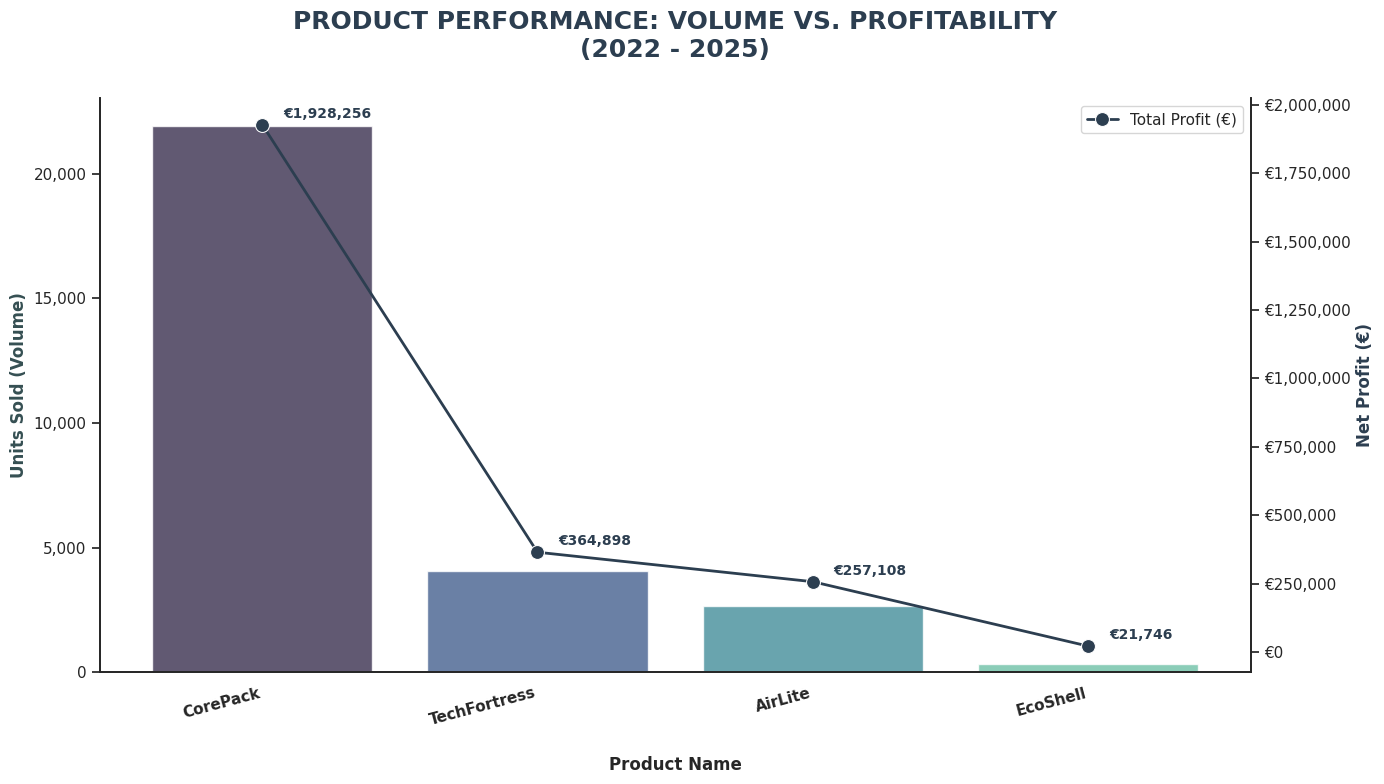

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. PREPARE DATA (Filtered for Mar 2022 - Jan 2025)
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

# Aggregating Volume AND Profit
perf_spark = orders.filter((F.col("created_at") >= start_date) &
                            (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .groupBy("product_name").agg(
        F.count("order_id").alias("total_volume"),
        F.sum(F.col("price_euro") - (F.col("cogs_euro") + 10)).alias("total_profit")
    )

perf_pd = perf_spark.toPandas().sort_values("total_volume", ascending=False)

# 2. CREATE THE VISUALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))
sns.set_theme(style="white")

color_line = "#2C3E50"

# --- BARS: TOTAL VOLUME  ---
sns.barplot(data=perf_pd, x='product_name', y='total_volume', palette="mako", alpha=0.8, ax=ax1)
ax1.set_ylabel("Units Sold (Volume)", fontsize=12, fontweight='bold', color="#354F52")
ax1.set_xlabel("Product Name", fontsize=12, fontweight='bold', labelpad=20)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# --- LINE: TOTAL PROFIT ---
ax2 = ax1.twinx()
sns.lineplot(data=perf_pd, x='product_name', y='total_profit', color=color_line,
             marker='o', markersize=10, linewidth=2, ax=ax2, label='Total Profit (€)')

ax2.set_ylabel("Net Profit (€)", fontsize=12, fontweight='bold', color=color_line)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}')) # No le6 formatting

# 3. ANNOTATIONS (Profit Only)
# Profit labels shifted to the right (aside) to avoid overlap with the line
for i, val in enumerate(perf_pd['total_profit']):
    ax2.annotate(f'€{val:,.0f}', (i, val), textcoords="offset points",
                 xytext=(15, 5), ha='left', fontweight='black',
                 fontsize=10, color=color_line)

# 4. FINAL STYLING
plt.title("PRODUCT PERFORMANCE: VOLUME VS. PROFITABILITY\n(2022 - 2025)",
          fontsize=18, fontweight='black', pad=30, color=color_line)

# Ensure no volume labels are added to ax1
sns.despine(right=False)
ax1.grid(False)
ax2.grid(False)

# Rotate x-axis labels if product names are long
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-674537201.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


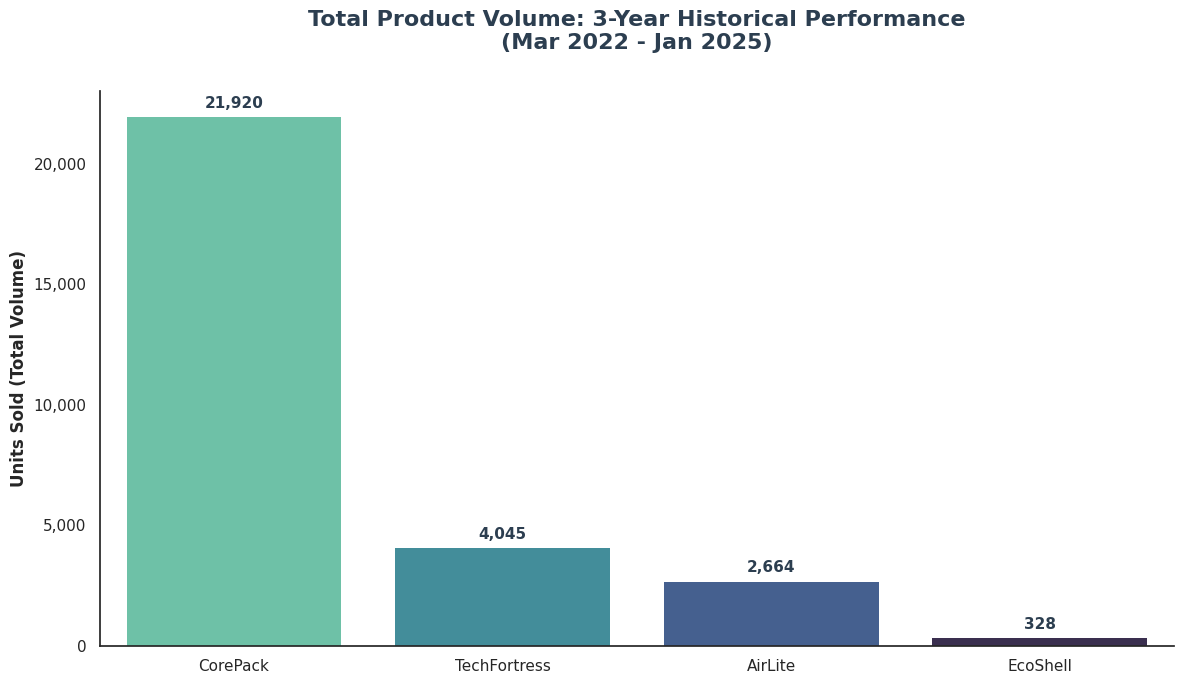

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. PREPARE DATA (Filtered for Mar 2022 - Jan 2025)
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

volume_spark = orders.filter((F.col("created_at") >= start_date) &
                             (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .groupBy("product_name").agg(F.count("order_id").alias("total_volume"))

# Convert to Pandas and sort for a logical flow
volume_pd = volume_spark.toPandas().sort_values("total_volume", ascending=False)

# 2. CREATE THE VISUALIZATION
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

ax = sns.barplot(
    data=volume_pd,
    x='product_name',
    y='total_volume',
    palette="mako_r",
    linewidth=0
)

# 3. ADD TOTALS ON TOP OF BARS
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',
                fontsize=11, fontweight='bold', color='#2C3E50')

# 4. FORMATTING
plt.title("Total Product Volume: 3-Year Historical Performance\n(Mar 2022 - Jan 2025)",
          fontsize=16, fontweight='bold', pad=30, color='#2C3E50')
plt.ylabel("Units Sold (Total Volume)", fontsize=12, fontweight='bold')
plt.xlabel("") # Cleaner look without redundant x-axis label

# Add commas to Y-axis numbers
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Remove top and right borders
sns.despine()

plt.tight_layout()
plt.show()

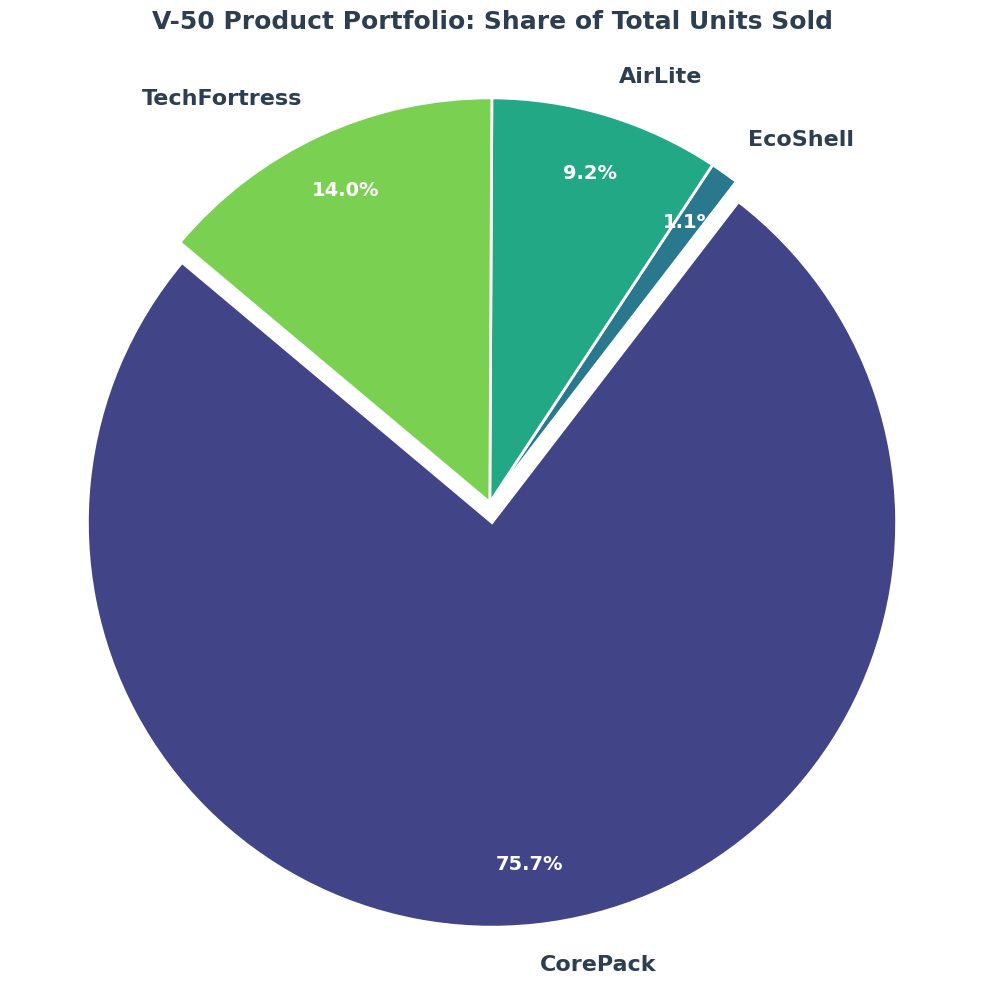

In [ ]:


# 1. AGGREGATE THE DATA
# We join orders and products to get the counts for each bag model
product_sales_spark = orders.join(products, orders.primary_product_id == products.product_id) \
    .groupBy("product_name").agg(F.count("order_id").alias("units_sold"))

# 2. CONVERT TO PANDAS
sales_pd = product_sales_spark.toPandas()

# 3. VISUALIZATION
plt.figure(figsize=(10, 10))

colors = plt.cm.viridis([0.2, 0.4, 0.6, 0.8])

# Create the pie chart
wedges, texts, autotexts = plt.pie(
    sales_pd['units_sold'],
    labels=sales_pd['product_name'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,
    explode=[0.05 if i == sales_pd['units_sold'].idxmax() else 0 for i in range(len(sales_pd))], # "Pop out" the bestseller
    wedgeprops={'edgecolor': 'white', 'linewidth': 2} # White borders for a modern look
)

# Style the text inside the slices
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(14)

# Style the labels outside
for text in texts:
    text.set_color('#2C3E50')
    text.set_fontsize(16)
    text.set_weight('bold')

# 4. FINAL TOUCHES
plt.title("V-50 Product Portfolio: Share of Total Units Sold",
          fontsize=18, fontweight='bold', color='#2C3E50', pad=30)

# Ensures the pie is a circle and not an oval
plt.axis('equal')

plt.tight_layout()
plt.show()

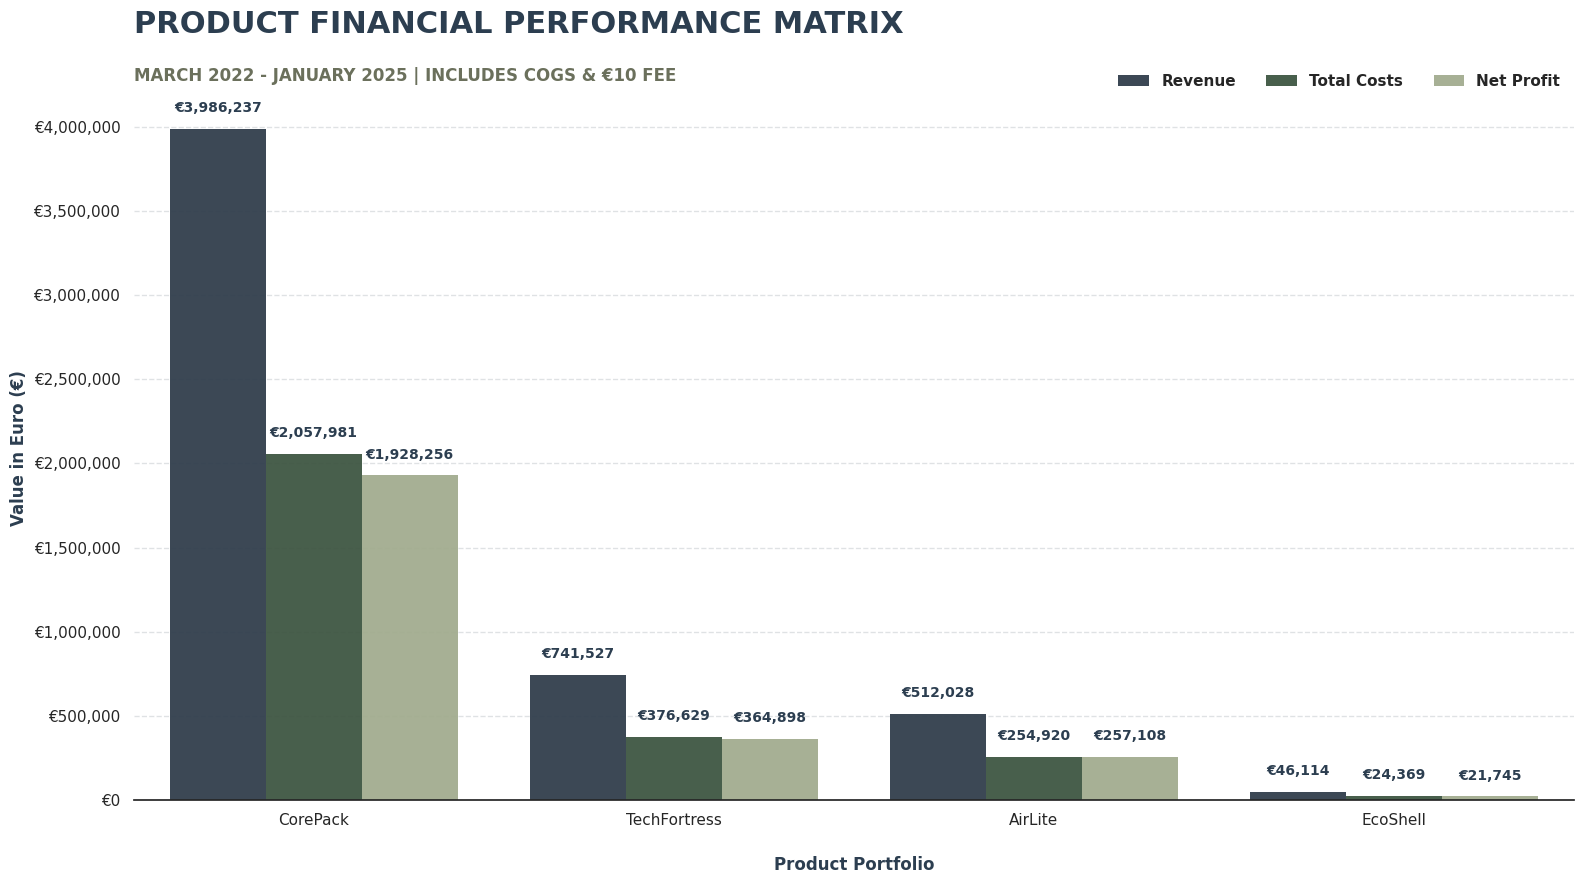

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. PREPARE DATA (Mar 2022 - Jan 2025)
start_date = "2022-03-19 00:00:00"
end_date   = "2025-01-30 23:59:59"

finance_spark = orders.filter((F.col("created_at") >= start_date) &
                              (F.col("created_at") <= end_date)) \
    .join(products, orders.primary_product_id == products.product_id) \
    .groupBy("product_name").agg(
        F.sum("price_euro").alias("Revenue"),
        (F.sum("cogs_euro") + (F.count("order_id") * 10)).alias("Total Costs"),
        (F.sum("price_euro") - (F.sum("cogs_euro") + (F.count("order_id") * 10))).alias("Net Profit")
    )

finance_pd = finance_spark.toPandas().sort_values("Revenue", ascending=False)
tidy_finance = finance_pd.melt(id_vars="product_name", var_name="Metric", value_name="Amount")

# 2. CREATE THE VISUALIZATION
plt.figure(figsize=(16, 9))
sns.set_theme(style="white")

custom_colors = ["#2C3E50", "#3A5A40", "#A3B18A"]
text_color = "#2C3E50"

ax = sns.barplot(
    data=tidy_finance,
    x='product_name',
    y='Amount',
    hue='Metric',
    palette=custom_colors,
    linewidth=0,
    alpha=0.95  # Slightly higher alpha for the darker colors
)

# 3. ADD NUMBERS ON TOP
for p in ax.patches:
    val = p.get_height()
    if val > 0:
        ax.annotate(f'€{val:,.0f}',
                    (p.get_x() + p.get_width() / 2., val),
                    ha='center', va='center',
                    xytext=(0, 15),
                    textcoords='offset points',
                    fontsize=10, fontweight='black', color=text_color)

# 4. FORMATTING & STYLE
plt.title("PRODUCT FINANCIAL PERFORMANCE MATRIX",
          fontsize=22, fontweight='black', pad=45, color=text_color, loc='left')

# Subtitle
plt.text(-0.5, ax.get_ylim()[1]*1.02, "MARCH 2022 - JANUARY 2025 | INCLUDES COGS & €10 FEE",
         fontsize=12, fontweight='bold', color='#6B705C')

# Remove le6 - Force standard currency
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))
plt.ylabel("Value in Euro (€)", fontsize=12, fontweight='bold', color=text_color)
plt.xlabel("Product Portfolio", fontsize=12, fontweight='bold', color=text_color, labelpad=20)

# Legend placement
plt.legend(title="", frameon=False, loc='upper right', bbox_to_anchor=(1, 1.05), ncol=3,
           fontsize=12, prop={'weight':'bold'})

# Clean gridlines
ax.yaxis.grid(True, linestyle='--', alpha=.15, color=text_color)
sns.despine(left=True)

plt.tight_layout()
plt.show()